# Prediction of Tumors of Unknown Primary Origin

In this project, we utilize both supervised and unsuperivsed learning methods to compare and contrast different methods of predicting the primary site of a tumor. We use the [Cancer Genome Atlas](https://cancergenome.nih.gov/) (TCGA) dataset, which contains gene expression data for 33 different cancer types. We use this data to train a supervised learning model to predict the primary site of a tumor based on its gene expression data. This project begins first by analyzing the data and visualizing the dataset. From there, we begin setting up machine learning methods and segway into deep learning with a focus on neural networks and intrepretability. Finally we conclude with a discussion of our results and future work.

1. [Imports](##Import)
2. [Data Analysis and Visualization](##Data-Analysis-and-Visualization)
    - [Datasets](###Datasets)
3. [Machine Learning](##Machine-Learning)
    - [Logistic Regression](###Logistic-Regression)
    - [Support Vector Machines](###Support-Vector-Machines)
    - [Random Forest](###Random-Forest)
    - [Extra Trees](###Extra-Trees)
    - [PCA](###PCA)
    - [K-Means](###K-Means-Clustering)  
4. [Deep Learning](##Deep-Learning)

## Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, silhouette_score, adjusted_rand_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

%matplotlib inline

The dataset is currently stored in `genes.csv` which is a file containing individual samples gene expression cancer RNA-Seq data. We also have `metadata.csv` which is a file that holds the class and metadata of the samples. We will use these files to create a dataframe that we can use to visualize the data.

The current dataset has five classes: BRCA, KIRC, COAD, LUAD, PRAD.

## Data Analysis and Visualization

In [2]:
metadata = pd.read_csv('./data/metadata.csv')
genes = pd.read_csv('./data/genes.csv')
# Validate genes match metadata
#assert np.mean(metadata['barcode'].sort_index().values == genes['barcode']) == 1.0, "Barcodes are not the same, issue with dataset"

In [3]:
# Metadata Shape
print('Metadata Shape:', metadata.shape)
# Metadata Head
print('Metdata Head')
print(metadata.head())

Metadata Shape: (3499, 14)
Metdata Head
                        barcode shortLetterCode tumor_stage  age_at_diagnosis  \
0  TCGA-A2-A1FW-01A-11R-A13Q-07              TP  stage iiia           22779.0   
1  TCGA-AO-A0J4-01A-11R-A034-07              TP    stage ia           15052.0   
2  TCGA-AN-A04C-01A-21R-A034-07              TP   stage iib           18851.0   
3  TCGA-EW-A1P6-01A-11R-A144-07              TP   stage iib           23485.0   
4  TCGA-AC-A4ZE-01A-11R-A41B-07              TP   stage iib           23284.0   

   year_of_diagnosis alcohol_history                       race  \
0             2010.0    Not Reported                      white   
1             2009.0    Not Reported  black or african american   
2             2008.0    Not Reported                      white   
3             2010.0    Not Reported                      white   
4             2012.0    Not Reported                      white   

                ethnicity  gender vital_status  year_of_birth  year_of

In [4]:
# Genes Shape
print('Genes Shape:', genes.shape)
# Genes Head
print('Genes Head')
print(genes.head())

Genes Shape: (3499, 56449)
Genes Head
                        barcode  ENSG00000000003  ENSG00000000005  \
0  TCGA-A2-A1FW-01A-11R-A13Q-07     86244.591270      9823.034260   
1  TCGA-AO-A0J4-01A-11R-A034-07    189616.381605       484.522925   
2  TCGA-AN-A04C-01A-21R-A034-07    487165.089371      4387.078898   
3  TCGA-EW-A1P6-01A-11R-A144-07    332551.984410      1391.861092   
4  TCGA-AC-A4ZE-01A-11R-A41B-07    183540.865052     66631.686840   

   ENSG00000000419  ENSG00000000457  ENSG00000000460  ENSG00000000938  \
0     6.684950e+05     83026.590072     35118.129436     21011.140106   
1     6.596550e+05     55156.161875     36692.305851     76121.982446   
2     1.015760e+06     87009.263165     66100.853330     31995.514208   
3     5.611524e+05     76101.921228     28917.214615     20319.008432   
4     4.904271e+05    149816.535032     54872.135407     21726.623850   

   ENSG00000000971  ENSG00000001036  ENSG00000001084  ...  ENSG00000281880  \
0    123409.492486    289653.5

In [5]:
metadata_counts = metadata.groupby(['cancer_type'])['barcode'].count()
metadata_proportions = metadata_counts / metadata.shape[0]
metadata_table = pd.DataFrame({'Count': metadata_counts, 'Proportion': metadata_proportions})
metadata_table.sort_values(by='Proportion', ascending=False)

Count  Proportion
cancer_type                   
BRCA          1222    0.349243
KIRC           611    0.174621
LUAD           594    0.169763
PRAD           551    0.157474
COAD           521    0.148900

In [6]:
pd.DataFrame(metadata.groupby(['cancer_type','gender'])['barcode'].count())

barcode
cancer_type gender         
BRCA        female     1208
            male         13
COAD        female      247
            male        272
KIRC        female      206
            male        405
LUAD        female      320
            male        274
PRAD        male        551

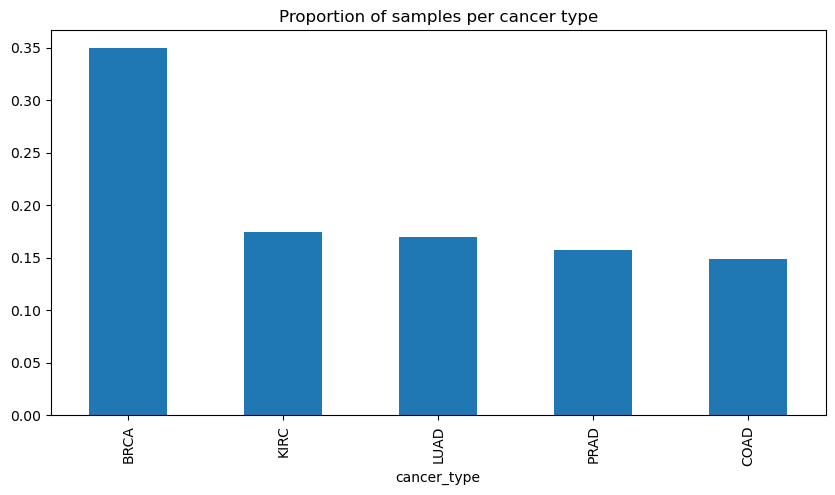

In [7]:
pd.DataFrame(
    metadata.groupby(['cancer_type'])['barcode'].count()/metadata.shape[0]).rename(columns={'barcode':'Proportion'}
).sort_values(by='Proportion', ascending=False).plot.bar(figsize=(10,5), title='Proportion of samples per cancer type', legend=False)
plt.show()

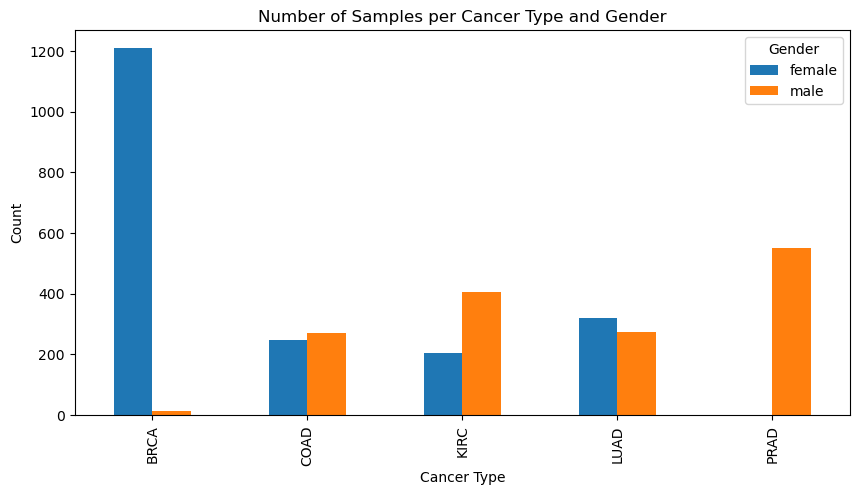

In [8]:
metadata.groupby(['cancer_type','gender'])['barcode'].count().unstack().plot(kind='bar', figsize=(10, 5))
plt.xlabel('Cancer Type')
plt.ylabel('Count')
plt.title('Number of Samples per Cancer Type and Gender')
plt.legend(title='Gender')
plt.show()

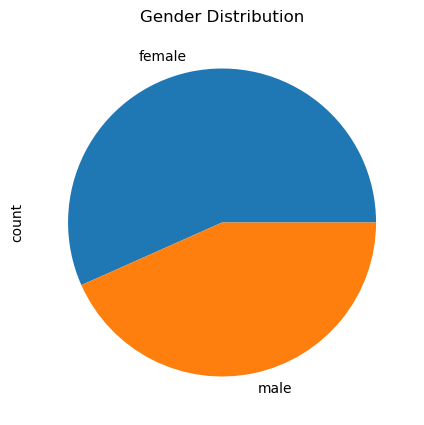

In [9]:
metadata = pd.read_csv('./data/metadata.csv')
gender_counts = metadata['gender'].value_counts()
gender_counts.plot(kind='pie', figsize=(5, 5), title='Gender Distribution')
plt.show()

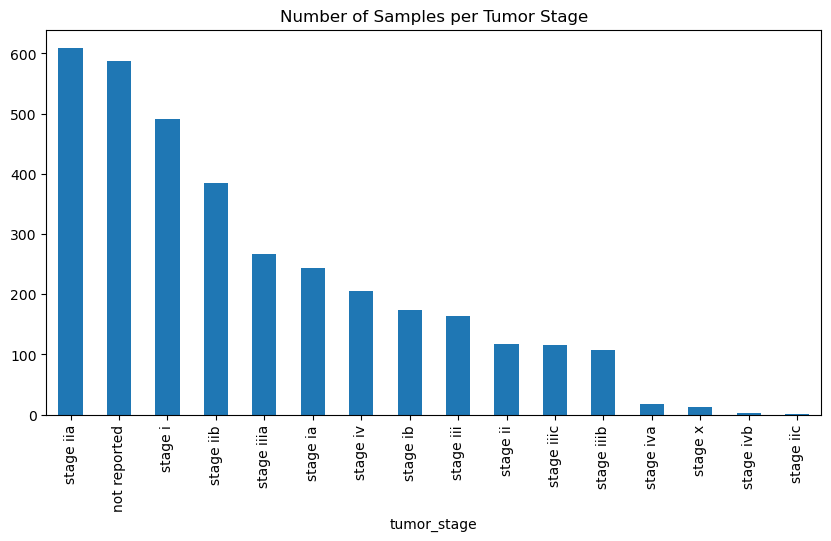

In [10]:
tumor_stage_counts = metadata['tumor_stage'].value_counts()
tumor_stage_counts.plot(kind='bar', figsize=(10, 5), title='Number of Samples per Tumor Stage')
plt.show()

count    3429.000000
mean       62.192399
std        12.180150
min        26.591781
25%        53.764384
50%        62.424658
75%        70.715068
max        90.060274
Name: age_at_diagnosis_years, dtype: float64


<Axes: title={'center': 'Distribution of Age at Diagnosis (years)'}, ylabel='Frequency'>

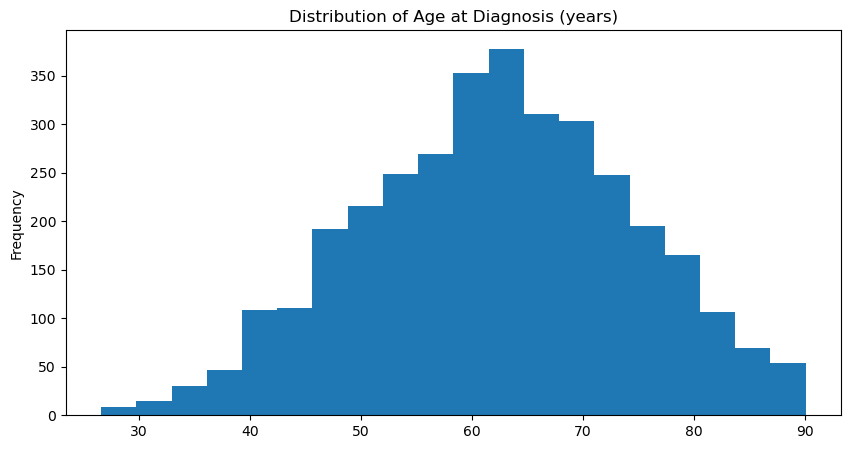

In [11]:
metadata['age_at_diagnosis_years'] = metadata['age_at_diagnosis'] / 365
print(metadata['age_at_diagnosis_years'].describe())
metadata['age_at_diagnosis_years'].plot(kind='hist', bins=20, figsize=(10, 5), title='Distribution of Age at Diagnosis (years)')

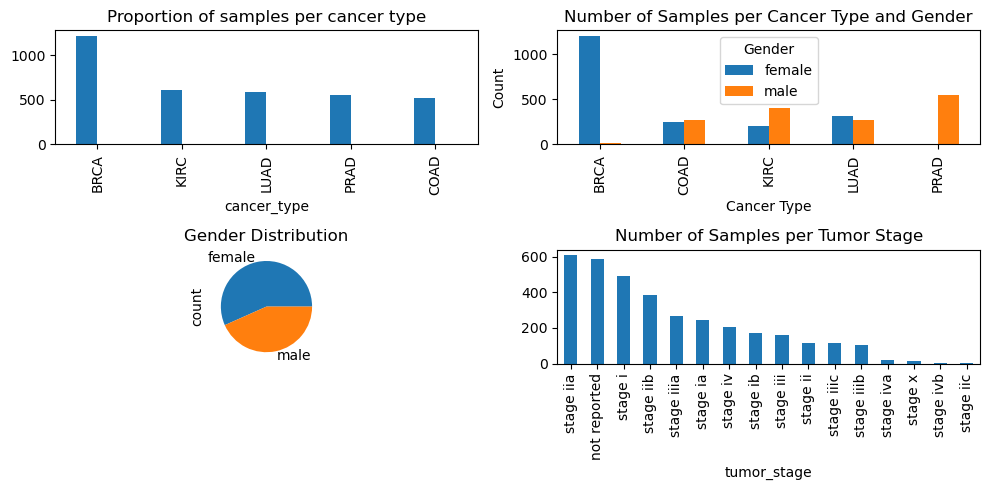

In [12]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
metadata_table.sort_values(by='Proportion', ascending=False).plot.bar(ax=axes[0, 0], title='Proportion of samples per cancer type', legend=False)
metadata.groupby(['cancer_type','gender'])['barcode'].count().unstack().plot(kind='bar', ax=axes[0, 1], figsize=(10, 5))
axes[0, 1].set_xlabel('Cancer Type')
axes[0, 1].set_ylabel('Count')
axes[0, 1].set_title('Number of Samples per Cancer Type and Gender')
axes[0, 1].legend(title='Gender')
gender_counts.plot(kind='pie', ax=axes[1, 0], figsize=(10, 10), title='Gender Distribution')
tumor_stage_counts.plot(kind='bar', ax=axes[1, 1], figsize=(10, 5), title='Number of Samples per Tumor Stage')
plt.tight_layout()
plt.show()

Alcohol History Summary:
alcohol_history
Not Reported    3496
Name: count, dtype: int64

Race Summary:
race
white                               2576
black or african american            438
not reported                         377
asian                                100
american indian or alaska native       5
Name: count, dtype: int64

Ethnicity Summary:
ethnicity
not hispanic or latino    2595
not reported               811
hispanic or latino          90
Name: count, dtype: int64

Vital Status Summary:
vital_status
Alive           2750
Dead             744
Not Reported       2
Name: count, dtype: int64


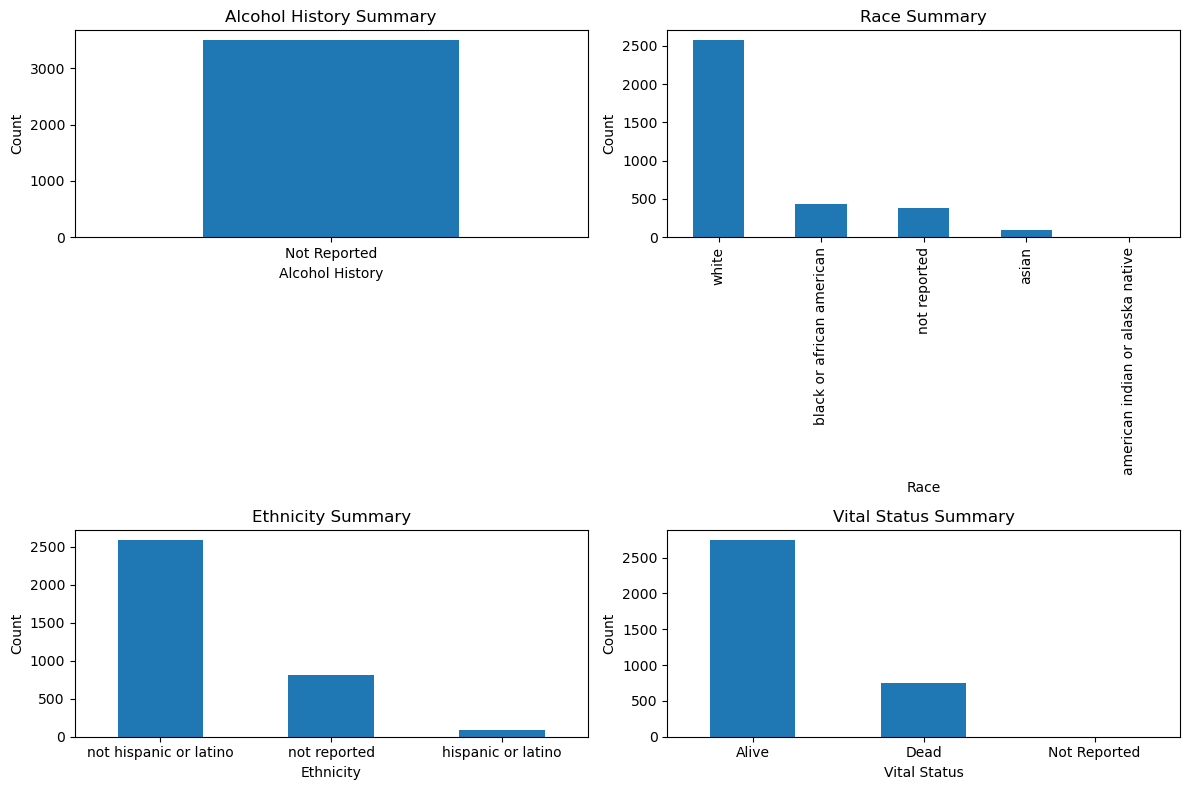

In [13]:
alcohol_history_summary = metadata['alcohol_history'].value_counts()
race_summary = metadata['race'].value_counts()
ethnicity_summary = metadata['ethnicity'].value_counts()
vital_status_summary = metadata['vital_status'].value_counts()
print("Alcohol History Summary:")
print(alcohol_history_summary)
print("\nRace Summary:")
print(race_summary)
print("\nEthnicity Summary:")
print(ethnicity_summary)
print("\nVital Status Summary:")
print(vital_status_summary)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

alcohol_history_summary.plot.bar(ax=axes[0, 0], title='Alcohol History Summary')
axes[0, 0].set_xlabel('Alcohol History')
axes[0, 0].set_ylabel('Count')
axes[0, 0].set_xticklabels(axes[0, 0].get_xticklabels(), rotation=0)

race_summary.plot.bar(ax=axes[0, 1], title='Race Summary')
axes[0, 1].set_xlabel('Race')
axes[0, 1].set_ylabel('Count')

ethnicity_summary.plot.bar(ax=axes[1, 0], title='Ethnicity Summary')
axes[1, 0].set_xlabel('Ethnicity')
axes[1, 0].set_ylabel('Count')
axes[1, 0].set_xticklabels(axes[1, 0].get_xticklabels(), rotation=0)

vital_status_summary.plot.bar(ax=axes[1, 1], title='Vital Status Summary')
axes[1, 1].set_xlabel('Vital Status')
axes[1, 1].set_ylabel('Count')
axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), rotation=0)

plt.tight_layout()
plt.show()

### Data Cleaning

In [14]:
genes_nonAllZero = genes.loc[:,~genes.isin([0]).all(axis=0)]
genes_log = np.log10(genes_nonAllZero.iloc[:,1:] + 1)
genes_log['barcode'] = genes['barcode']
genes_log.head()

ENSG00000000003  ENSG00000000005  ENSG00000000419  ENSG00000000457  \
0         4.935737         3.992290         5.825099         4.919222   
1         5.277878         2.686210         5.819318         4.741602   
2         5.687677         3.642274         6.006792         4.939570   
3         5.521861         3.143908         5.749082         4.881401   
4         5.263735         4.823687         5.690575         5.175563   

   ENSG00000000460  ENSG00000000938  ENSG00000000971  ENSG00000001036  \
0         4.545544         4.322470         5.091352         5.461880   
1         4.564587         4.881516         5.089705         5.545751   
2         4.820214         4.505103         4.724945         5.557468   
3         4.461171         4.307924         5.028087         5.635134   
4         4.739360         4.337012         5.255729         5.372380   

   ENSG00000001084  ENSG00000001167  ...  ENSG00000281883  ENSG00000281887  \
0         5.255124         5.614175  ...         3.008308              0.0   
1         4.977317         5.597933  ...         2.164664              0.0   
2         4.920567         5.672707  ...         2.794728              0.0   
3         5.016741         5.590406  ...         2.496411              0.0   
4         4.963179         5.323870  ...         0.000000              0.0   

   ENSG00000281896  ENSG00000281903  ENSG00000281904  ENSG00000281909  \
0         5.161470         3.621638              0.0         2.603909   
1         4.895737         2.158570              0.0         0.000000   
2         4.024672         3.288720              0.0         0.000000   
3         4.661393         3.650353              0.0         2.868708   
4         4.858096         2.937608              0.0         2.964628   

   ENSG00000281910  ENSG00000281912  ENSG00000281920  \
0         3.349723         4.204342         3.088971   
1         0.000000         4.467595         3.497827   
2         0.000000         4.188538         3.653014   
3         0.000000         4.222962         2.877365   
4         0.000000         4.595941         3.274086   

                        barcode  
0  TCGA-A2-A1FW-01A-11R-A13Q-07  
1  TCGA-AO-A0J4-01A-11R-A034-07  
2  TCGA-AN-A04C-01A-21R-A034-07  
3  TCGA-EW-A1P6-01A-11R-A144-07  
4  TCGA-AC-A4ZE-01A-11R-A41B-07  

[5 rows x 55147 columns]

In [15]:
genes.shape

(3499, 56449)

In [16]:
genes_merged = pd.merge(left=metadata, right=genes_log, how='left', left_on='barcode', right_on='barcode')
genes_merged

barcode shortLetterCode   tumor_stage  \
0     TCGA-A2-A1FW-01A-11R-A13Q-07              TP    stage iiia   
1     TCGA-AO-A0J4-01A-11R-A034-07              TP      stage ia   
2     TCGA-AN-A04C-01A-21R-A034-07              TP     stage iib   
3     TCGA-EW-A1P6-01A-11R-A144-07              TP     stage iib   
4     TCGA-AC-A4ZE-01A-11R-A41B-07              TP     stage iib   
...                            ...             ...           ...   
3494  TCGA-ZG-A9N3-01A-11R-A41O-07              TP  not reported   
3495  TCGA-M7-A720-01A-12R-A32O-07              TP  not reported   
3496  TCGA-VP-A87B-01A-11R-A352-07              TP  not reported   
3497  TCGA-KK-A7B0-01A-11R-A32O-07              TP  not reported   
3498  TCGA-HC-7080-01A-11R-1965-07              TP  not reported   

      age_at_diagnosis  year_of_diagnosis alcohol_history  \
0              22779.0             2010.0    Not Reported   
1              15052.0             2009.0    Not Reported   
2              18851.0             2008.0    Not Reported   
3              23485.0             2010.0    Not Reported   
4              23284.0             2012.0    Not Reported   
...                ...                ...             ...   
3494           26902.0             2013.0    Not Reported   
3495           19642.0             2013.0    Not Reported   
3496           23271.0             2007.0    Not Reported   
3497           24756.0             2011.0    Not Reported   
3498           24243.0             2010.0    Not Reported   

                           race               ethnicity  gender vital_status  \
0                         white  not hispanic or latino  female        Alive   
1     black or african american  not hispanic or latino  female        Alive   
2                         white  not hispanic or latino  female        Alive   
3                         white      hispanic or latino  female        Alive   
4                         white  not hispanic or latino  female        Alive   
...                         ...                     ...     ...          ...   
3494                      white  not hispanic or latino    male        Alive   
3495                      white  not hispanic or latino    male        Alive   
3496                      white            not reported    male        Alive   
3497                      white            not reported    male        Alive   
3498                      white  not hispanic or latino    male        Alive   

      ...  ENSG00000281880  ENSG00000281883  ENSG00000281887 ENSG00000281896  \
0     ...         0.000000         3.008308              0.0        5.161470   
1     ...         3.566361         2.164664              0.0        4.895737   
2     ...         0.000000         2.794728              0.0        4.024672   
3     ...         0.000000         2.496411              0.0        4.661393   
4     ...         0.000000         0.000000              0.0        4.858096   
...   ...              ...              ...              ...             ...   
3494  ...         0.000000         0.000000              0.0        4.508929   
3495  ...         0.000000         2.824760              0.0        4.549572   
3496  ...         0.000000         2.520409              0.0        4.946983   
3497  ...         0.000000         0.000000              0.0        3.631337   
3498  ...         1.977629         2.669770              0.0        4.358097   

      ENSG00000281903  ENSG00000281904  ENSG00000281909  ENSG00000281910  \
0            3.621638              0.0         2.603909         3.349723   
1            2.158570              0.0         0.000000         0.000000   
2            3.288720              0.0         0.000000         0.000000   
3            3.650353              0.0         2.868708         0.000000   
4            2.937608              0.0         2.964628         0.000000   
...               ...              ...              ...              ...   
3494         2.971612  

In [17]:
data_rename = genes_merged.drop(genes_merged.iloc[:, 1:15], axis=1)
data_rename

barcode  ENSG00000000003  ENSG00000000005  \
0     TCGA-A2-A1FW-01A-11R-A13Q-07         4.935737         3.992290   
1     TCGA-AO-A0J4-01A-11R-A034-07         5.277878         2.686210   
2     TCGA-AN-A04C-01A-21R-A034-07         5.687677         3.642274   
3     TCGA-EW-A1P6-01A-11R-A144-07         5.521861         3.143908   
4     TCGA-AC-A4ZE-01A-11R-A41B-07         5.263735         4.823687   
...                            ...              ...              ...   
3494  TCGA-ZG-A9N3-01A-11R-A41O-07         5.657310         0.000000   
3495  TCGA-M7-A720-01A-12R-A32O-07         5.593474         4.517365   
3496  TCGA-VP-A87B-01A-11R-A352-07         5.439523         2.566788   
3497  TCGA-KK-A7B0-01A-11R-A32O-07         5.446207         2.573248   
3498  TCGA-HC-7080-01A-11R-1965-07         5.448397         2.840918   

      ENSG00000000419  ENSG00000000457  ENSG00000000460  ENSG00000000938  \
0            5.825099         4.919222         4.545544         4.322470   
1            5.819318         4.741602         4.564587         4.881516   
2            6.006792         4.939570         4.820214         4.505103   
3            5.749082         4.881401         4.461171         4.307924   
4            5.690575         5.175563         4.739360         4.337012   
...               ...              ...              ...              ...   
3494         6.015006         4.727307         4.700388         4.185828   
3495         5.703595         4.832962         4.190086         4.287406   
3496         5.586151         4.512162         4.022026         4.419142   
3497         5.669871         4.664599         4.048518         4.812120   
3498         5.655163         4.464626         3.981100         4.278998   

      ENSG00000000971  ENSG00000001036  ENSG00000001084  ...  ENSG00000281880  \
0            5.091352         5.461880         5.255124  ...         0.000000   
1            5.089705         5.545751         4.977317  ...         3.566361   
2            4.724945         5.557468         4.920567  ...         0.000000   
3            5.028087         5.635134         5.016741  ...         0.000000   
4            5.255729         5.372380         4.963179  ...         0.000000   
...               ...              ...              ...  ...              ...   
3494         4.518402         5.753968         5.029558  ...         0.000000   
3495         4.868418         5.591373         5.360868  ...         0.000000   
3496         4.259507         5.817306         5.248891  ...         0.000000   
3497         4.868461         6.002716         4.993468  ...         0.000000   
3498         3.872680         5.735224         5.212666  ...         1.977629   

      ENSG00000281883  ENSG00000281887  ENSG00000281896  ENSG00000281903  \
0            3.008308              0.0         5.161470         3.621638   
1            2.164664              0.0         4.895737         2.158570   
2            2.794728              0.0         4.024672         3.288720   
3            2.496411              0.0         4.661393         3.650353   
4            0.000000              0.0         4.858096         2.937608   
...               ...              ...              ...              ...   
3494         0.000000              0.0         4.508929         2.971612   
3495         2.824760              0.0         4.549572         2.943407   
3496         2.520409              0.0         4.946983         3.166469   
3497         0.000000              0.0         3.631337         2.221026   
3498         2.669770              0.0         4.358097         3.361862   

      ENSG00000281904  ENSG00000281909  ENSG00000281910  ENSG00000281912  \
0                 0.0         2.603909         3.349723         4.204342   
1                 0.0         0.000000         0.000000         4.467595   
2                 0.0         0.000000         0.000000         4.188538   
3                 0.0         2.868708         0.000000    

In [18]:
genes_merged = pd.merge(left=metadata[['cancer_type', 'barcode']], right=genes_log, how='left', left_on='barcode', right_on='barcode')
data_rename = genes_merged#.drop(genes_merged.iloc[:, 1:15], axis=1)
data_rename.rename(columns={'barcode':'Sample Number', 'cancer_type':'Class'}, inplace=True)


data_count_byClass = data_rename.groupby(['Class'])[['Sample Number']].agg('count')
data_gene_mean_byClass = data_rename.drop(columns=['Sample Number']).groupby(['Class']).agg('mean')
data_gene_std_byClass = data_rename.drop(columns=['Sample Number']).groupby(['Class']).agg(np.std)
data_gene_min_byClass = data_rename.drop(columns=['Sample Number']).groupby(['Class']).agg('min')
data_gene_max_byClass = data_rename.drop(columns=['Sample Number']).groupby(['Class']).agg('max')

In [19]:
# A dataframe for the overall average of each cancer type
print('Dataframe for Averages of Cancer types')
pd.concat([
    data_gene_mean_byClass.loc['BRCA', ].describe(),
    data_gene_mean_byClass.loc['COAD', ].describe(),
    data_gene_mean_byClass.loc['KIRC', ].describe(),
    data_gene_mean_byClass.loc['LUAD', ].describe(),
    data_gene_mean_byClass.loc['PRAD', ].describe()
    ], axis=1
        )

Dataframe for Averages of Cancer types


BRCA          COAD          KIRC          LUAD          PRAD
count  55146.000000  55146.000000  55146.000000  55146.000000  55146.000000
mean       2.369312      2.238742      2.458368      2.417914      2.357221
std        1.989425      2.023104      1.949421      1.988710      2.028068
min        0.000000      0.000000      0.000000      0.000000      0.000000
25%        0.355908      0.256041      0.510932      0.397041      0.284576
50%        2.059921      1.681125      2.222532      2.148512      2.037898
75%        4.217023      4.142771      4.257914      4.270716      4.264728
max        7.614489      7.813875      7.865707      7.999593      7.887684

In [20]:
data_TopVal_genes = data_rename.drop(columns=['Class','Sample Number']).loc[
    :,(data_rename.drop(columns=['Class','Sample Number']) > 4).all(axis=0).values]


data_TopVal_genes['Class'] = data_rename.Class.values
data_TopVal_genes

ENSG00000000419  ENSG00000000457  ENSG00000001036  ENSG00000001167  \
0            5.825099         4.919222         5.461880         5.614175   
1            5.819318         4.741602         5.545751         5.597933   
2            6.006792         4.939570         5.557468         5.672707   
3            5.749082         4.881401         5.635134         5.590406   
4            5.690575         5.175563         5.372380         5.323870   
...               ...              ...              ...              ...   
3494         6.015006         4.727307         5.753968         5.545376   
3495         5.703595         4.832962         5.591373         5.238088   
3496         5.586151         4.512162         5.817306         5.336594   
3497         5.669871         4.664599         6.002716         5.028466   
3498         5.655163         4.464626         5.735224         5.269879   

      ENSG00000001497  ENSG00000001617  ENSG00000001629  ENSG00000001631  \
0            5.224146         5.687099         5.486467         4.919571   
1            5.321863         5.001416         5.570999         5.254807   
2            5.604239         5.488396         5.193268         5.033094   
3            5.334477         5.679145         5.459585         5.210965   
4            5.382398         5.947456         5.360990         5.227820   
...               ...              ...              ...              ...   
3494         5.401670         5.323254         5.806748         5.539241   
3495         5.301082         5.583071         5.030994         5.039892   
3496         5.328083         5.911931         5.295924         5.000956   
3497         5.498595         5.822215         4.725171         4.662028   
3498         5.324065         5.301801         5.085429         5.019372   

      ENSG00000002549  ENSG00000002586  ...  ENSG00000278053  ENSG00000278133  \
0            5.712876         5.545420  ...         4.875612         5.496085   
1            5.964220         5.976057  ...         4.778810         5.080569   
2            5.756807         6.277989  ...         4.999857         5.798257   
3            5.894408         5.927441  ...         4.935567         6.051398   
4            5.695197         5.842145  ...         4.883491         5.512421   
...               ...              ...  ...              ...              ...   
3494         5.592410         6.277068  ...         4.927195         5.380131   
3495         5.569667         6.266595  ...         4.817792         5.542007   
3496         5.550778         6.337847  ...         4.769429         5.310555   
3497         5.540696         6.598468  ...         4.740610         5.645466   
3498         5.519625         6.257584  ...         4.801101         5.644630   

      ENSG00000278311  ENSG00000278540  ENSG00000278845  ENSG00000278970  \
0            5.620157         5.573521         5.526887         5.623184   
1            5.110901         5.097039         5.582277         5.258464   
2            5.134729         5.101954         5.777383         5.264462   
3            5.166155         5.269738         5.838857         5.593686   
4            5.306581         5.076153         5.849715         5.659813   
...               ...              ...              ...              ...   
3494         5.175031         5.434477         5.687319         5.520470   
3495         5.157568         5.479245         5.706062         5.723554   
3496         5.025169         6.107502         5.735503         5.669703   
3497         5.007014         5.581683         5.890400         5.969990   
3498         5.162941         6.033475         5.746342         5.738128   

      ENSG00000280206  ENSG00000280798  ENSG00000281649  Class  
0            4.853576         4.804505         5.743322   BRCA  
1            5.338784         4.941435         5.229689   BRCA  
2            5.241782         4.792103         5.209493   BRCA  
3            5.239058         4.68

In [21]:
del genes, metadata
del genes_merged, data_rename, genes_log
del data_gene_mean_byClass, data_gene_std_byClass, data_gene_min_byClass, data_gene_max_byClass, genes_nonAllZero

## Machine Learning

### Datasets

In [22]:
BRCA_data = data_TopVal_genes[data_TopVal_genes['Class'] == 'BRCA']
COAD_data = data_TopVal_genes[data_TopVal_genes['Class'] == 'COAD']
KIRC_data = data_TopVal_genes[data_TopVal_genes['Class'] == 'KIRC']
LUAD_data = data_TopVal_genes[data_TopVal_genes['Class'] == 'LUAD']
PRAD_data = data_TopVal_genes[data_TopVal_genes['Class'] == 'PRAD']

In [23]:
print(BRCA_data['Class'].value_counts())
print(COAD_data['Class'].value_counts())
print(KIRC_data['Class'].value_counts())
print(LUAD_data['Class'].value_counts())
print(PRAD_data['Class'].value_counts())

Class
BRCA    1222
Name: count, dtype: int64
Class
COAD    521
Name: count, dtype: int64
Class
KIRC    611
Name: count, dtype: int64
Class
LUAD    594
Name: count, dtype: int64
Class
PRAD    551
Name: count, dtype: int64


In [24]:
BCdata = pd.concat([BRCA_data, COAD_data])
BKdata = pd.concat([BRCA_data, KIRC_data])
BLdata = pd.concat([BRCA_data, LUAD_data])
BPdata = pd.concat([BRCA_data, PRAD_data])
CKdata = pd.concat([COAD_data, KIRC_data])
CLdata = pd.concat([COAD_data, LUAD_data])
CPdata = pd.concat([COAD_data, PRAD_data])
KLdata = pd.concat([KIRC_data, LUAD_data])
KPdata = pd.concat([KIRC_data, PRAD_data])
LPdata = pd.concat([LUAD_data, PRAD_data])

BCKdata = pd.concat([BRCA_data, COAD_data, KIRC_data])
BCLdata = pd.concat([BRCA_data, COAD_data, LUAD_data])
BCPdata = pd.concat([BRCA_data, COAD_data, PRAD_data])
BKLdata = pd.concat([BRCA_data, KIRC_data, LUAD_data])
BKPdata = pd.concat([BRCA_data, KIRC_data, PRAD_data])
BLPdata = pd.concat([BRCA_data, LUAD_data, PRAD_data])
CKLdata = pd.concat([COAD_data, KIRC_data, LUAD_data])
CKPdata = pd.concat([COAD_data, KIRC_data, PRAD_data])
CLPdata = pd.concat([COAD_data, LUAD_data, PRAD_data])
KLPdata = pd.concat([KIRC_data, LUAD_data, PRAD_data])

BCKLdata = pd.concat([BRCA_data, COAD_data, KIRC_data, LUAD_data])
BCKPdata = pd.concat([BRCA_data, COAD_data, KIRC_data, PRAD_data])
BCLPdata = pd.concat([BRCA_data, COAD_data, LUAD_data, PRAD_data])
BKLPdata = pd.concat([BRCA_data, KIRC_data, LUAD_data, PRAD_data])
CKLPdata = pd.concat([COAD_data, KIRC_data, LUAD_data, PRAD_data])

In [25]:
BKLdata['Class'].value_counts()

Class
BRCA    1222
KIRC     611
LUAD     594
Name: count, dtype: int64

In [26]:
y = data_TopVal_genes['Class']
X = data_TopVal_genes.drop(columns=['Class'], axis=1 )

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Logistic Regression

First, this is what logistic regression looks like for all 5 classes.

c:\Users\priya\miniconda3\envs\orl\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy:  0.9971428571428571
[[277   0   1   0   0]
 [  0  85   0   1   0]
 [  0   0 122   0   0]
 [  0   0   0 104   0]
 [  0   0   0   0 110]]


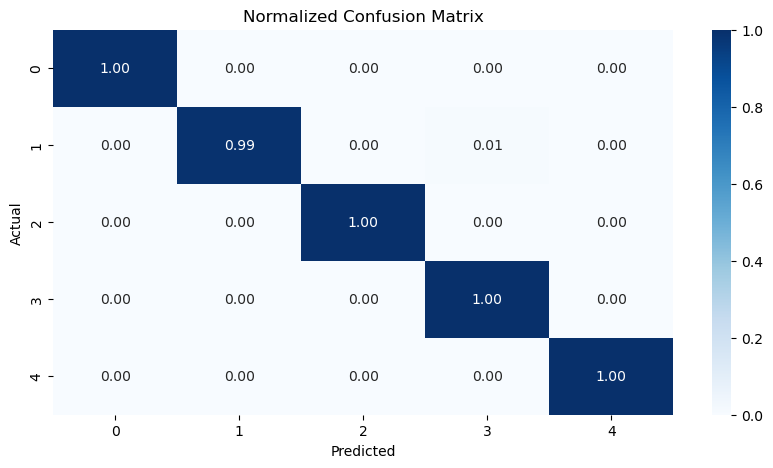

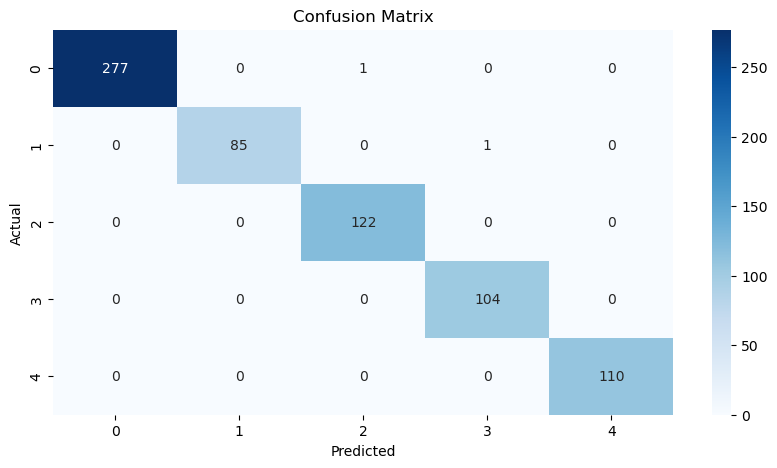

0.9971428571428571

In [27]:
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

logisticRegr = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=100)

logisticRegr.fit(X_train_s, y_train)
predictions = logisticRegr.predict(X_test_s)
score = logisticRegr.score(X_test_s, y_test)
print('Accuracy: ', score)
cm = confusion_matrix(y_test, predictions)
print(cm)
normalized_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10,5))
sns.heatmap(normalized_cm, annot=True, fmt=".2f", cmap="Blues")
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


plt.figure(figsize=(10,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

score

<Axes: ylabel='Feature'>

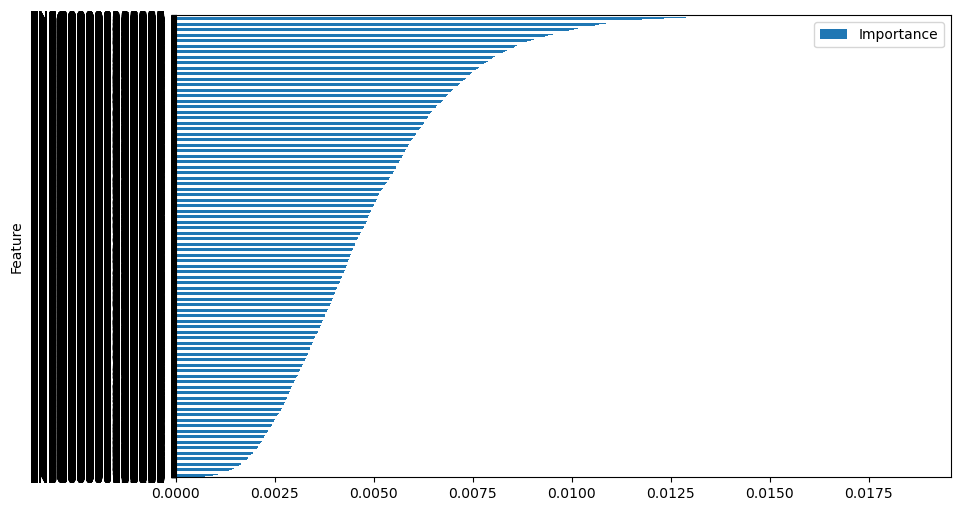

In [28]:
coefficients = logisticRegr.coef_
avg_importance = np.mean(np.abs(coefficients), axis=0)
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': avg_importance})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

In [29]:
feature_importance[:1]

Feature  Importance
2460  ENSG00000127993    0.000407

<Axes: ylabel='Feature'>

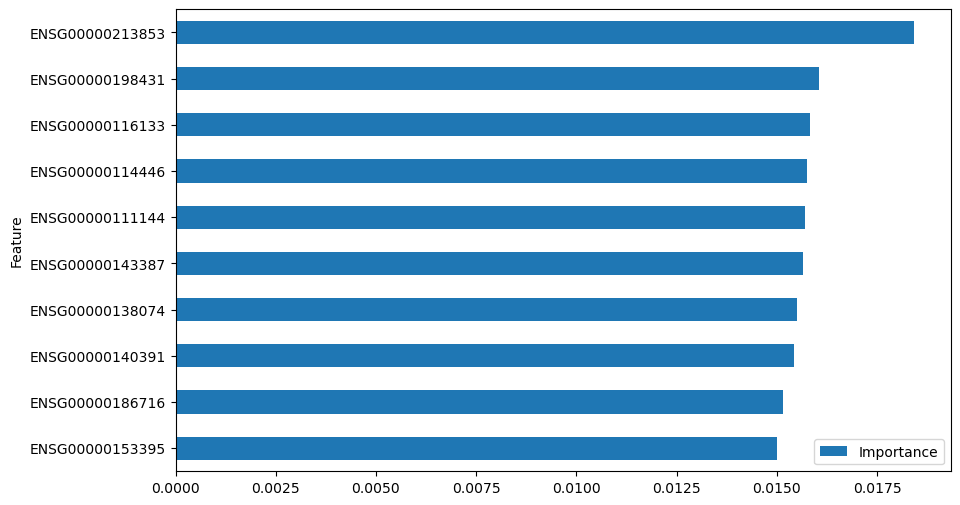

In [30]:
feature_importance[-11:-1].plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

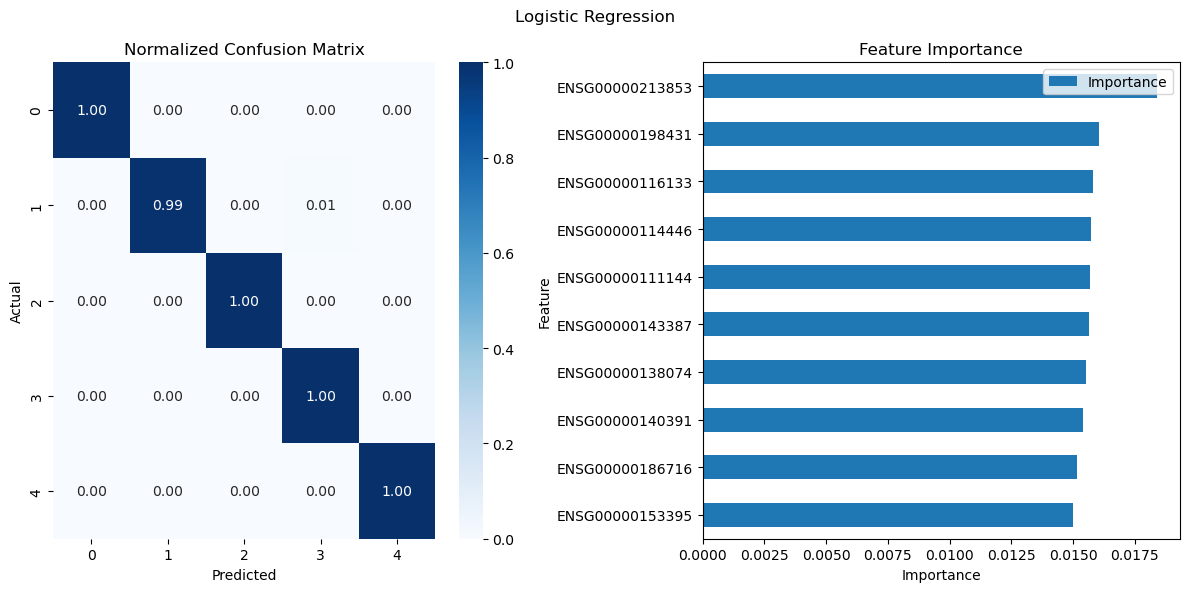

In [31]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

sns.heatmap(normalized_cm, annot=True, fmt=".2f", cmap="Blues", ax=axes[0])
axes[0].set_title('Normalized Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

feature_importance[-11:-1].plot(x='Feature', y='Importance', kind='barh', ax=axes[1])
axes[1].set_title('Feature Importance')
axes[1].set_xlabel('Importance')
axes[1].set_ylabel('Feature')

plt.suptitle('Logistic Regression')
plt.tight_layout()
plt.show()

Next is for 4 classes:

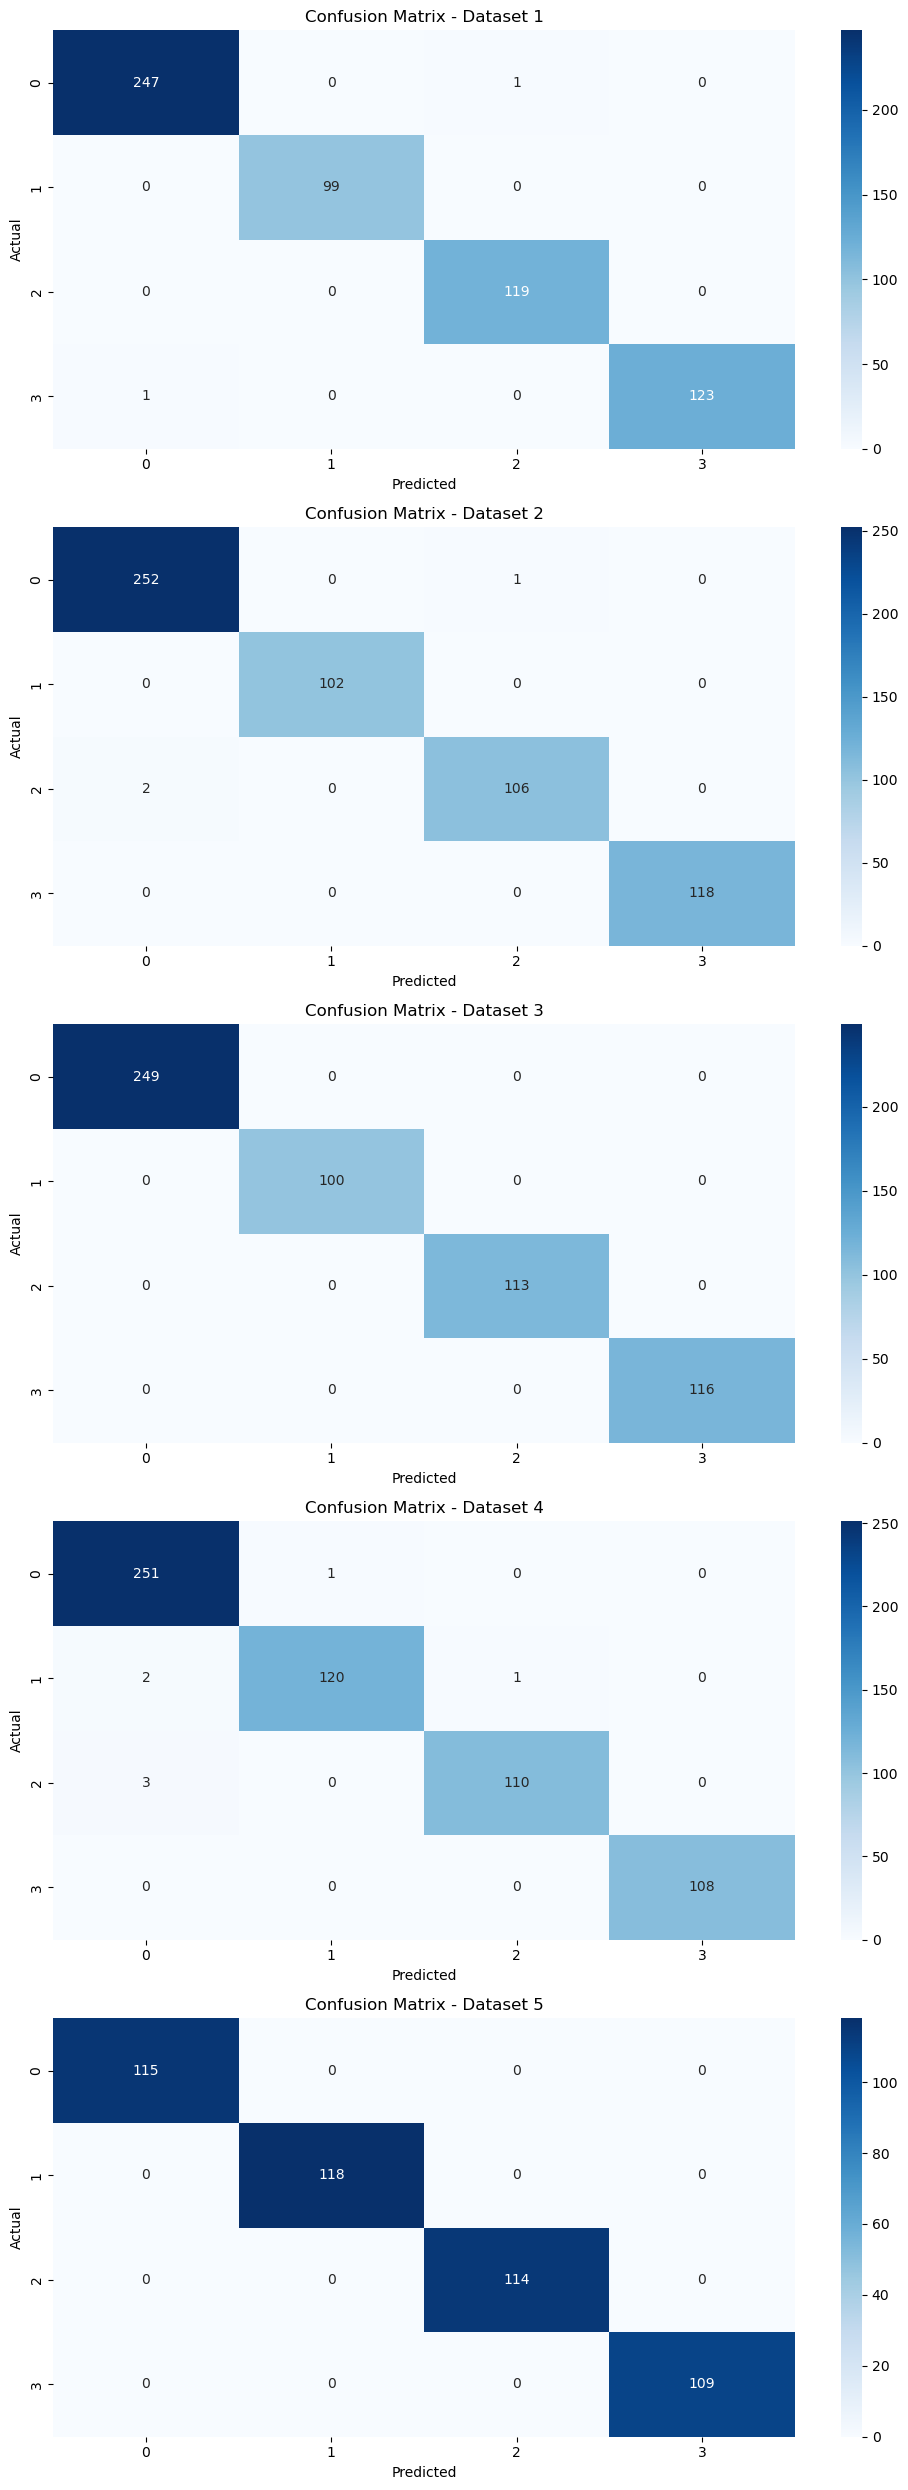

0.9959403383721931

In [32]:
datasets = [BCKLdata, BCKPdata, BCLPdata, BKLPdata, CKLPdata]
scores = []

fig, axes = plt.subplots(nrows=len(datasets), ncols=1, figsize=(10, 5*len(datasets)))
for i, dataset in enumerate(datasets):
    X_4class = dataset.drop(columns=['Class'])
    y_4class = dataset['Class']
    X_train_4class, X_test_4class, y_train_4class, y_test_4class = train_test_split(X_4class, y_4class, test_size=0.2, random_state=42)
    scaler_4class = StandardScaler()
    X_train_4class = scaler_4class.fit_transform(X_train_4class)
    X_test_4class = scaler_4class.transform(X_test_4class)
    logisticRegr_4class = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000)
    logisticRegr_4class.fit(X_train_4class, y_train_4class)
    predictions_4class = logisticRegr_4class.predict(X_test_4class)
    
    cm_4class = confusion_matrix(y_test_4class, predictions_4class)
    sns.heatmap(cm_4class, annot=True, fmt="d", cmap="Blues", ax=axes[i])
    axes[i].set_title(f"Confusion Matrix - Dataset {i+1}")
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

    score = logisticRegr_4class.score(X_test_4class, y_test_4class)
    scores.append(score)

plt.tight_layout()
plt.show()


average_score = sum(scores) / len(scores)
average_score

Next is for 3 classes:

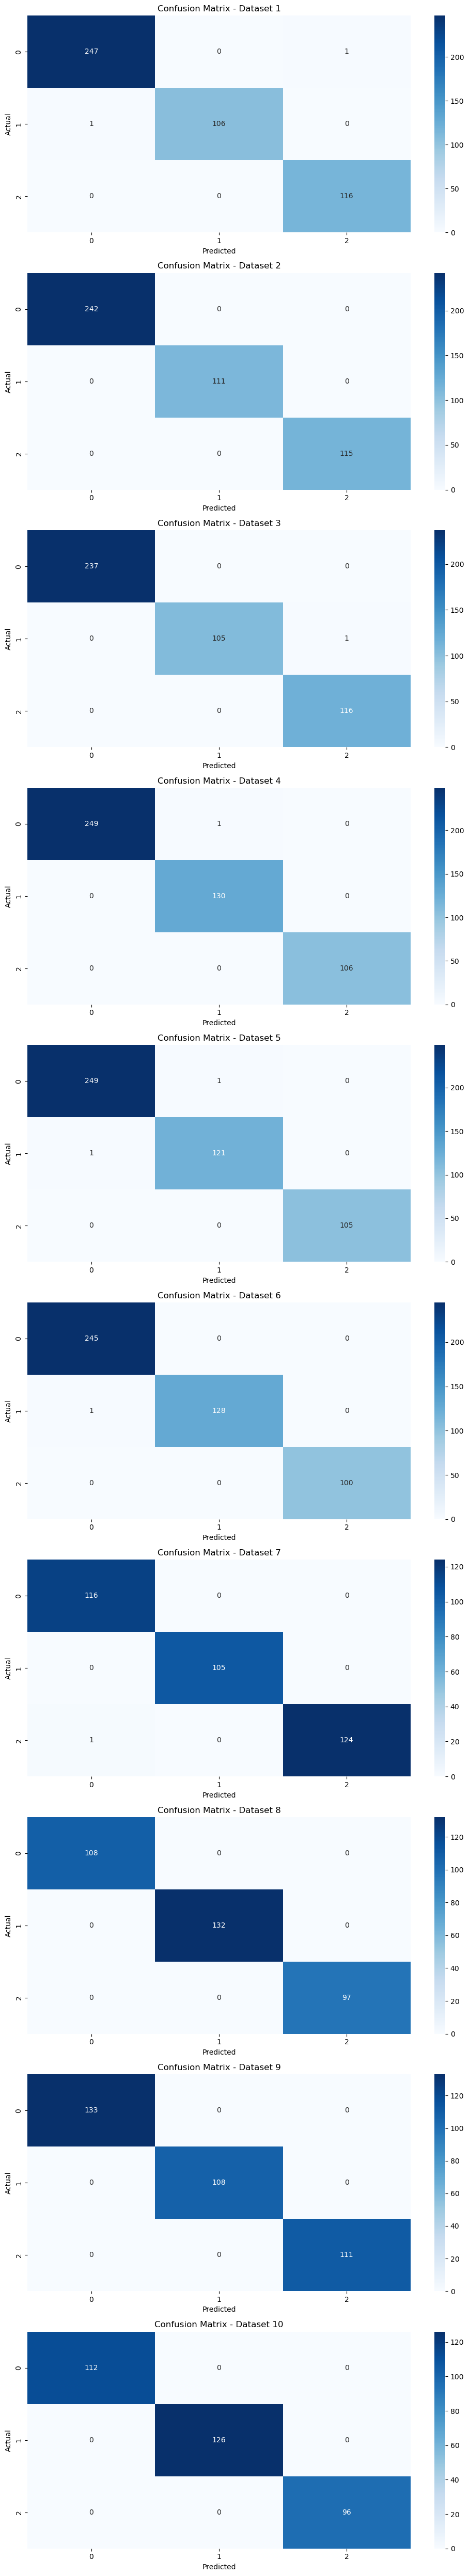

Average Score: 0.9982324702923584


In [33]:
datasets = [BCKdata, BCLdata, BCPdata, BKLdata, BKPdata, BLPdata, CKLdata, CKPdata, KLPdata, CLPdata]

scores = []

fig, axes = plt.subplots(nrows=len(datasets), ncols=1, figsize=(10, 5*len(datasets)))

for i, dataset in enumerate(datasets):
    X_3class = dataset.drop(columns=['Class'])
    y_3class = dataset['Class']
    X_train_3class, X_test_3class, y_train_3class, y_test_3class = train_test_split(X_3class, y_3class, test_size=0.2, random_state=42)
    scaler_3class = StandardScaler()
    X_train_3class = scaler_3class.fit_transform(X_train_3class)
    X_test_3class = scaler_3class.transform(X_test_3class)
    logisticRegr_3class = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000)
    logisticRegr_3class.fit(X_train_3class, y_train_3class)
    predictions_3class = logisticRegr_3class.predict(X_test_3class)
    
    cm_3class = confusion_matrix(y_test_3class, predictions_3class)
    sns.heatmap(cm_3class, annot=True, fmt="d", cmap="Blues", ax=axes[i])
    axes[i].set_title(f"Confusion Matrix - Dataset {i+1}")
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')
    
    score = logisticRegr_3class.score(X_test_3class, y_test_3class)
    scores.append(score)

plt.tight_layout()
plt.show()

average_score = sum(scores) / len(scores)
print("Average Score:", average_score)

Next is for 2 classes:

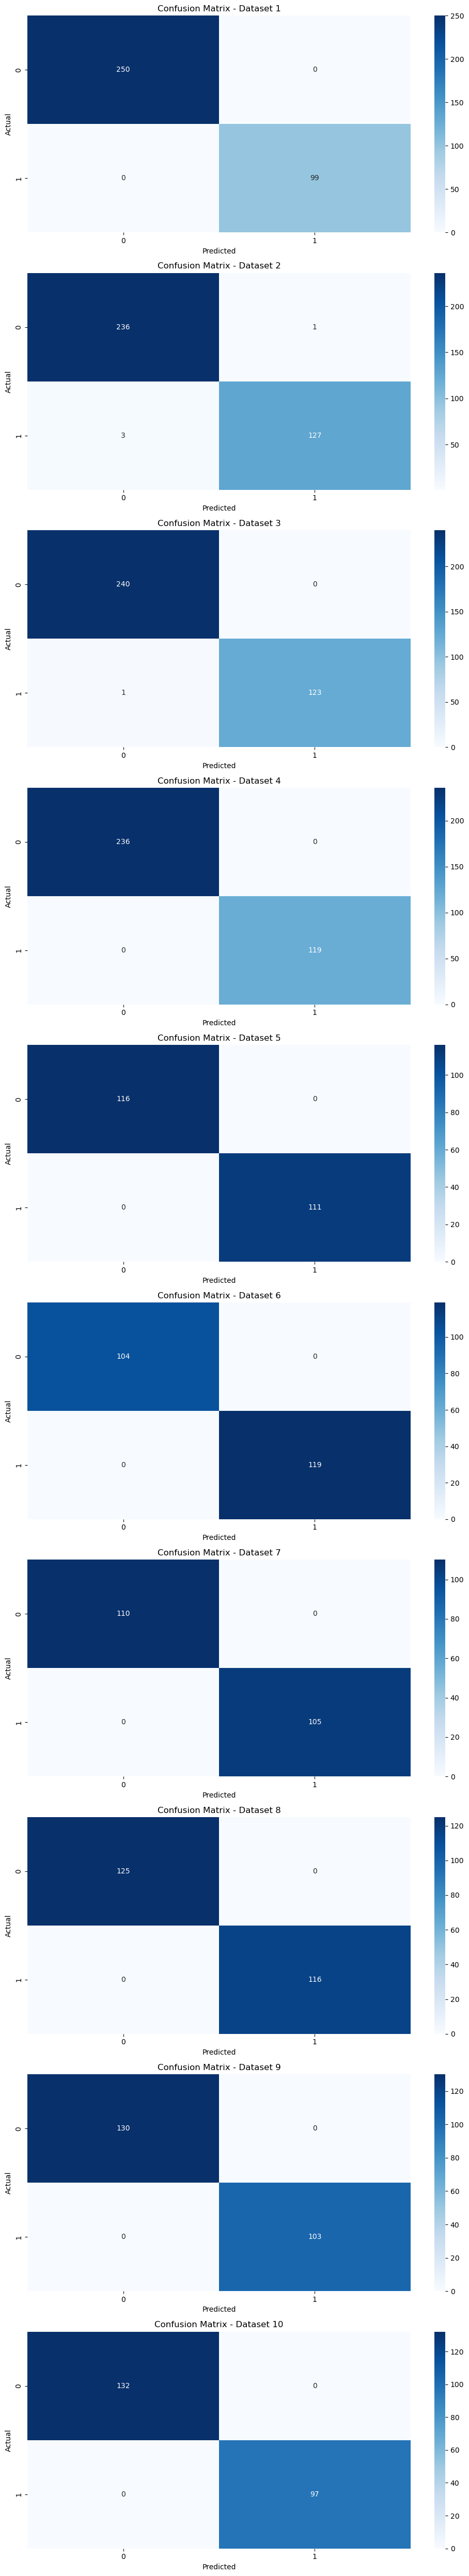

Average Score: 0.9986353564691439


In [34]:
datasets = [BCdata, BKdata, BLdata, BPdata, CKdata, CLdata, CPdata, KLdata, KPdata, LPdata]

scores = []

fig, axes = plt.subplots(nrows=len(datasets), ncols=1, figsize=(10, 5*len(datasets)))
for i, dataset in enumerate(datasets):
    X_2class = dataset.drop(columns=['Class'])
    y_2class = dataset['Class']
    X_train_2class, X_test_2class, y_train_2class, y_test_2class = train_test_split(X_2class, y_2class, test_size=0.2, random_state=42)
    scaler_2class = StandardScaler()
    X_train_2class = scaler_2class.fit_transform(X_train_2class)
    X_test_2class = scaler_2class.transform(X_test_2class)
    logisticRegr_2class = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000)
    logisticRegr_2class.fit(X_train_2class, y_train_2class)
    predictions_2class = logisticRegr_2class.predict(X_test_2class)
    
    cm_2class = confusion_matrix(y_test_2class, predictions_2class)
    sns.heatmap(cm_2class, annot=True, fmt="d", cmap="Blues", ax=axes[i])
    axes[i].set_title(f"Confusion Matrix - Dataset {i+1}")
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')
    score = logisticRegr_2class.score(X_test_2class, y_test_2class)
    scores.append(score)

plt.tight_layout()
plt.show()

average_score = sum(scores) / len(scores)
print("Average Score:", average_score)

### Support Vector Machines

In [35]:
# Select the top N features
k_best = SelectKBest(score_func=f_classif, k=100)
X_train_svm = k_best.fit_transform(X_train, y_train)
X_test_svm = k_best.transform(X_test)

y_train_svm = y_train
y_test_svm = y_test

scaler = StandardScaler()
X_train_svm = scaler.fit_transform(X_train_svm)
X_test_svm = scaler.transform(X_test_svm)

In [36]:
svm_classifier = SVC(kernel='linear', C=1, decision_function_shape='ovr', random_state=42)
svm_classifier.fit(X_train_svm, y_train_svm)

SVC(C=1, kernel='linear', random_state=42)

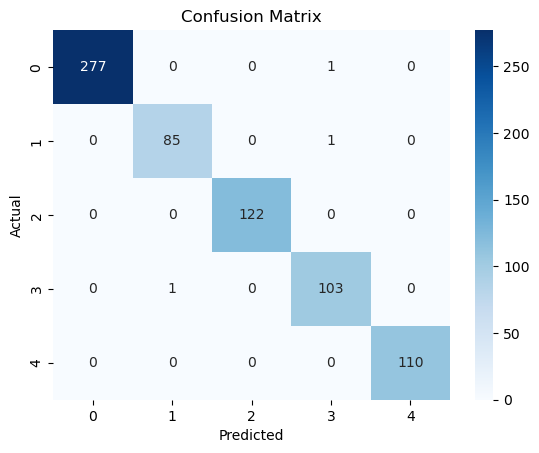

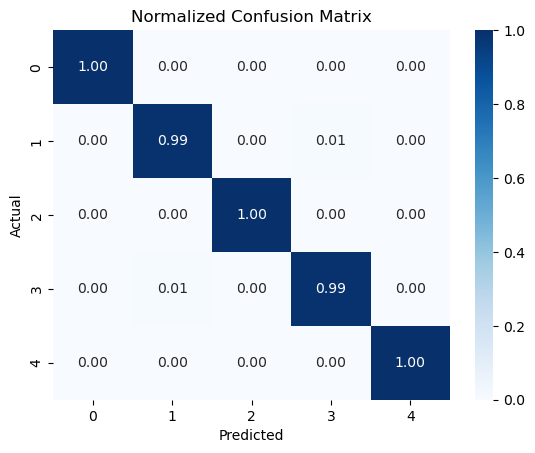

Accuracy: 0.9957142857142857
Confusion Matrix:
[[277   0   0   1   0]
 [  0  85   0   1   0]
 [  0   0 122   0   0]
 [  0   1   0 103   0]
 [  0   0   0   0 110]]
Classification Report:
              precision    recall  f1-score   support

        BRCA       1.00      1.00      1.00       278
        COAD       0.99      0.99      0.99        86
        KIRC       1.00      1.00      1.00       122
        LUAD       0.98      0.99      0.99       104
        PRAD       1.00      1.00      1.00       110

    accuracy                           1.00       700
   macro avg       0.99      1.00      0.99       700
weighted avg       1.00      1.00      1.00       700



In [37]:
y_pred_svm = svm_classifier.predict(X_test_svm)

accuracy_svm = accuracy_score(y_test_svm, y_pred_svm)
conf_matrix_svm = confusion_matrix(y_test_svm, y_pred_svm)
class_report_svm = classification_report(y_test_svm, y_pred_svm)

sns.heatmap(conf_matrix_svm, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


normalized_conf_matrix_svm = conf_matrix_svm.astype('float') / conf_matrix_svm.sum(axis=1)[:, np.newaxis]
sns.heatmap(normalized_conf_matrix_svm, annot=True, fmt=".2f", cmap="Blues")
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


print(f'Accuracy: {accuracy_svm}')
print(f'Confusion Matrix:\n{conf_matrix_svm}')
print(f'Classification Report:\n{class_report_svm}')

In [38]:
param_grid_svm = {'C': [0.1, 1, 10],
              'kernel': ['linear', 'rbf', 'poly']}

grid_search_svm = GridSearchCV(SVC(decision_function_shape='ovr', random_state=42),
                           param_grid=param_grid_svm,
                           cv=5)

grid_search_svm.fit(X_train_svm, y_train_svm)

best_params_svm = grid_search_svm.best_params_
best_estimator_svm = grid_search_svm.best_estimator_

print(f'Best Parameters: {best_params_svm}')
print(f'Best Estimator: {best_estimator_svm}')

Best Parameters: {'C': 0.1, 'kernel': 'linear'}
Best Estimator: SVC(C=0.1, kernel='linear', random_state=42)


In [39]:
final_svm_classifier_svm = SVC(kernel=best_params_svm['kernel'], C=best_params_svm['C'], decision_function_shape='ovr', random_state=42)
final_svm_classifier_svm.fit(X_train_svm, y_train_svm)

final_predictions_svm = final_svm_classifier_svm.predict(X_test_svm)

In [40]:
print(np.array(y_test_svm)[final_predictions_svm != np.array(y_test_svm)])
print(np.array(final_predictions_svm)[final_predictions_svm != np.array(y_test_svm)])

['LUAD' 'BRCA' 'COAD']
['COAD' 'LUAD' 'LUAD']


Accuracy: 0.9957142857142857


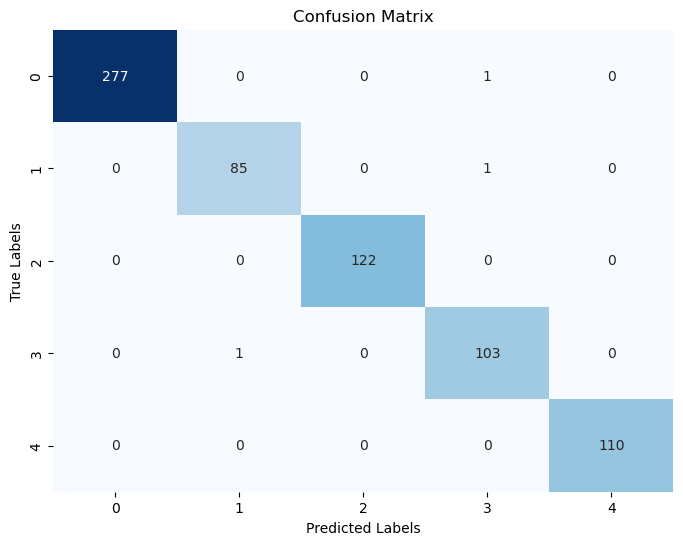

In [41]:
# Compute confusion matrix
cm_svm = confusion_matrix(y_test_svm, final_predictions_svm)

# Accuracy score
accuracy_svm = accuracy_score(y_test_svm, final_predictions_svm)
print(f'Accuracy: {accuracy_svm}')

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

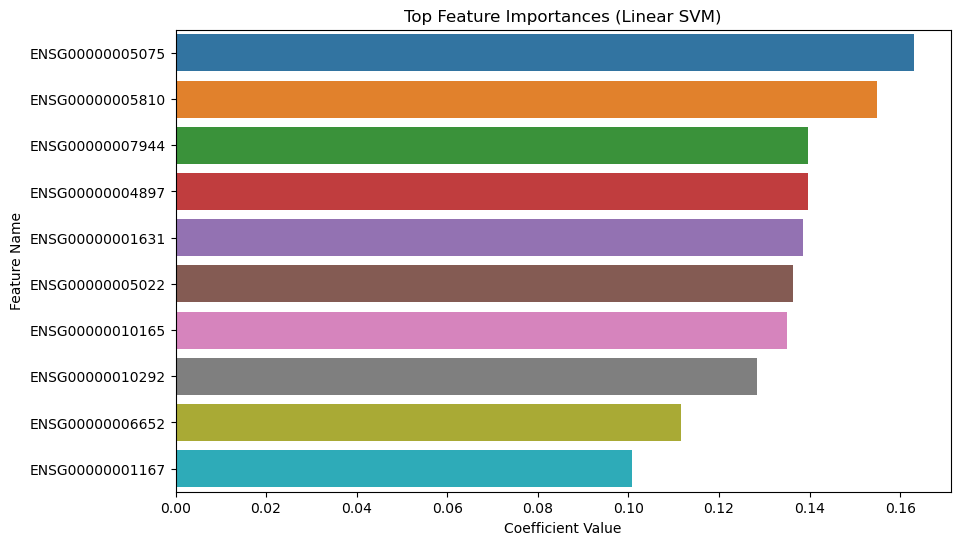

In [42]:
# Assuming a linear kernel SVM
if best_params_svm['kernel'] == 'linear':
    coef_svm = final_svm_classifier_svm.coef_[0]
    feature_names_svm = X.columns

    # Sort features by their absolute coefficients
    feature_importance_svm = sorted(zip(coef_svm, feature_names_svm), key=lambda x: abs(x[0]), reverse=True)

    # Plot top N important features
    top_n_svm = 10  # Replace with the number of top features to visualize
    top_features_svm = [f[1] for f in feature_importance_svm[:top_n_svm]]
    top_coeffs_svm =  [(abs(f[0])) for f in feature_importance_svm[:top_n_svm]]

    plt.figure(figsize=(10, 6))
    sns.barplot(x=top_coeffs_svm, y=top_features_svm)
    plt.xlabel('Coefficient Value')
    plt.ylabel('Feature Name')
    plt.title('Top Feature Importances (Linear SVM)')
    plt.show()

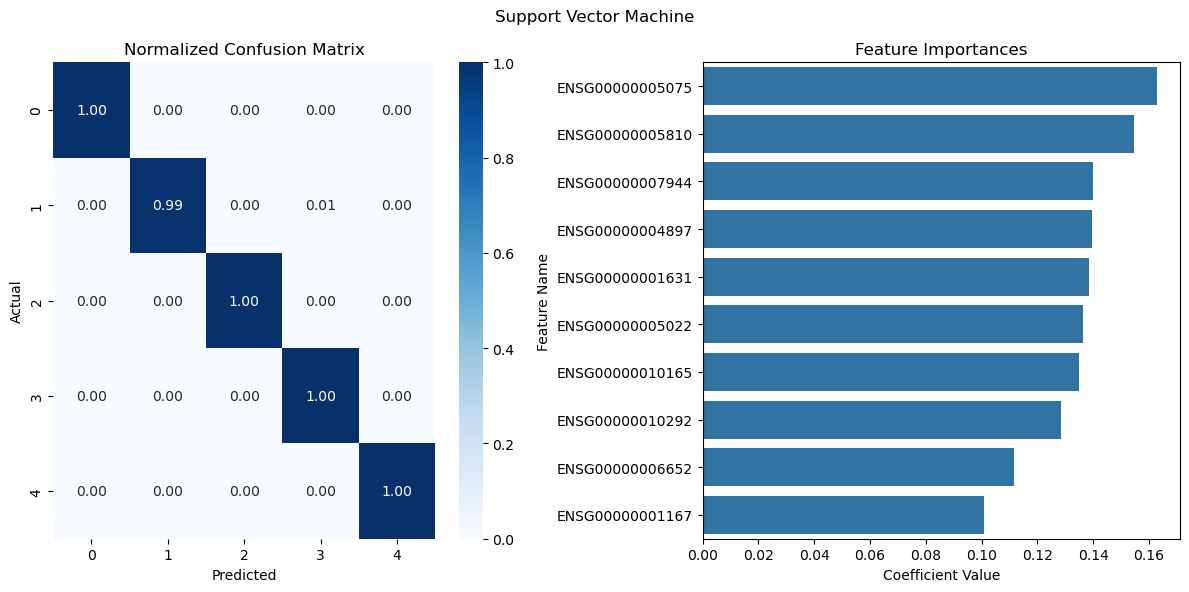

In [43]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

coef_svm = final_svm_classifier_svm.coef_[0]
avg_importance = np.mean(np.abs(coefficients), axis=0)
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': avg_importance})
feature_importance = feature_importance.sort_values('Importance', ascending=True)

sns.heatmap(normalized_cm, annot=True, fmt=".2f", cmap="Blues", ax=axes[0])
axes[0].set_title('Normalized Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

top_n_svm = 10  # Replace with the number of top features to visualize
top_features_svm = [f[1] for f in feature_importance_svm[:top_n_svm]]
top_coeffs_svm =  [(abs(f[0])) for f in feature_importance_svm[:top_n_svm]]

sns.barplot(x=top_coeffs_svm, y=top_features_svm, color=sns.color_palette()[0])
axes[1].set_title('Feature Importances')
axes[1].set_xlabel('Coefficient Value')
axes[1].set_ylabel('Feature Name')

plt.suptitle('Support Vector Machine')
plt.tight_layout()
plt.show()

### Random Forest

Accuracy: 0.9942857142857143


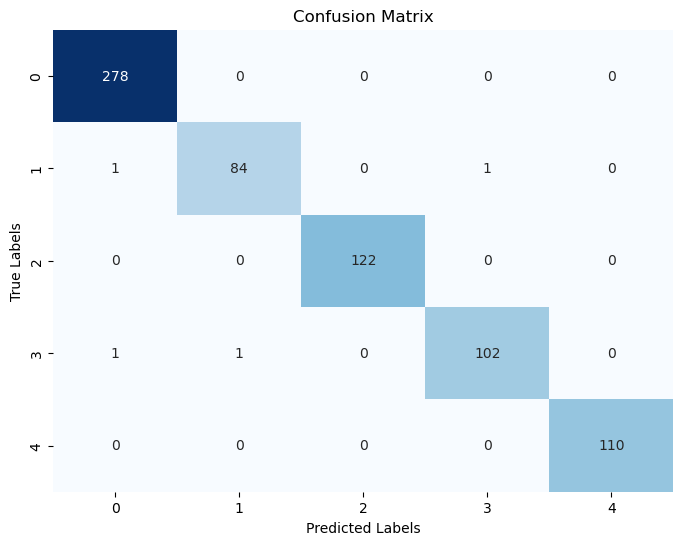

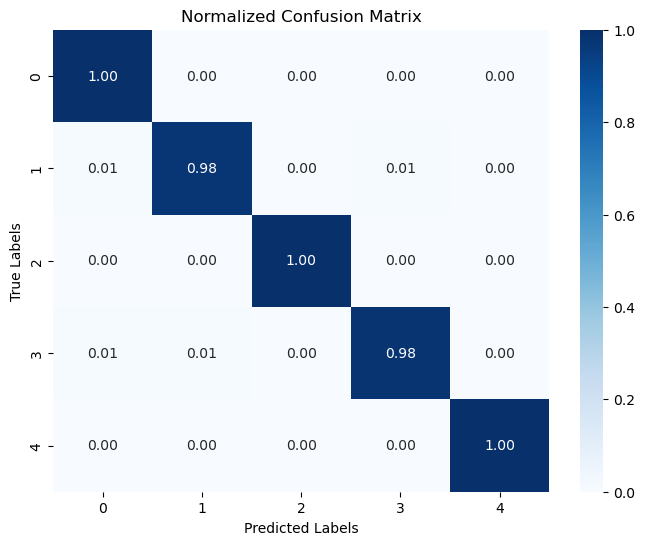

In [44]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

rf_predictions = rf_classifier.predict(X_test)

rf_accuracy = accuracy_score(y_test, rf_predictions)

print(f'Accuracy: {rf_accuracy}')

cm = confusion_matrix(y_test, rf_predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

normalized_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(normalized_cm, annot=True, fmt=".2f", cmap="Blues")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Normalized Confusion Matrix')
plt.show()

In [45]:
print(np.array(y_test)[rf_predictions != np.array(y_test)])
print(np.array(rf_predictions)[rf_predictions != np.array(y_test)])

['LUAD' 'COAD' 'LUAD' 'COAD']
['COAD' 'LUAD' 'BRCA' 'BRCA']


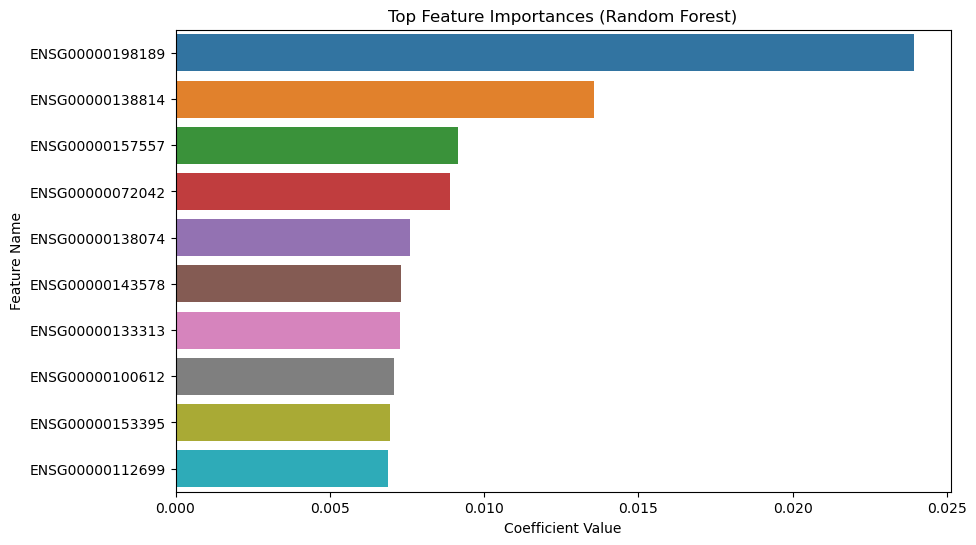

In [46]:
feature_importance = sorted(zip(rf_classifier.feature_importances_, X.columns), reverse=True)

top_n = 10
top_features = [f[1] for f in feature_importance[:top_n]]
top_coeffs = [f[0] for f in feature_importance[:top_n]]

plt.figure(figsize=(10, 6))
sns.barplot(x=top_coeffs, y=top_features)
plt.xlabel('Coefficient Value')
plt.ylabel('Feature Name')
plt.title('Top Feature Importances (Random Forest)')
plt.show()

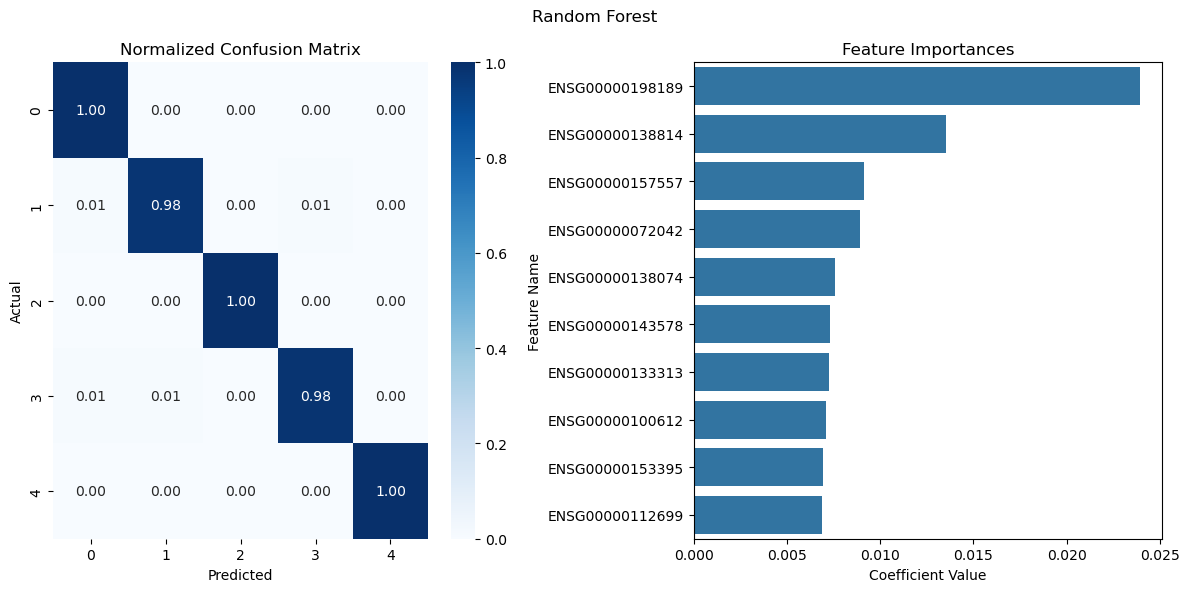

In [47]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

feature_importance = sorted(zip(rf_classifier.feature_importances_, X.columns), reverse=True)

top_n = 10
top_features = [f[1] for f in feature_importance[:top_n]]
top_coeffs = [f[0] for f in feature_importance[:top_n]]


sns.heatmap(normalized_cm, annot=True, fmt=".2f", cmap="Blues", ax=axes[0])
axes[0].set_title('Normalized Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

sns.barplot(x=top_coeffs, y=top_features, color=sns.color_palette()[0])
axes[1].set_title('Feature Importances')
axes[1].set_xlabel('Coefficient Value')
axes[1].set_ylabel('Feature Name')

plt.suptitle('Random Forest')
plt.tight_layout()
plt.show()

### Extra Trees

Accuracy: 0.9914285714285714


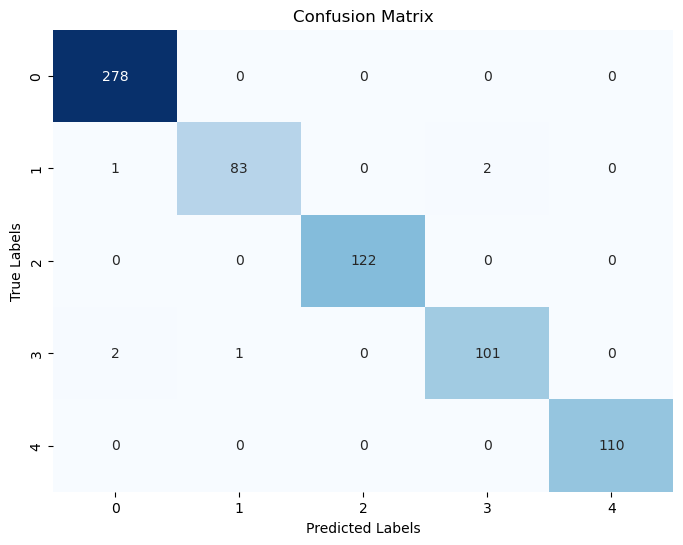

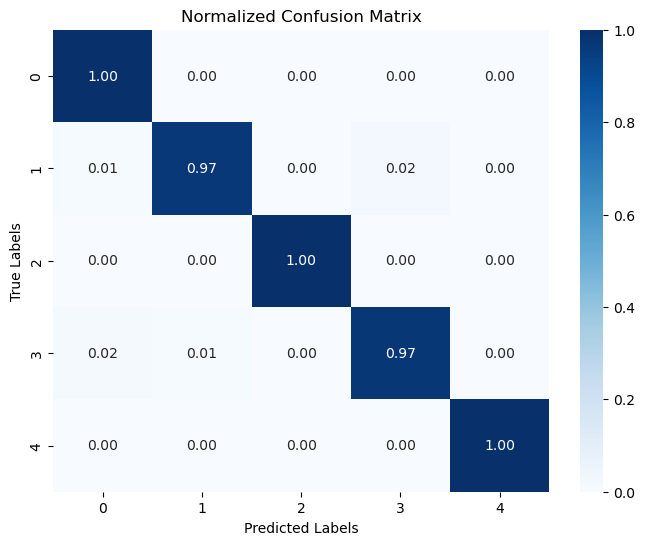

In [48]:
et_classifier = ExtraTreesClassifier(n_estimators=100, random_state=42)
et_classifier.fit(X_train, y_train)

et_predictions = et_classifier.predict(X_test)

et_accuracy = accuracy_score(y_test, et_predictions)

print(f'Accuracy: {et_accuracy}')

# Compute confusion matrix

cm = confusion_matrix(y_test, et_predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Compute normalized confusion matrix
normalized_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot normalized confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(normalized_cm, annot=True, fmt=".2f", cmap="Blues")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Normalized Confusion Matrix')
plt.show()

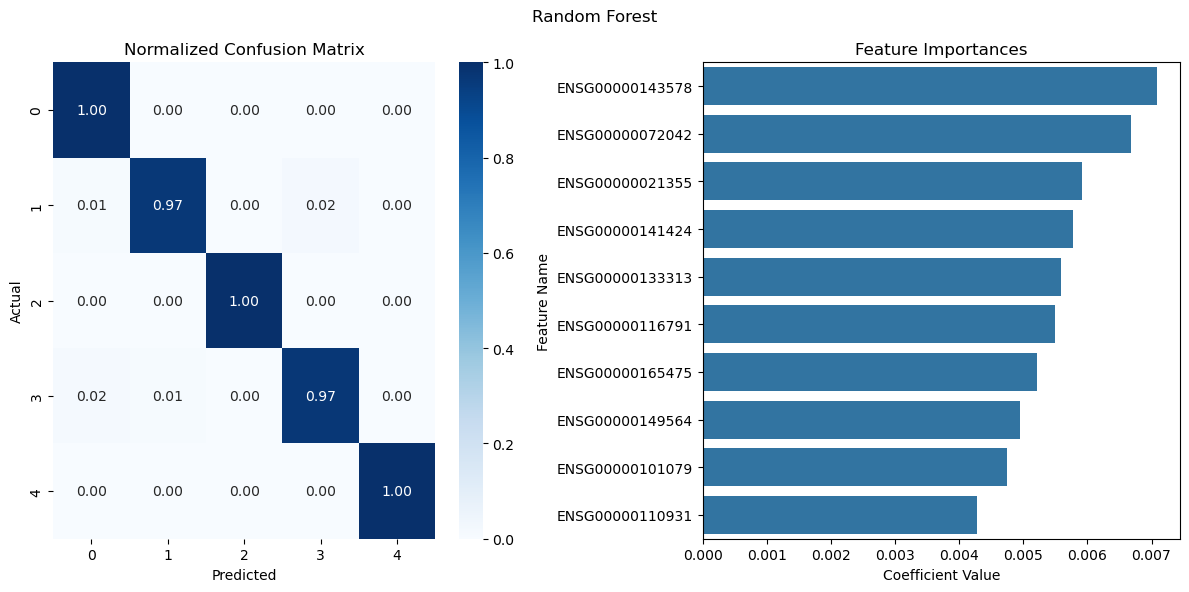

In [49]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

feature_importance = sorted(zip(et_classifier.feature_importances_, X.columns), reverse=True)

top_n = 10
top_features = [f[1] for f in feature_importance[:top_n]]
top_coeffs = [f[0] for f in feature_importance[:top_n]]


sns.heatmap(normalized_cm, annot=True, fmt=".2f", cmap="Blues", ax=axes[0])
axes[0].set_title('Normalized Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

sns.barplot(x=top_coeffs, y=top_features, color=sns.color_palette()[0])
axes[1].set_title('Feature Importances')
axes[1].set_xlabel('Coefficient Value')
axes[1].set_ylabel('Feature Name')

plt.suptitle('Random Forest')
plt.tight_layout()
plt.show()

### PCA

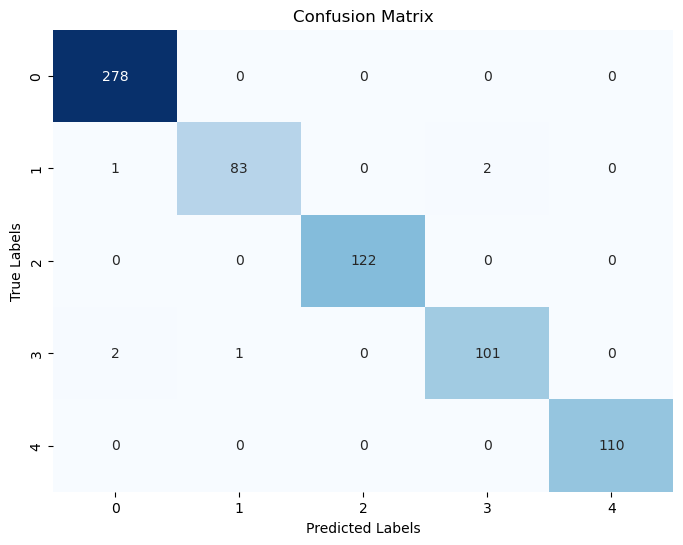

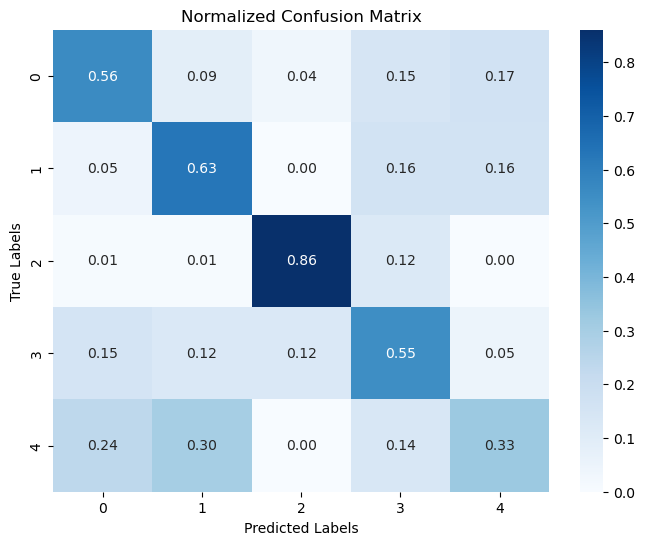

Accuracy: 0.5828571428571429


In [50]:
pca2 = PCA(n_components=2) 
pca_X_train2 = pd.DataFrame(pca2.fit_transform(X_train))
pca_X_test2 = pd.DataFrame(pca2.transform(X_test))

lrpca_cls2 = LogisticRegression(class_weight='balanced')
lrpca_cls2.fit(pca_X_train2, y_train)
lr_pca_pred2 = lrpca_cls2.predict(pca_X_test2)

# Confusion Matrix
cm2 = confusion_matrix(y_test, lr_pca_pred2)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Compute normalized confusion matrix
normalized_cm2 = cm2.astype('float') / cm2.sum(axis=1)[:, np.newaxis]

# Plot normalized confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(normalized_cm2, annot=True, fmt=".2f", cmap="Blues")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Normalized Confusion Matrix')
plt.show()

# Accuracy score
accuracy = accuracy_score(y_test, lr_pca_pred2)
print(f'Accuracy: {accuracy}')

Text(0, 0.5, 'cumulative explained variance')

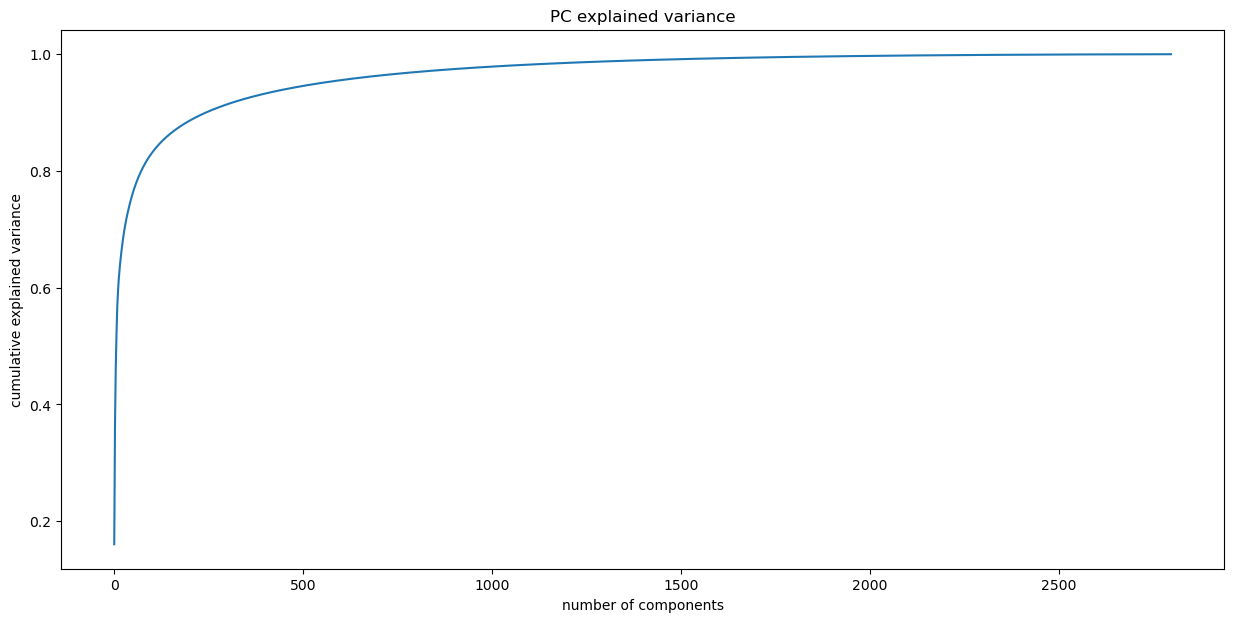

In [51]:
# doing PCA to check how many PCs are good enough to explain variance
pca = PCA().fit(X_train)

# setting figure parameters for size
fig_dims = (15, 7)
fig, ax = plt.subplots(1,1,figsize=fig_dims)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('PC explained variance')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

c:\Users\priya\miniconda3\envs\orl\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


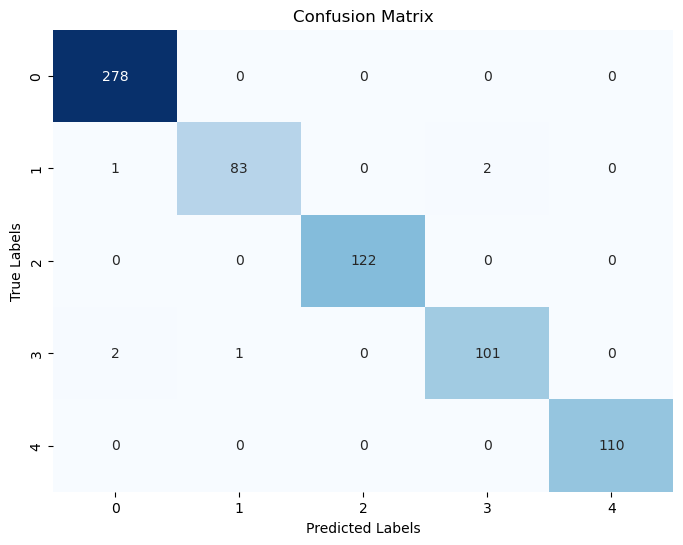

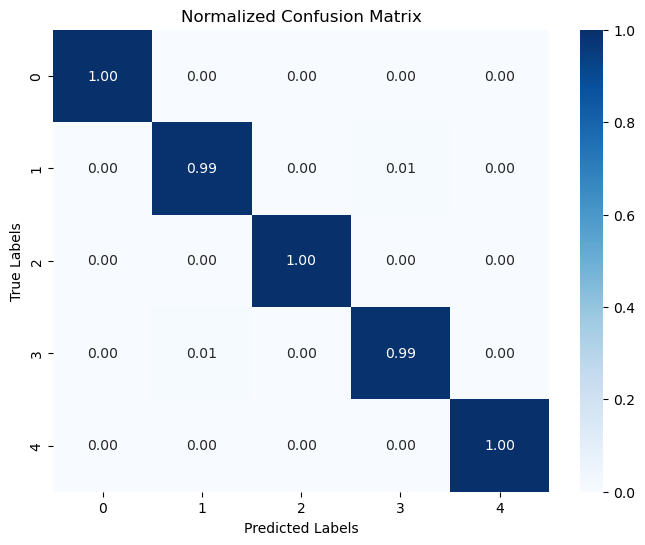

Accuracy: 0.9957142857142857


In [52]:
pca3 = PCA(n_components=5) 
pca_X_train3 = pd.DataFrame(pca.fit_transform(X_train))
pca_X_test3 = pd.DataFrame(pca.transform(X_test))

lrpca_cls3 = LogisticRegression(class_weight='balanced')
lrpca_cls3.fit(pca_X_train3, y_train)
lr_pca_pred3 = lrpca_cls3.predict(pca_X_test3)

# Confusion Matrix
cm3 = confusion_matrix(y_test, lr_pca_pred3)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Compute normalized confusion matrix
normalized_cm3 = cm3.astype('float') / cm3.sum(axis=1)[:, np.newaxis]

# Plot normalized confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(normalized_cm3, annot=True, fmt=".2f", cmap="Blues")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Normalized Confusion Matrix')
plt.show()

# Accuracy score
accuracy = accuracy_score(y_test, lr_pca_pred3)
print(f'Accuracy: {accuracy}')

Accuracy: 0.35285714285714287
Accuracy: 0.5828571428571429


c:\Users\priya\miniconda3\envs\orl\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.81


c:\Users\priya\miniconda3\envs\orl\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.9285714285714286


c:\Users\priya\miniconda3\envs\orl\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.9371428571428572


c:\Users\priya\miniconda3\envs\orl\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.9785714285714285


c:\Users\priya\miniconda3\envs\orl\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.9814285714285714


c:\Users\priya\miniconda3\envs\orl\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.99


c:\Users\priya\miniconda3\envs\orl\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.9885714285714285


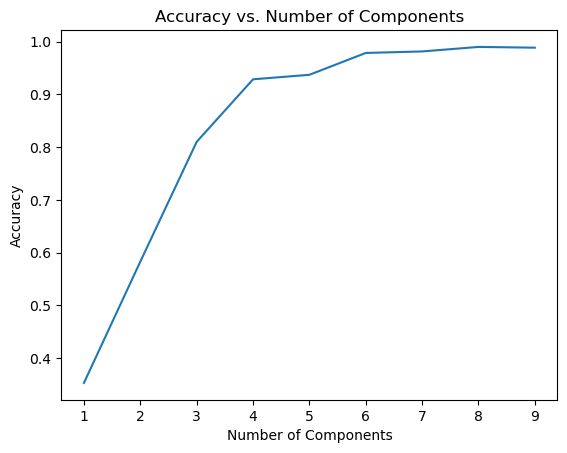

In [53]:
comps = [i for i in range(1, 10)]
accs = []

for comp in comps:
    pca = PCA(n_components=comp) 
    pca_X_train = pd.DataFrame(pca.fit_transform(X_train))
    pca_X_test = pd.DataFrame(pca.transform(X_test))

    lrpca_cls = LogisticRegression(class_weight='balanced')
    lrpca_cls.fit(pca_X_train, y_train)
    lr_pca_pred = lrpca_cls.predict(pca_X_test)

    accuracy = accuracy_score(y_test, lr_pca_pred)
    print(f'Accuracy: {accuracy}')
    accs.append(accuracy)

plt.plot(comps, accs)
plt.title('Accuracy vs. Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Accuracy')
plt.show()

c:\Users\priya\miniconda3\envs\orl\lib\site-packages\seaborn\relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)
c:\Users\priya\miniconda3\envs\orl\lib\site-packages\seaborn\relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


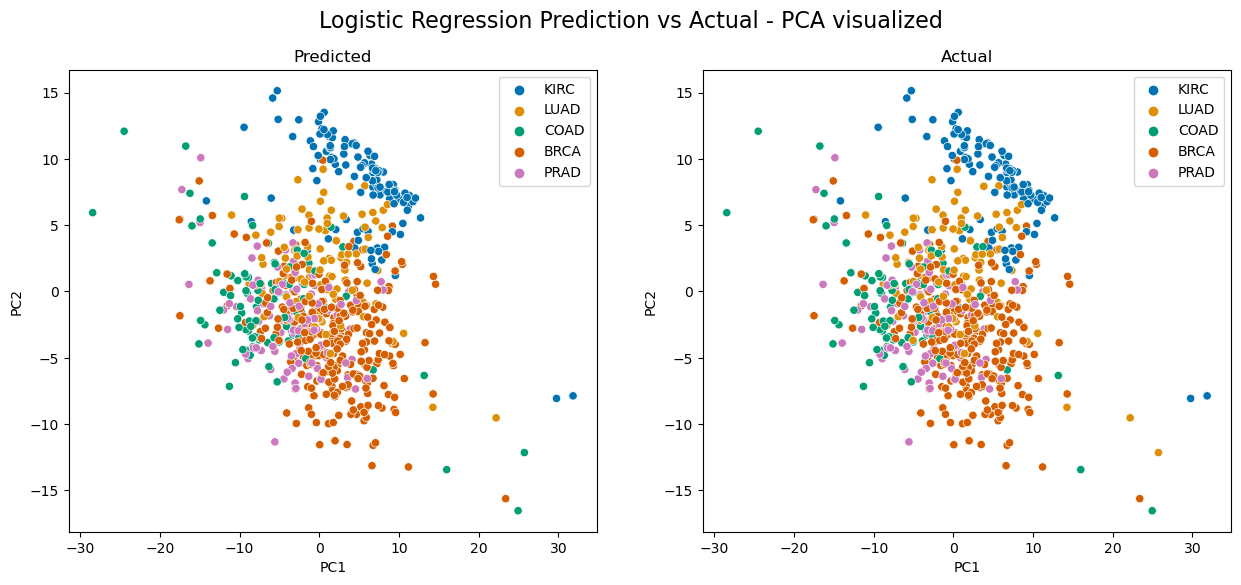

In [54]:
# setting figure parameters for size
fig_dims = (15, 6)
fig, ax = plt.subplots(1,2,figsize=fig_dims)
# Data for a axis from PCs
xline = pca_X_test.iloc[:, 0]
yline = pca_X_test.iloc[:, 1]
# plotting
sns.scatterplot(x=xline, y=yline,hue=lr_pca_pred, cmap='colorblind', ax=ax[0], palette='colorblind', legend='full')
sns.scatterplot(x=xline, y=yline,hue=np.array(y_test), cmap='colorblind', ax=ax[1], palette='colorblind', legend='full')

ax[0].set_title("Predicted")
ax[1].set_title("Actual")
ax[0].set(xlabel="PC1", ylabel="PC2")
ax[1].set(xlabel="PC1", ylabel="PC2")


fig.suptitle('Logistic Regression Prediction vs Actual - PCA visualized', fontsize=16)
plt.legend(loc='upper right')
plt.show()

Accuracy: 0.9914285714285714


c:\Users\priya\miniconda3\envs\orl\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


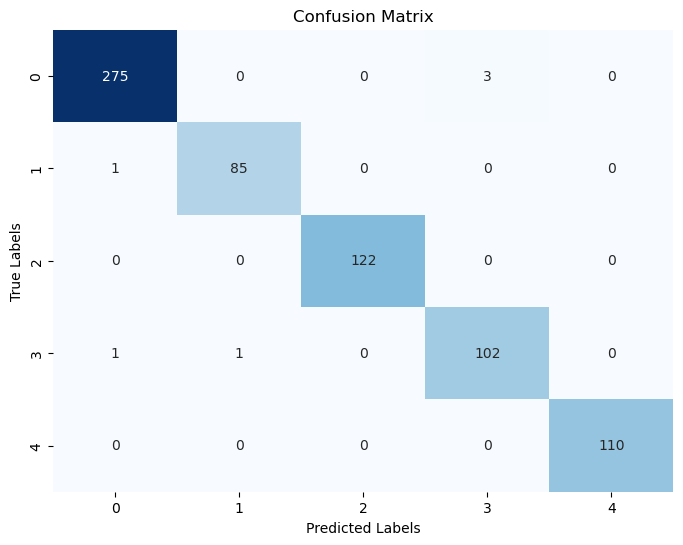

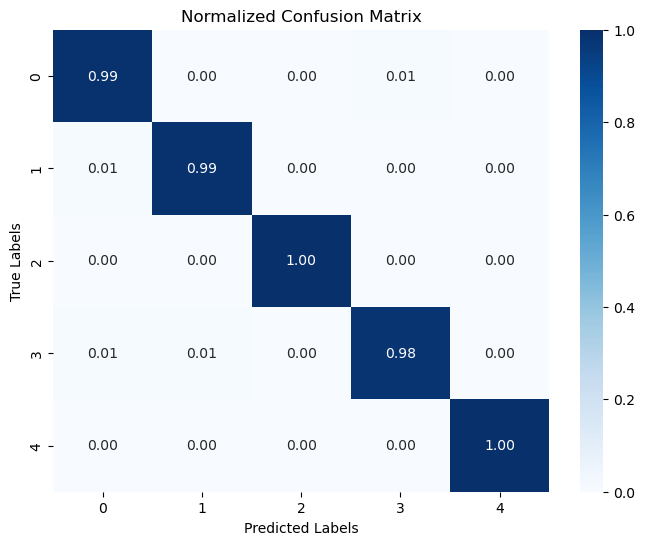

In [55]:
# 3 Components
pca = PCA(n_components=10)
pca.fit(X_train)

X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

logreg_cls = LogisticRegression(class_weight='balanced')

# Accuracy of the model with PCA
logreg_cls.fit(X_train_pca, y_train)
logreg_predicted_pca = logreg_cls.predict(X_test_pca)
logreg_accuracy_pca = accuracy_score(y_test, logreg_predicted_pca)
print(f'Accuracy: {logreg_accuracy_pca}')

# Confusion Matrix
cm = confusion_matrix(y_test, logreg_predicted_pca)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Compute normalized confusion matrix
normalized_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot normalized confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(normalized_cm, annot=True, fmt=".2f", cmap="Blues")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Normalized Confusion Matrix')
plt.show()

c:\Users\priya\miniconda3\envs\orl\lib\site-packages\seaborn\relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)
c:\Users\priya\miniconda3\envs\orl\lib\site-packages\seaborn\relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)
c:\Users\priya\miniconda3\envs\orl\lib\site-packages\seaborn\relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)
c:\Users\priya\miniconda3\envs\orl\lib\site-packages\seaborn\relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)
c:\Users\priya\miniconda3\envs\orl\lib\site-packages\seaborn\relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ig

Text(0.5, 0.98, 'PCA visualized')

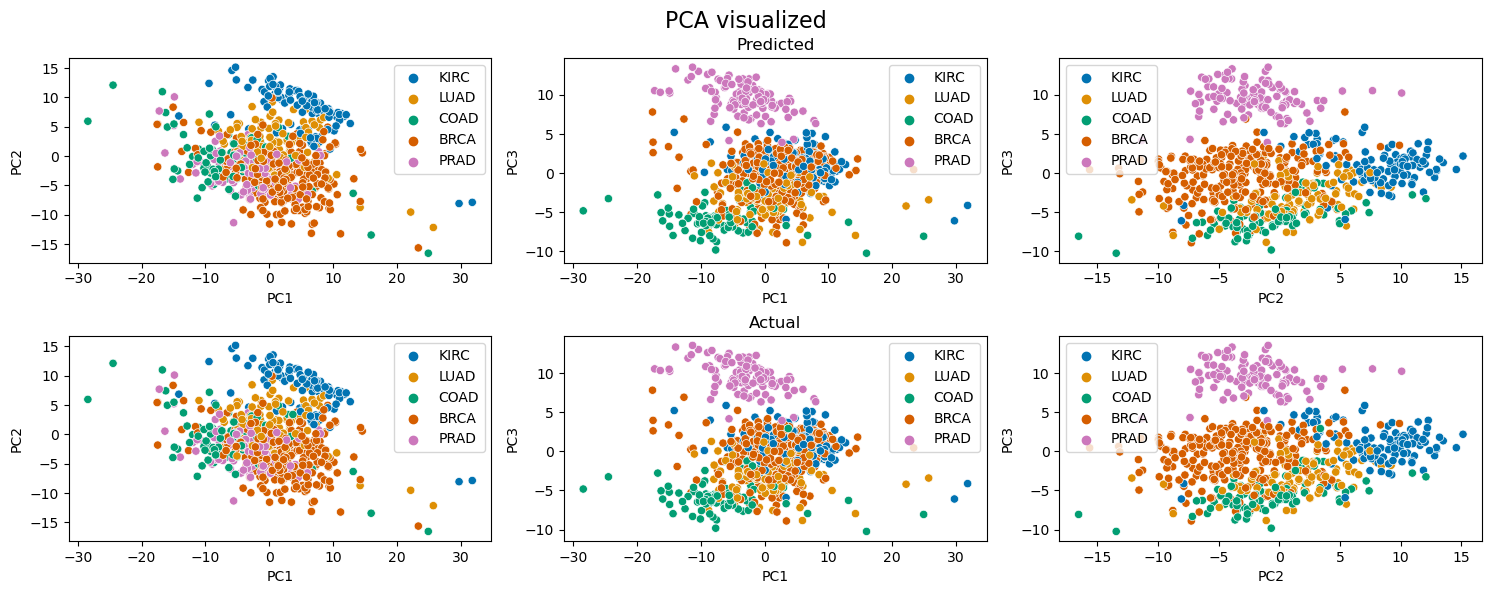

In [56]:
# setting figure parameters for size
fig_dims = (15, 6)
fig, ax = plt.subplots(2,3,figsize=fig_dims)
# Data for a axis from PCs
xline = pd.DataFrame(X_test_pca).iloc[:, 0]
yline = pd.DataFrame(X_test_pca).iloc[:, 1]
zline = pd.DataFrame(X_test_pca).iloc[:, 2]

sns.scatterplot(x=xline, y=yline, hue=logreg_predicted_pca, cmap='colorblind', ax=ax[0,0], palette='colorblind', legend='full')
sns.scatterplot(x=xline, y=zline, hue=logreg_predicted_pca, cmap='colorblind', ax=ax[0,1], palette='colorblind')
sns.scatterplot(x=yline, y=zline, hue=logreg_predicted_pca, cmap='colorblind', ax=ax[0,2], palette='colorblind')

# plotting actual
sns.scatterplot(x=xline, y=yline, hue=np.array(y_test), cmap='colorblind', ax=ax[1,0], palette='colorblind', legend='full')
sns.scatterplot(x=xline, y=zline, hue=np.array(y_test), cmap='colorblind', ax=ax[1,1], palette='colorblind')
sns.scatterplot(x=yline, y=zline, hue=np.array(y_test), cmap='colorblind', ax=ax[1,2], palette='colorblind')


ax[0,1].set_title("Predicted")
ax[1,1].set_title("Actual")
ax[0,0].set(xlabel="PC1", ylabel="PC2")
ax[0,1].set(xlabel="PC1", ylabel="PC3")
ax[0,2].set(xlabel="PC2", ylabel="PC3")
ax[1,0].set(xlabel="PC1", ylabel="PC2")
ax[1,1].set(xlabel="PC1", ylabel="PC3")
ax[1,2].set(xlabel="PC2", ylabel="PC3")
plt.tight_layout(pad=1)
plt.subplots_adjust(top=0.9)


fig.suptitle('PCA visualized', fontsize=16)

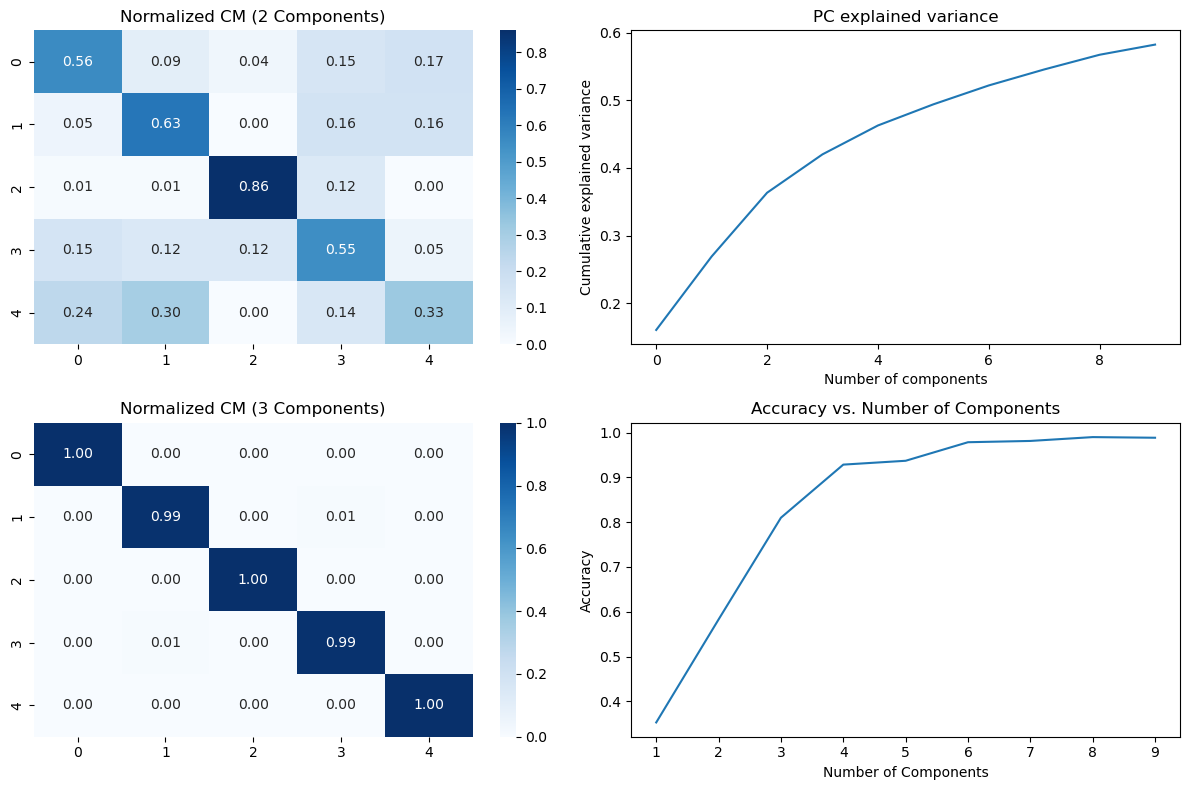

In [57]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

axes[0, 0].set_xlabel('Predicted Labels')
axes[0, 0].set_ylabel('True Labels')

sns.heatmap(normalized_cm2, annot=True, fmt=".2f", cmap="Blues", ax=axes[0, 0])
axes[0, 0].set_title('Normalized CM (2 Components)')

axes[0, 1].plot(np.cumsum(pca.explained_variance_ratio_))
axes[0, 1].set_title('PC explained variance')
axes[0, 1].set_xlabel('Number of components')
axes[0, 1].set_ylabel('Cumulative explained variance')

axes[1, 0].set_xlabel('Predicted Labels')
axes[1, 0].set_ylabel('True Labels')

sns.heatmap(normalized_cm3, annot=True, fmt=".2f", cmap="Blues", ax=axes[1, 0])
axes[1, 0].set_title('Normalized CM (3 Components)')

plt.plot(comps, accs)
axes[1, 1].set_title('Accuracy vs. Number of Components')
axes[1, 1].set_xlabel('Number of Components')
axes[1, 1].set_ylabel('Accuracy')

plt.tight_layout()
plt.show()

### K Means Clustering

c:\Users\priya\miniconda3\envs\orl\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


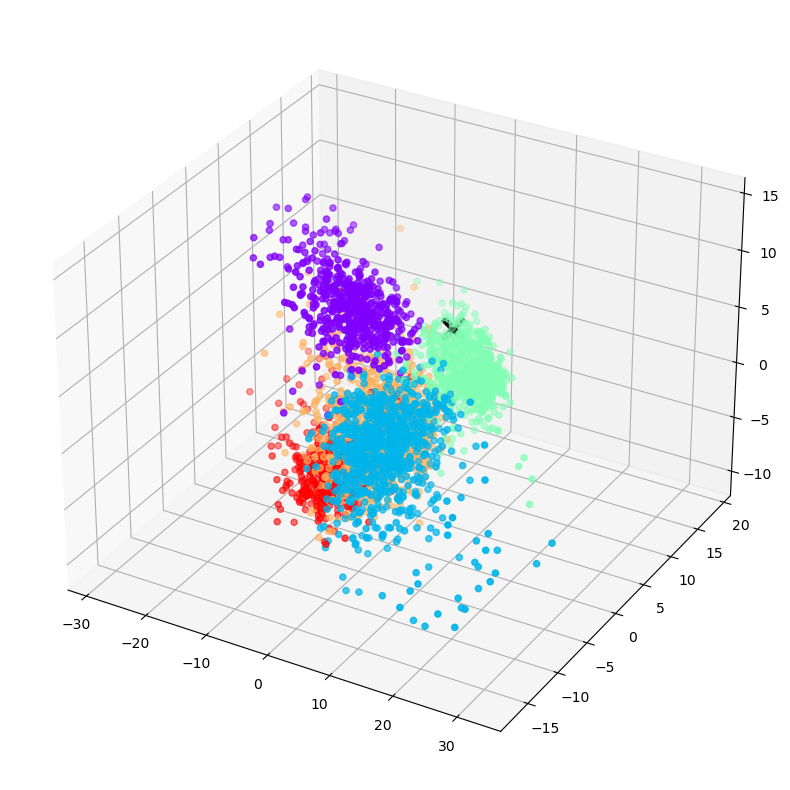

In [58]:
kmeans = KMeans(n_clusters=5).fit(X)

pca_genes = PCA(n_components=3).fit_transform(X)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_genes[:, 0], pca_genes[:, 1], pca_genes[:, 2], c=kmeans.labels_, cmap='rainbow')

ax.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], kmeans.cluster_centers_[:, 2],
              marker='x', s=200, linewidths=3, color='black', zorder=10)    
plt.show()

In [59]:
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(X_train)
cluster_labels = kmeans.labels_
cluster_centers = kmeans.cluster_centers_


cluster_df = pd.DataFrame({'cluster_labels': cluster_labels, 'actual_labels': y_train})
pd.crosstab(cluster_df['cluster_labels'], cluster_df['actual_labels'])

c:\Users\priya\miniconda3\envs\orl\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\priya\miniconda3\envs\orl\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=11.
  warnings.warn(


actual_labels   BRCA  COAD  KIRC  LUAD  PRAD
cluster_labels                              
0                308    15    17   396     2
1                  1   401     0     3     0
2                  2     0     0     0   425
3                 33     3   469    56     5
4                600    16     3    35     9

In [60]:
label_encoder = LabelEncoder()
true_labels = label_encoder.fit_transform(y_train) 
n_clusters = len(label_encoder.classes_)

preprocess = Pipeline([('scaler', StandardScaler()), ('pca', PCA(n_components=2, random_state=42))])

clusterer = Pipeline([('kmeans', KMeans(n_clusters=n_clusters, init='k-means++', n_init=50, max_iter=500, random_state=42))])

pipe = Pipeline([('preprocess', preprocess), ('clusterer', clusterer)])

pipe.fit(X_train)

c:\Users\priya\miniconda3\envs\orl\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=11.
  warnings.warn(


Pipeline(steps=[('preprocess',
                 Pipeline(steps=[('scaler', StandardScaler()),
                                 ('pca',
                                  PCA(n_components=2, random_state=42))])),
                ('clusterer',
                 Pipeline(steps=[('kmeans',
                                  KMeans(max_iter=500, n_clusters=5, n_init=50,
                                         random_state=42))]))])

In [61]:
preprocessed_data = pipe["preprocess"].transform(X_train)
predicted_labels = pipe["clusterer"]["kmeans"].labels_
silhouette_score(preprocessed_data, predicted_labels)

0.36070563214283036

In [62]:
adjusted_rand_score(true_labels, predicted_labels)

0.218630583942924

In [63]:
#t-sne
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=50, random_state=42)

tsne_data = tsne.fit_transform(X_train)

In [64]:
label_encoder.classes_

array(['BRCA', 'COAD', 'KIRC', 'LUAD', 'PRAD'], dtype=object)

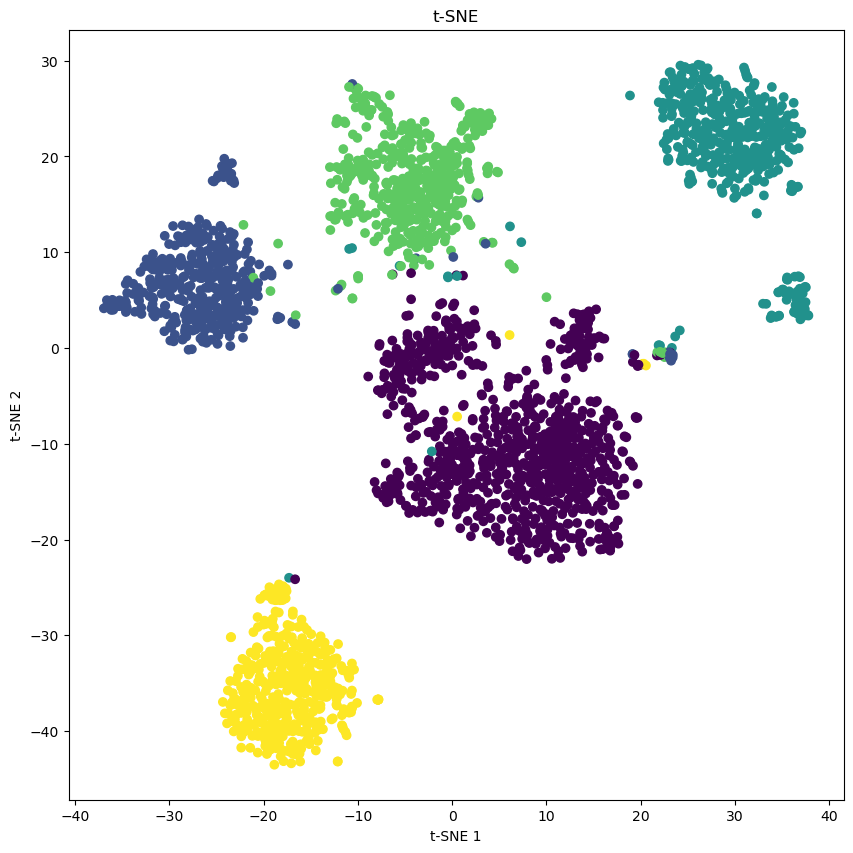

In [78]:
plt.figure(figsize=(10, 10))
plt.scatter(tsne_data[:, 0], tsne_data[:, 1], c=y_train)

plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('t-SNE')
plt.show()


## Deep Learning

Besides simpler machine learning techniques, we can also apply more complex deep learnign models to our dataset.

The following is a simple neural network with basic PCA to reduce the dimensionality of the data.

In [67]:
y = data_TopVal_genes['Class']
X = data_TopVal_genes.drop(columns=['Class'], axis=1 )

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

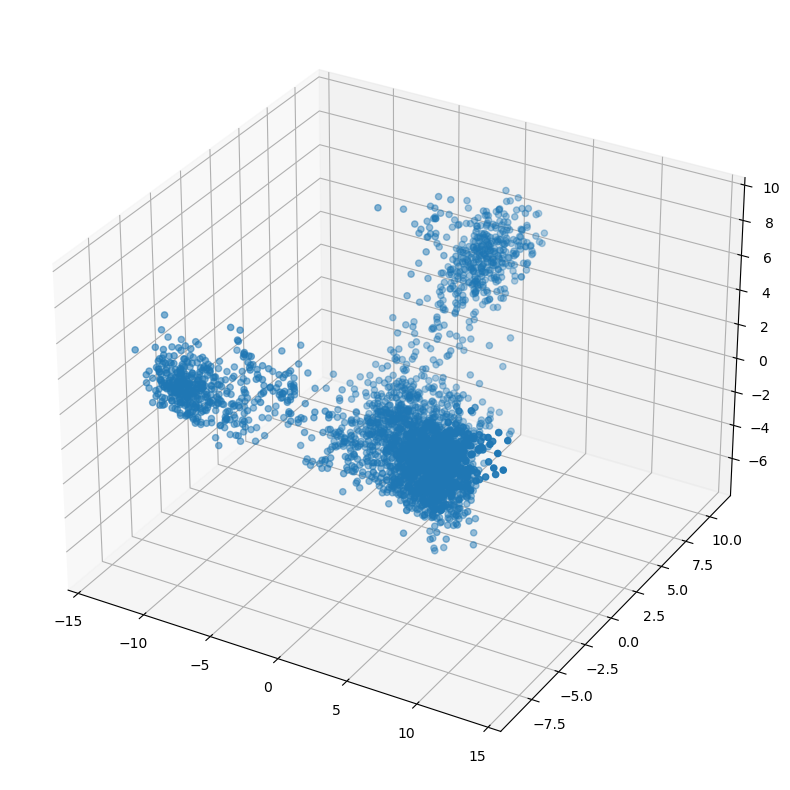

Epoch 1 Accuracy: 98.71%
Epoch 11 Accuracy: 99.43%
Epoch 21 Accuracy: 99.43%
Epoch 31 Accuracy: 99.43%
Epoch 41 Accuracy: 99.43%
Epoch 51 Accuracy: 99.43%
Epoch 61 Accuracy: 99.43%
Epoch 71 Accuracy: 99.43%
Epoch 81 Accuracy: 99.43%
Epoch 91 Accuracy: 99.43%


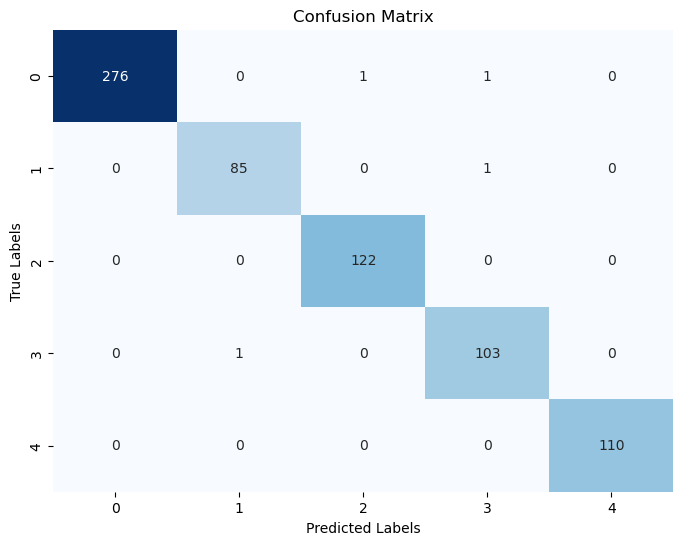

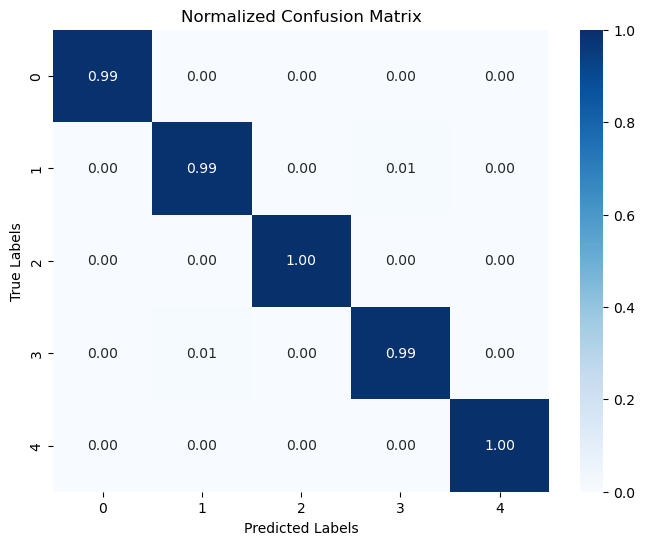

Accuracy: 0.99%
Confusion Matrix:
[[276   0   1   1   0]
 [  0  85   0   1   0]
 [  0   0 122   0   0]
 [  0   1   0 103   0]
 [  0   0   0   0 110]]
Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00       278
         1.0       0.99      0.99      0.99        86
         2.0       0.99      1.00      1.00       122
         3.0       0.98      0.99      0.99       104
         4.0       1.00      1.00      1.00       110

    accuracy                           0.99       700
   macro avg       0.99      0.99      0.99       700
weighted avg       0.99      0.99      0.99       700

Top Features:
tensor([[20, 63, 27,  ...,  2, 72, 39],
        [94, 53, 85,  ..., 29,  1, 10],
        [ 7, 73, 10,  ..., 71,  9, 34],
        ...,
        [31, 97, 10,  ...,  3, 54, 37],
        [73, 34, 86,  ..., 99,  7, 63],
        [10, 16, 63,  ..., 24, 26, 73]])
Top Features Names:
[['ENSG00000004455', 'ENSG00000007202', 'ENSG00000

In [68]:
class CancerDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
class CancerModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(CancerModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        
        return out
    
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    
    for i, (features, labels) in enumerate(train_loader):
        features = features.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(features)
        
        loss = criterion(outputs, labels)
        
        loss.backward()
        
        optimizer.step()

def test(model, test_loader, device):
    model.eval()
    
    with torch.no_grad():
        correct = 0
        total = 0
        
        for features, labels in test_loader:
            features = features.to(device)
            labels = labels.to(device)
            
            outputs = model(features)
            
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            
            correct += (predicted == labels).sum().item()

        return 100 * correct / total
    
def get_predictions(model, test_loader, device):
    model.eval()
    
    all_preds = torch.tensor([])
    all_labels = torch.tensor([])
    
    with torch.no_grad():
        for features, labels in test_loader:
            features = features.to(device)
            labels = labels.to(device)
            
            outputs = model(features)
            
            _, predicted = torch.max(outputs.data, 1)
            
            all_preds = torch.cat((all_preds, predicted), dim=0)
            all_labels = torch.cat((all_labels, labels), dim=0)
            
    return all_preds, all_labels

def get_confusion_matrix(model, test_loader, device):
    model.eval()
    
    all_preds = torch.tensor([])
    all_labels = torch.tensor([])
    
    with torch.no_grad():
        for features, labels in test_loader:
            features = features.to(device)
            labels = labels.to(device)
            
            outputs = model(features)
            
            _, predicted = torch.max(outputs.data, 1)
            
            all_preds = torch.cat((all_preds, predicted), dim=0)
            all_labels = torch.cat((all_labels, labels), dim=0)
            
    return confusion_matrix(all_labels, all_preds)

def get_classification_report(model, test_loader, device):
    model.eval()
    
    all_preds = torch.tensor([])
    all_labels = torch.tensor([])
    
    with torch.no_grad():
        for features, labels in test_loader:
            features = features.to(device)
            labels = labels.to(device)
            
            outputs = model(features)
            
            _, predicted = torch.max(outputs.data, 1)
            
            all_preds = torch.cat((all_preds, predicted), dim=0)
            all_labels = torch.cat((all_labels, labels), dim=0)
            
    return classification_report(all_labels, all_preds)

def get_accuracy(model, test_loader, device):
    model.eval()
    
    all_preds = torch.tensor([])
    all_labels = torch.tensor([])
    
    with torch.no_grad():
        for features, labels in test_loader:
            features = features.to(device)
            labels = labels.to(device)
            
            outputs = model(features)
            
            _, predicted = torch.max(outputs.data, 1)
            
            all_preds = torch.cat((all_preds, predicted), dim=0)
            all_labels = torch.cat((all_labels, labels), dim=0)
            
    return accuracy_score(all_labels, all_preds)

def get_top_features(model, X, y, k):
    model.eval()
    
    dataset = CancerDataset(X, y)
    loader = DataLoader(dataset, batch_size=len(dataset), shuffle=False)
    
    with torch.no_grad():
        for features, labels in loader:
            outputs = model(features)
            
            _, predicted = torch.max(outputs.data, 1)
            
            correct = (predicted == labels).sum().item()
            
            if correct == len(dataset):
                break
                
        top_features = torch.argsort(model.fc1.weight.data.abs(), dim=1, descending=True)[:, :k]
        
        return top_features
    
def get_top_features_names(model, X, y, k, feature_names):
    top_features = get_top_features(model, X, y, k)
    
    top_features_names = []
    
    for i in range(len(top_features)):
        top_features_names.append([feature_names[j.item()] for j in top_features[i]])
        
    return top_features_names

def get_top_features_by_class(model, X, y, k, feature_names):

    top_features_names = get_top_features_names(model, X, y, k, feature_names)
    
    top_features_by_class = {}
    
    for i in range(len(top_features_names)):
        top_features_by_class[y[i]] = top_features_names[i]
        
    return top_features_by_class

def get_top_features_by_class(model, X, y, k, feature_names):

    top_features_names = get_top_features_names(model, X, y, k, feature_names)
    
    top_features_by_class = {}
    
    for i in range(len(top_features_names)):
        top_features_by_class[y[i]] = top_features_names[i]
        
    return top_features_by_class

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y.values.ravel())

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Select the top N features
k_best = SelectKBest(score_func=f_classif, k=100)  # Adjust 'k' as needed
X_train = k_best.fit_transform(X_train, y_train)
X_test = k_best.transform(X_test)

# Use PCA to reduce features for visualization
pca_genes = PCA(n_components=3).fit_transform(X_train)

# Plot the clusters
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_genes[:, 0], pca_genes[:, 1], pca_genes[:, 2])
plt.show()


# Create datasets and loaders
train_dataset = CancerDataset(X_train, y_train)
test_dataset = CancerDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Create model
model = CancerModel(X_train.shape[1], 128, 5)

# Set device
device = torch.device('cpu')
model.to(device)

# Set loss function, optimizer, and number of epochs
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 100

# Train model

for epoch in range(epochs):
    train(model, train_loader, criterion, optimizer, device)
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch+1} Accuracy: {test(model, test_loader, device):.2f}%')

# Get predictions
preds, labels = get_predictions(model, test_loader, device)

# Get confusion matrix
cm = get_confusion_matrix(model, test_loader, device)

# Get classification report
report = get_classification_report(model, test_loader, device)

# Get accuracy
accuracy = get_accuracy(model, test_loader, device)

# Get top features
top_features = get_top_features(model, X_train, y_train, 10)

# Get top features names
top_features_names = get_top_features_names(model, X_train, y_train, 10, data_TopVal_genes.drop(columns=['Class']).columns)

# Get top features by class
top_features_by_class = get_top_features_by_class(model, X_train, y_train, 10, data_TopVal_genes.drop(columns=['Class']).columns)

# Plot the classification report

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Plot the normalized confusion matrix
normalized_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(normalized_cm, annot=True, fmt=".2f", cmap="Blues")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Normalized Confusion Matrix')
plt.show()

# Print results
print(f'Accuracy: {accuracy:.2f}%')
print(f'Confusion Matrix:\n{cm}')
print(f'Classification Report:\n{report}')
print(f'Top Features:\n{top_features}')
print(f'Top Features Names:\n{top_features_names}')
print(f'Top Features By Class:\n{top_features_by_class}')

In [69]:
# Test the model on a single sample
sample = X_test[0]
sample = torch.tensor(sample, dtype=torch.float32).unsqueeze(0)
sample = sample.to(device)

output = model(sample)
_, predicted = torch.max(output.data, 1)

print(f'Predicted: {predicted.item()}')
print(f'Actual: {y_test[0]}')

Predicted: 2
Actual: 2


After showcasing the prior deep learning model, we explore and see which features of the model are the most important

In [70]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y.values.ravel())

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

train_dataset = TensorDataset(torch.tensor(X_train.values, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
test_dataset = TensorDataset(torch.tensor(X_test.values, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long))

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

class CancerModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(CancerModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        
        return out

In [71]:
def test(model, test_loader, device):
    model.eval()
    
    with torch.no_grad():
        correct = 0
        total = 0
        
        for features, labels in test_loader:
            features = features.to(device)
            labels = labels.to(device)
            
            outputs = model(features)
            
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            
            correct += (predicted == labels).sum().item()
            
        return 100 * correct / total

In [72]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Create model
model = CancerModel(X_train.shape[1], 128, 5)

model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 100

for epoch in range(epochs):
    train(model, train_loader, criterion, optimizer, device)
    
    if epoch % 10 == 0:
        acc = test(model, test_loader, device)
        print(f'Epoch {epoch} Accuracy: {acc:.2f}%')

Epoch 0 Accuracy: 39.71%
Epoch 10 Accuracy: 58.29%
Epoch 20 Accuracy: 94.71%
Epoch 30 Accuracy: 86.71%
Epoch 40 Accuracy: 65.14%
Epoch 50 Accuracy: 96.71%
Epoch 60 Accuracy: 99.00%
Epoch 70 Accuracy: 98.71%
Epoch 80 Accuracy: 99.57%
Epoch 90 Accuracy: 98.57%


Epoch [1/100], Step [44/11], Loss: 0.0958, Accuracy: 24.87%


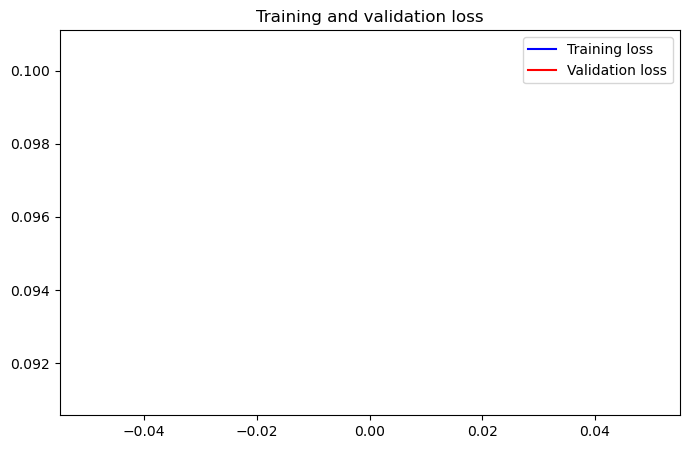

Test Accuracy of the model: 39.714285714285715 %
Epoch [2/100], Step [44/11], Loss: 0.0250, Accuracy: 30.87%
Test Accuracy of the model: 39.714285714285715 %
Epoch [3/100], Step [44/11], Loss: 0.0239, Accuracy: 34.41%
Test Accuracy of the model: 39.714285714285715 %
Epoch [4/100], Step [44/11], Loss: 0.0237, Accuracy: 34.98%
Test Accuracy of the model: 39.714285714285715 %
Epoch [5/100], Step [44/11], Loss: 0.0230, Accuracy: 35.62%
Test Accuracy of the model: 39.714285714285715 %
Epoch [6/100], Step [44/11], Loss: 0.0228, Accuracy: 37.55%
Test Accuracy of the model: 39.714285714285715 %
Epoch [7/100], Step [44/11], Loss: 0.0220, Accuracy: 39.66%
Test Accuracy of the model: 50.0 %
Epoch [8/100], Step [44/11], Loss: 0.0215, Accuracy: 39.94%
Test Accuracy of the model: 48.714285714285715 %
Epoch [9/100], Step [44/11], Loss: 0.0209, Accuracy: 42.84%
Test Accuracy of the model: 59.57142857142857 %
Epoch [10/100], Step [44/11], Loss: 0.0194, Accuracy: 46.45%
Test Accuracy of the model: 44.42

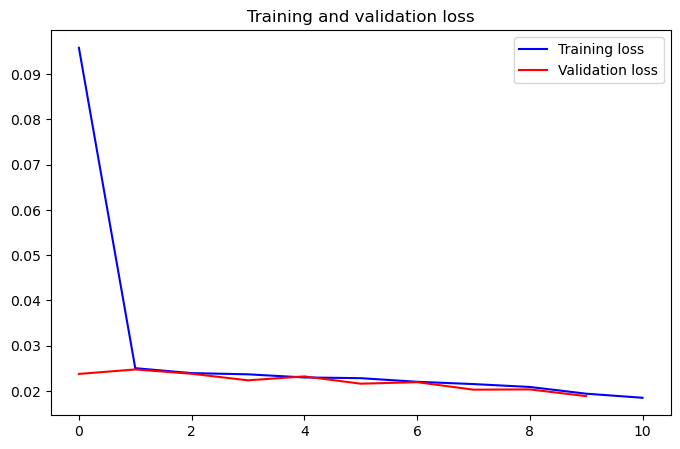

Test Accuracy of the model: 49.857142857142854 %
Epoch [12/100], Step [44/11], Loss: 0.0179, Accuracy: 47.80%
Test Accuracy of the model: 42.285714285714285 %
Epoch [13/100], Step [44/11], Loss: 0.0175, Accuracy: 51.05%
Test Accuracy of the model: 49.0 %
Epoch [14/100], Step [44/11], Loss: 0.0162, Accuracy: 54.06%
Test Accuracy of the model: 54.142857142857146 %
Epoch [15/100], Step [44/11], Loss: 0.0156, Accuracy: 57.09%
Test Accuracy of the model: 49.0 %
Epoch [16/100], Step [44/11], Loss: 0.0147, Accuracy: 60.20%
Test Accuracy of the model: 61.285714285714285 %
Epoch [17/100], Step [44/11], Loss: 0.0151, Accuracy: 56.41%
Test Accuracy of the model: 68.42857142857143 %
Epoch [18/100], Step [44/11], Loss: 0.0139, Accuracy: 60.49%
Test Accuracy of the model: 66.0 %
Epoch [19/100], Step [44/11], Loss: 0.0132, Accuracy: 62.45%
Test Accuracy of the model: 70.57142857142857 %
Epoch [20/100], Step [44/11], Loss: 0.0128, Accuracy: 63.92%
Test Accuracy of the model: 68.57142857142857 %
Epoch 

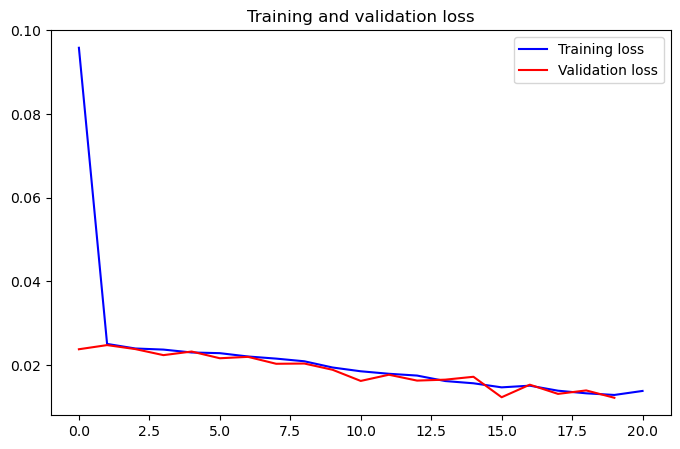

Test Accuracy of the model: 65.28571428571429 %
Epoch [22/100], Step [44/11], Loss: 0.0119, Accuracy: 67.24%
Test Accuracy of the model: 67.57142857142857 %
Epoch [23/100], Step [44/11], Loss: 0.0117, Accuracy: 65.38%
Test Accuracy of the model: 65.85714285714286 %
Epoch [24/100], Step [44/11], Loss: 0.0120, Accuracy: 66.17%
Test Accuracy of the model: 68.71428571428571 %
Epoch [25/100], Step [44/11], Loss: 0.0127, Accuracy: 63.09%
Test Accuracy of the model: 60.285714285714285 %
Epoch [26/100], Step [44/11], Loss: 0.0117, Accuracy: 66.24%
Test Accuracy of the model: 74.14285714285714 %
Epoch [27/100], Step [44/11], Loss: 0.0106, Accuracy: 69.60%
Test Accuracy of the model: 74.85714285714286 %
Epoch [28/100], Step [44/11], Loss: 0.0104, Accuracy: 70.92%
Test Accuracy of the model: 78.57142857142857 %
Epoch [29/100], Step [44/11], Loss: 0.0103, Accuracy: 71.13%
Test Accuracy of the model: 77.42857142857143 %
Epoch [30/100], Step [44/11], Loss: 0.0100, Accuracy: 72.13%
Test Accuracy of t

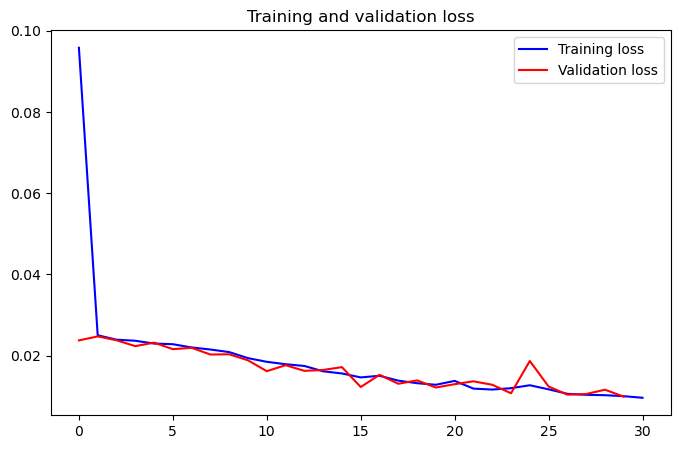

Test Accuracy of the model: 79.71428571428571 %
Epoch [32/100], Step [44/11], Loss: 0.0100, Accuracy: 72.81%
Test Accuracy of the model: 80.0 %
Epoch [33/100], Step [44/11], Loss: 0.0092, Accuracy: 76.06%
Test Accuracy of the model: 80.42857142857143 %
Epoch [34/100], Step [44/11], Loss: 0.0091, Accuracy: 76.78%
Test Accuracy of the model: 78.57142857142857 %
Epoch [35/100], Step [44/11], Loss: 0.0110, Accuracy: 68.52%
Test Accuracy of the model: 64.0 %
Epoch [36/100], Step [44/11], Loss: 0.0091, Accuracy: 75.10%
Test Accuracy of the model: 75.28571428571429 %
Epoch [37/100], Step [44/11], Loss: 0.0088, Accuracy: 76.38%
Test Accuracy of the model: 84.42857142857143 %
Epoch [38/100], Step [44/11], Loss: 0.0083, Accuracy: 81.10%
Test Accuracy of the model: 80.28571428571429 %
Epoch [39/100], Step [44/11], Loss: 0.0085, Accuracy: 79.03%
Test Accuracy of the model: 83.0 %
Epoch [40/100], Step [44/11], Loss: 0.0091, Accuracy: 75.46%
Test Accuracy of the model: 76.42857142857143 %
Epoch [41/

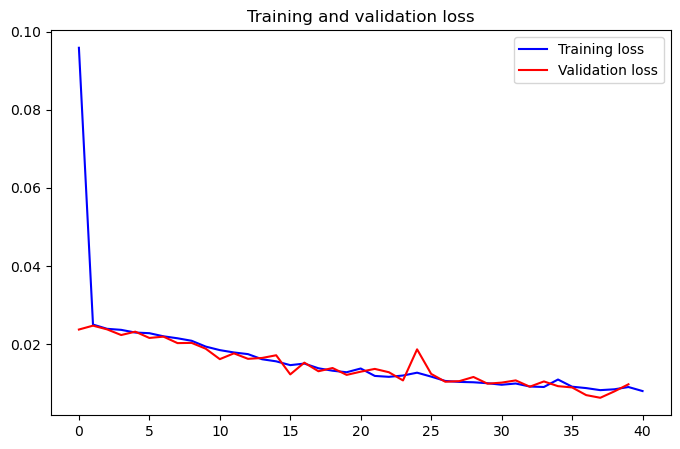

Test Accuracy of the model: 84.57142857142857 %
Epoch [42/100], Step [44/11], Loss: 0.0082, Accuracy: 79.42%
Test Accuracy of the model: 86.14285714285714 %
Epoch [43/100], Step [44/11], Loss: 0.0077, Accuracy: 83.57%
Test Accuracy of the model: 86.28571428571429 %
Epoch [44/100], Step [44/11], Loss: 0.0074, Accuracy: 83.89%
Test Accuracy of the model: 79.85714285714286 %
Epoch [45/100], Step [44/11], Loss: 0.0085, Accuracy: 78.53%
Test Accuracy of the model: 86.28571428571429 %
Epoch [46/100], Step [44/11], Loss: 0.0070, Accuracy: 86.28%
Test Accuracy of the model: 77.71428571428571 %
Epoch [47/100], Step [44/11], Loss: 0.0074, Accuracy: 82.99%
Test Accuracy of the model: 88.42857142857143 %
Epoch [48/100], Step [44/11], Loss: 0.0072, Accuracy: 84.57%
Test Accuracy of the model: 89.0 %
Epoch [49/100], Step [44/11], Loss: 0.0070, Accuracy: 84.85%
Test Accuracy of the model: 86.14285714285714 %
Epoch [50/100], Step [44/11], Loss: 0.0073, Accuracy: 83.67%
Test Accuracy of the model: 62.8

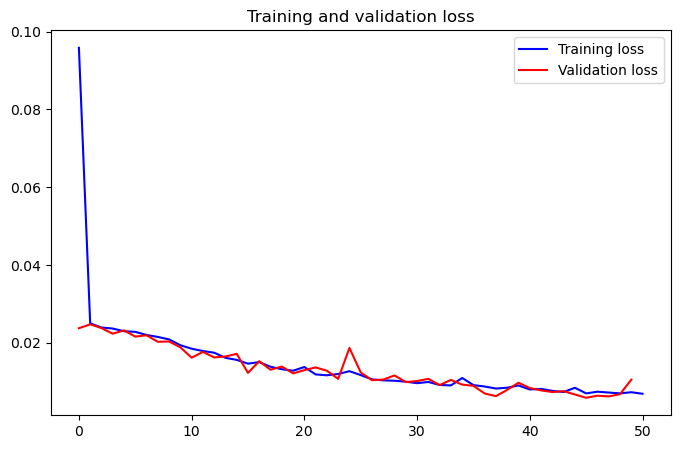

Test Accuracy of the model: 88.85714285714286 %
Epoch [52/100], Step [44/11], Loss: 0.0063, Accuracy: 88.07%
Test Accuracy of the model: 88.0 %
Epoch [53/100], Step [44/11], Loss: 0.0070, Accuracy: 84.78%
Test Accuracy of the model: 86.28571428571429 %
Epoch [54/100], Step [44/11], Loss: 0.0068, Accuracy: 84.67%
Test Accuracy of the model: 92.42857142857143 %
Epoch [55/100], Step [44/11], Loss: 0.0057, Accuracy: 91.57%
Test Accuracy of the model: 90.28571428571429 %
Epoch [56/100], Step [44/11], Loss: 0.0062, Accuracy: 87.85%
Test Accuracy of the model: 29.285714285714285 %
Epoch [57/100], Step [44/11], Loss: 0.0066, Accuracy: 86.35%
Test Accuracy of the model: 90.14285714285714 %
Epoch [58/100], Step [44/11], Loss: 0.0062, Accuracy: 87.32%
Test Accuracy of the model: 92.42857142857143 %
Epoch [59/100], Step [44/11], Loss: 0.0064, Accuracy: 85.99%
Test Accuracy of the model: 87.85714285714286 %
Epoch [60/100], Step [44/11], Loss: 0.0070, Accuracy: 83.89%
Test Accuracy of the model: 86.

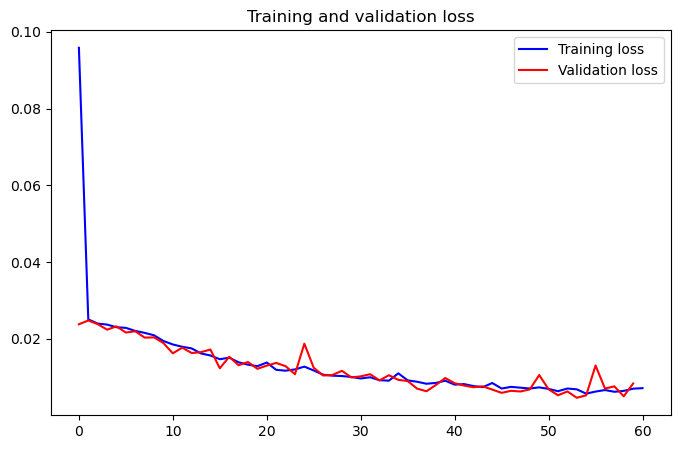

Test Accuracy of the model: 78.14285714285714 %
Epoch [62/100], Step [44/11], Loss: 0.0056, Accuracy: 89.17%
Test Accuracy of the model: 85.42857142857143 %
Epoch [63/100], Step [44/11], Loss: 0.0056, Accuracy: 89.82%
Test Accuracy of the model: 89.14285714285714 %
Epoch [64/100], Step [44/11], Loss: 0.0054, Accuracy: 89.75%
Test Accuracy of the model: 94.0 %
Epoch [65/100], Step [44/11], Loss: 0.0059, Accuracy: 87.28%
Test Accuracy of the model: 90.57142857142857 %
Epoch [66/100], Step [44/11], Loss: 0.0053, Accuracy: 91.14%
Test Accuracy of the model: 96.0 %
Epoch [67/100], Step [44/11], Loss: 0.0073, Accuracy: 81.28%
Test Accuracy of the model: 71.0 %
Epoch [68/100], Step [44/11], Loss: 0.0066, Accuracy: 84.32%
Test Accuracy of the model: 86.85714285714286 %
Epoch [69/100], Step [44/11], Loss: 0.0047, Accuracy: 92.28%
Test Accuracy of the model: 96.14285714285714 %
Epoch [70/100], Step [44/11], Loss: 0.0043, Accuracy: 94.50%
Test Accuracy of the model: 96.28571428571429 %
Epoch [71/

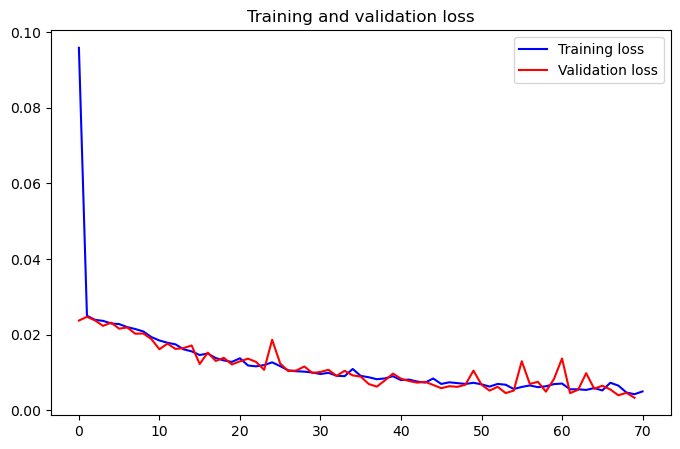

Test Accuracy of the model: 93.85714285714286 %
Epoch [72/100], Step [44/11], Loss: 0.0061, Accuracy: 85.64%
Test Accuracy of the model: 68.57142857142857 %
Epoch [73/100], Step [44/11], Loss: 0.0059, Accuracy: 87.71%
Test Accuracy of the model: 87.28571428571429 %
Epoch [74/100], Step [44/11], Loss: 0.0047, Accuracy: 91.43%
Test Accuracy of the model: 93.0 %
Epoch [75/100], Step [44/11], Loss: 0.0042, Accuracy: 93.75%
Test Accuracy of the model: 96.85714285714286 %
Epoch [76/100], Step [44/11], Loss: 0.0045, Accuracy: 92.43%
Test Accuracy of the model: 93.14285714285714 %
Epoch [77/100], Step [44/11], Loss: 0.0040, Accuracy: 94.71%
Test Accuracy of the model: 95.14285714285714 %
Epoch [78/100], Step [44/11], Loss: 0.0039, Accuracy: 94.89%
Test Accuracy of the model: 89.57142857142857 %
Epoch [79/100], Step [44/11], Loss: 0.0043, Accuracy: 93.14%
Test Accuracy of the model: 95.57142857142857 %
Epoch [80/100], Step [44/11], Loss: 0.0038, Accuracy: 94.96%
Test Accuracy of the model: 92.7

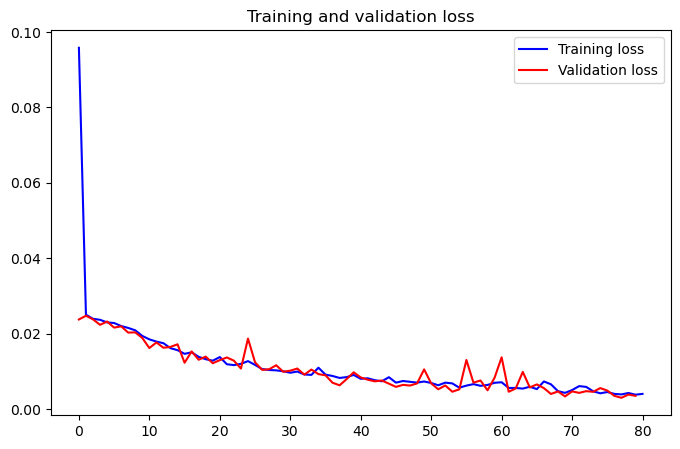

Test Accuracy of the model: 95.0 %
Epoch [82/100], Step [44/11], Loss: 0.0043, Accuracy: 93.32%
Test Accuracy of the model: 96.42857142857143 %
Epoch [83/100], Step [44/11], Loss: 0.0045, Accuracy: 92.18%
Test Accuracy of the model: 96.0 %
Epoch [84/100], Step [44/11], Loss: 0.0037, Accuracy: 95.46%
Test Accuracy of the model: 96.71428571428571 %
Epoch [85/100], Step [44/11], Loss: 0.0035, Accuracy: 95.03%
Test Accuracy of the model: 97.0 %
Epoch [86/100], Step [44/11], Loss: 0.0043, Accuracy: 91.57%
Test Accuracy of the model: 95.0 %
Epoch [87/100], Step [44/11], Loss: 0.0038, Accuracy: 94.00%
Test Accuracy of the model: 87.57142857142857 %
Epoch [88/100], Step [44/11], Loss: 0.0041, Accuracy: 92.46%
Test Accuracy of the model: 93.28571428571429 %
Epoch [89/100], Step [44/11], Loss: 0.0045, Accuracy: 90.57%
Test Accuracy of the model: 97.42857142857143 %
Epoch [90/100], Step [44/11], Loss: 0.0037, Accuracy: 94.32%
Test Accuracy of the model: 93.57142857142857 %
Epoch [91/100], Step [4

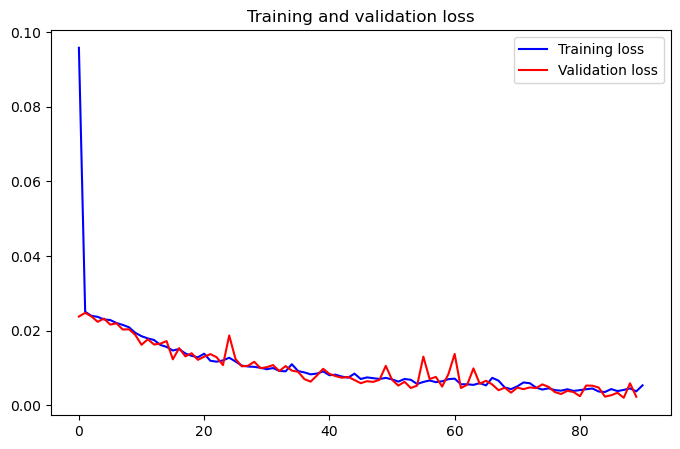

Test Accuracy of the model: 65.14285714285714 %
Epoch [92/100], Step [44/11], Loss: 0.0063, Accuracy: 85.39%
Test Accuracy of the model: 85.28571428571429 %
Epoch [93/100], Step [44/11], Loss: 0.0037, Accuracy: 93.75%
Test Accuracy of the model: 96.28571428571429 %
Epoch [94/100], Step [44/11], Loss: 0.0034, Accuracy: 95.28%
Test Accuracy of the model: 95.71428571428571 %
Epoch [95/100], Step [44/11], Loss: 0.0032, Accuracy: 96.07%
Test Accuracy of the model: 97.71428571428571 %
Epoch [96/100], Step [44/11], Loss: 0.0033, Accuracy: 95.43%
Test Accuracy of the model: 97.71428571428571 %
Epoch [97/100], Step [44/11], Loss: 0.0030, Accuracy: 95.93%
Test Accuracy of the model: 97.28571428571429 %
Epoch [98/100], Step [44/11], Loss: 0.0035, Accuracy: 93.57%
Test Accuracy of the model: 96.57142857142857 %
Epoch [99/100], Step [44/11], Loss: 0.0145, Accuracy: 68.88%
Test Accuracy of the model: 61.142857142857146 %
Epoch [100/100], Step [44/11], Loss: 0.0052, Accuracy: 86.89%
Test Accuracy of 

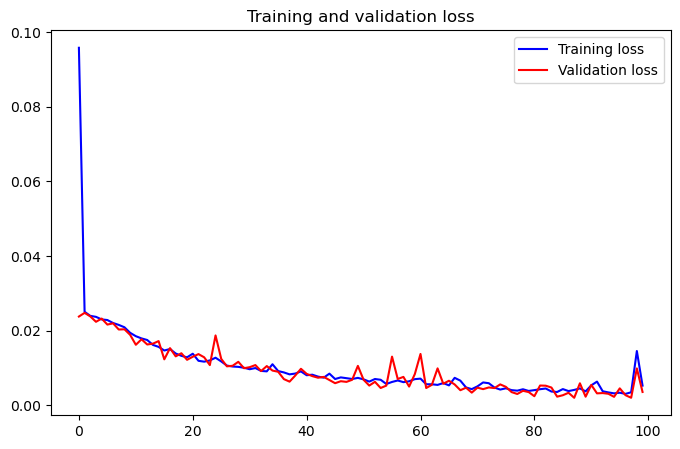

In [73]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

model = CancerModel(X_train.shape[1], 256, 5)

model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 100

logs = {}
logs['train_loss'] = []
logs['train_Accuracy'] = []
logs['val_loss'] = []
logs['val_Accuracy'] = []


for epoch in range(epochs):
    total_correct = 0
    total_loss = 0
    total_genes = 0
    total_val_loss = 0

    model.train()
    for i, (data, target) in enumerate(train_loader):

        genes = data.to(device)
        labels = target.to(device)

        outputs = model(genes)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_genes += labels.size(0)

        _, predicted = torch.max(outputs.detach(), 1)

        correct = (predicted == labels).sum().item()

        total_correct += correct
        total_loss += loss.item()
    logs['train_loss'].append(total_loss / total_genes)
    logs['train_Accuracy'].append((total_correct / total_genes) * 100)


    print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
              .format(epoch + 1, epochs, i + 1, len(test_loader), (total_loss / total_genes),
                      (total_correct / total_genes) * 100))
    
    if epoch % 10 == 0:
        fig, ax = plt.subplots(figsize=(8, 5))
        ax.plot(logs['train_loss'], 'b', label='Training loss')
        ax.plot(logs['val_loss'], 'r', label='Validation loss')
        ax.set_title('Training and validation loss')
        ax.legend()
        plt.show()
    
    model.eval()

    with torch.no_grad():
        correct = 0
        total = 0
        total_losss = 0

        for data, target in test_loader:
            genes = data.to(device)
            labels = target.to(device)
            outputs = model(genes)

            _, predicted = torch.max(outputs.detach(), 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            total_losss += loss.item()

            accuracy = correct / total

        print('Test Accuracy of the model: {} %'.format(100 * correct / total))
        logs['val_loss'].append(total_losss / total)
        logs['val_Accuracy'].append((correct / total) * 100)


fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(logs['train_loss'], 'b', label='Training loss')
ax.plot(logs['val_loss'], 'r', label='Validation loss')
ax.set_title('Training and validation loss')
ax.legend()
plt.show()

Epoch [1/100], Step [44/11], Loss: 0.0907, Accuracy: 25.26%


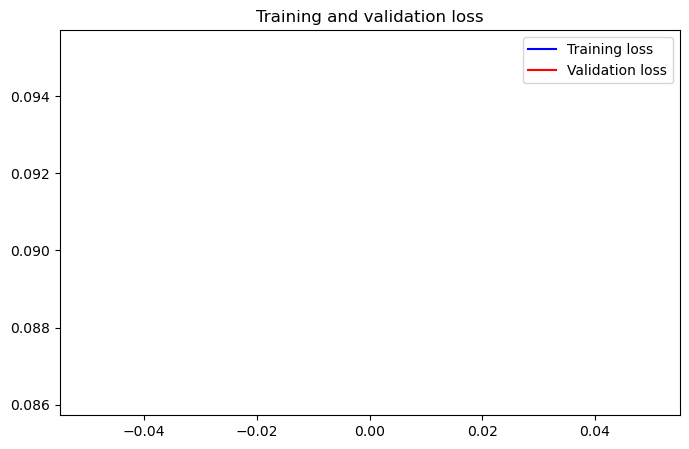

Test Accuracy of the model: 12.285714285714286 %
Epoch [2/100], Step [44/11], Loss: 0.0248, Accuracy: 34.55%
Test Accuracy of the model: 31.0 %
Epoch [3/100], Step [44/11], Loss: 0.0240, Accuracy: 35.08%
Test Accuracy of the model: 15.0 %
Epoch [4/100], Step [44/11], Loss: 0.0227, Accuracy: 39.73%
Test Accuracy of the model: 39.714285714285715 %
Epoch [5/100], Step [44/11], Loss: 0.0221, Accuracy: 39.62%
Test Accuracy of the model: 45.285714285714285 %
Epoch [6/100], Step [44/11], Loss: 0.0208, Accuracy: 45.27%
Test Accuracy of the model: 25.571428571428573 %
Epoch [7/100], Step [44/11], Loss: 0.0200, Accuracy: 48.91%
Test Accuracy of the model: 18.714285714285715 %
Epoch [8/100], Step [44/11], Loss: 0.0194, Accuracy: 50.66%
Test Accuracy of the model: 53.857142857142854 %
Epoch [9/100], Step [44/11], Loss: 0.0177, Accuracy: 57.81%
Test Accuracy of the model: 53.42857142857143 %
Epoch [10/100], Step [44/11], Loss: 0.0187, Accuracy: 53.41%
Test Accuracy of the model: 68.85714285714286 %

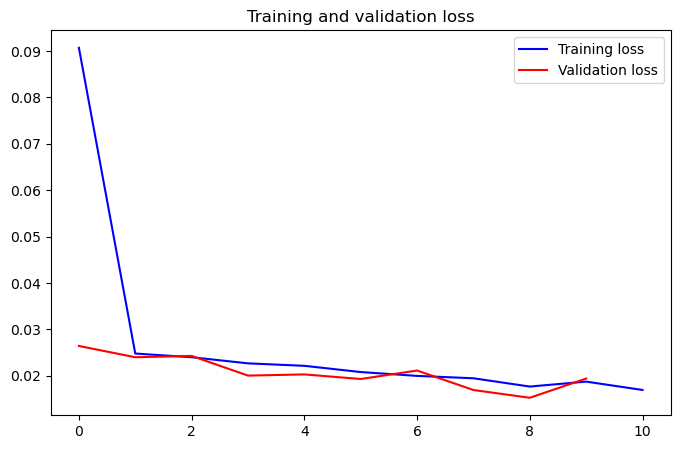

Test Accuracy of the model: 73.57142857142857 %
Epoch [12/100], Step [44/11], Loss: 0.0158, Accuracy: 64.81%
Test Accuracy of the model: 78.71428571428571 %
Epoch [13/100], Step [44/11], Loss: 0.0142, Accuracy: 73.49%
Test Accuracy of the model: 67.57142857142857 %
Epoch [14/100], Step [44/11], Loss: 0.0131, Accuracy: 74.67%
Test Accuracy of the model: 68.42857142857143 %
Epoch [15/100], Step [44/11], Loss: 0.0115, Accuracy: 80.17%
Test Accuracy of the model: 80.57142857142857 %
Epoch [16/100], Step [44/11], Loss: 0.0107, Accuracy: 80.03%
Test Accuracy of the model: 74.57142857142857 %
Epoch [17/100], Step [44/11], Loss: 0.0117, Accuracy: 74.03%
Test Accuracy of the model: 83.71428571428571 %
Epoch [18/100], Step [44/11], Loss: 0.0102, Accuracy: 79.53%
Test Accuracy of the model: 88.71428571428571 %
Epoch [19/100], Step [44/11], Loss: 0.0098, Accuracy: 78.42%
Test Accuracy of the model: 92.28571428571429 %
Epoch [20/100], Step [44/11], Loss: 0.0076, Accuracy: 88.25%
Test Accuracy of th

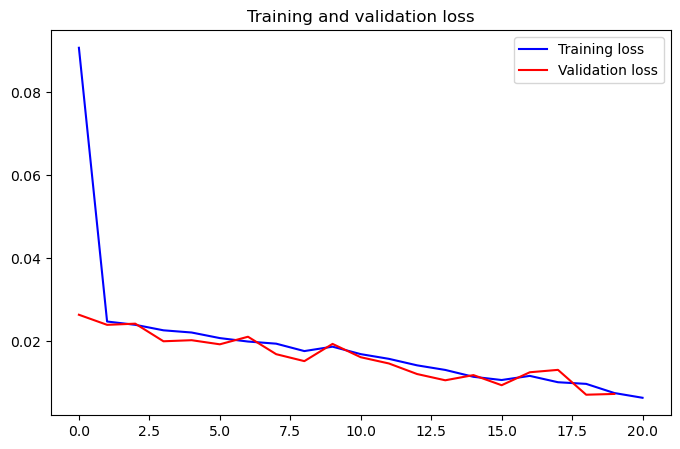

Test Accuracy of the model: 92.28571428571429 %
Epoch [22/100], Step [44/11], Loss: 0.0077, Accuracy: 83.82%
Test Accuracy of the model: 87.85714285714286 %
Epoch [23/100], Step [44/11], Loss: 0.0061, Accuracy: 90.93%
Test Accuracy of the model: 95.71428571428571 %
Epoch [24/100], Step [44/11], Loss: 0.0053, Accuracy: 92.96%
Test Accuracy of the model: 95.28571428571429 %
Epoch [25/100], Step [44/11], Loss: 0.0046, Accuracy: 94.93%
Test Accuracy of the model: 97.0 %
Epoch [26/100], Step [44/11], Loss: 0.0045, Accuracy: 94.18%
Test Accuracy of the model: 96.57142857142857 %
Epoch [27/100], Step [44/11], Loss: 0.0049, Accuracy: 92.21%
Test Accuracy of the model: 94.57142857142857 %
Epoch [28/100], Step [44/11], Loss: 0.0040, Accuracy: 94.82%
Test Accuracy of the model: 96.28571428571429 %
Epoch [29/100], Step [44/11], Loss: 0.0035, Accuracy: 95.57%
Test Accuracy of the model: 94.71428571428571 %
Epoch [30/100], Step [44/11], Loss: 0.0037, Accuracy: 94.96%
Test Accuracy of the model: 96.5

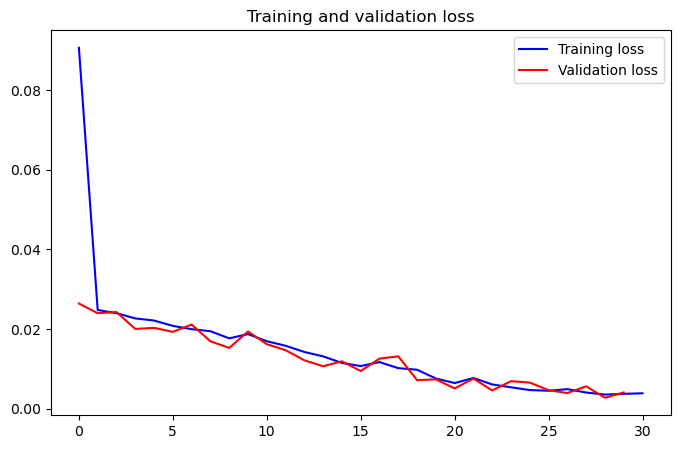

Test Accuracy of the model: 94.57142857142857 %
Epoch [32/100], Step [44/11], Loss: 0.0028, Accuracy: 96.36%
Test Accuracy of the model: 97.28571428571429 %
Epoch [33/100], Step [44/11], Loss: 0.0025, Accuracy: 97.68%
Test Accuracy of the model: 97.14285714285714 %
Epoch [34/100], Step [44/11], Loss: 0.0033, Accuracy: 94.28%
Test Accuracy of the model: 95.42857142857143 %
Epoch [35/100], Step [44/11], Loss: 0.0030, Accuracy: 95.25%
Test Accuracy of the model: 97.28571428571429 %
Epoch [36/100], Step [44/11], Loss: 0.0024, Accuracy: 97.14%
Test Accuracy of the model: 98.14285714285714 %
Epoch [37/100], Step [44/11], Loss: 0.0021, Accuracy: 97.61%
Test Accuracy of the model: 98.57142857142857 %
Epoch [38/100], Step [44/11], Loss: 0.0022, Accuracy: 97.11%
Test Accuracy of the model: 97.71428571428571 %
Epoch [39/100], Step [44/11], Loss: 0.0022, Accuracy: 97.28%
Test Accuracy of the model: 97.71428571428571 %
Epoch [40/100], Step [44/11], Loss: 0.0031, Accuracy: 94.11%
Test Accuracy of th

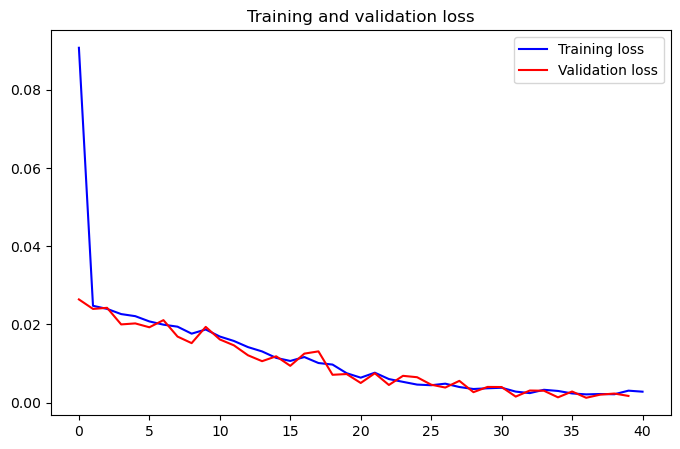

Test Accuracy of the model: 88.71428571428571 %
Epoch [42/100], Step [44/11], Loss: 0.0039, Accuracy: 91.43%
Test Accuracy of the model: 97.42857142857143 %
Epoch [43/100], Step [44/11], Loss: 0.0019, Accuracy: 96.78%
Test Accuracy of the model: 97.14285714285714 %
Epoch [44/100], Step [44/11], Loss: 0.0024, Accuracy: 95.39%
Test Accuracy of the model: 98.85714285714286 %
Epoch [45/100], Step [44/11], Loss: 0.0014, Accuracy: 98.14%
Test Accuracy of the model: 98.28571428571429 %
Epoch [46/100], Step [44/11], Loss: 0.0017, Accuracy: 97.71%
Test Accuracy of the model: 93.71428571428571 %
Epoch [47/100], Step [44/11], Loss: 0.0015, Accuracy: 98.07%
Test Accuracy of the model: 99.42857142857143 %
Epoch [48/100], Step [44/11], Loss: 0.0014, Accuracy: 98.29%
Test Accuracy of the model: 97.71428571428571 %
Epoch [49/100], Step [44/11], Loss: 0.0049, Accuracy: 91.96%
Test Accuracy of the model: 78.14285714285714 %
Epoch [50/100], Step [44/11], Loss: 0.0051, Accuracy: 89.35%
Test Accuracy of th

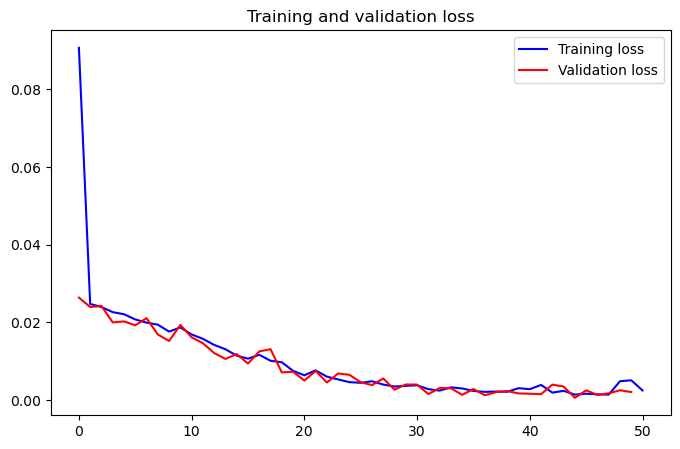

Test Accuracy of the model: 99.14285714285714 %
Epoch [52/100], Step [44/11], Loss: 0.0012, Accuracy: 98.68%
Test Accuracy of the model: 98.42857142857143 %
Epoch [53/100], Step [44/11], Loss: 0.0011, Accuracy: 98.32%
Test Accuracy of the model: 98.85714285714286 %
Epoch [54/100], Step [44/11], Loss: 0.0013, Accuracy: 98.11%
Test Accuracy of the model: 96.85714285714286 %
Epoch [55/100], Step [44/11], Loss: 0.0012, Accuracy: 98.46%
Test Accuracy of the model: 99.14285714285714 %
Epoch [56/100], Step [44/11], Loss: 0.0015, Accuracy: 97.28%
Test Accuracy of the model: 96.42857142857143 %
Epoch [57/100], Step [44/11], Loss: 0.0013, Accuracy: 97.75%
Test Accuracy of the model: 98.42857142857143 %
Epoch [58/100], Step [44/11], Loss: 0.0013, Accuracy: 97.86%
Test Accuracy of the model: 98.42857142857143 %
Epoch [59/100], Step [44/11], Loss: 0.0009, Accuracy: 98.82%
Test Accuracy of the model: 99.28571428571429 %
Epoch [60/100], Step [44/11], Loss: 0.0009, Accuracy: 98.89%
Test Accuracy of th

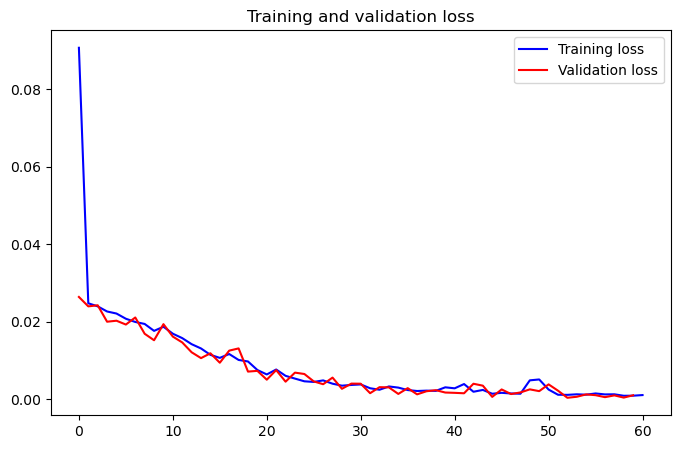

Test Accuracy of the model: 98.57142857142857 %
Epoch [62/100], Step [44/11], Loss: 0.0010, Accuracy: 98.61%
Test Accuracy of the model: 98.85714285714286 %
Epoch [63/100], Step [44/11], Loss: 0.0009, Accuracy: 98.64%
Test Accuracy of the model: 99.28571428571429 %
Epoch [64/100], Step [44/11], Loss: 0.0010, Accuracy: 98.46%
Test Accuracy of the model: 98.85714285714286 %
Epoch [65/100], Step [44/11], Loss: 0.0209, Accuracy: 52.63%
Test Accuracy of the model: 14.857142857142858 %
Epoch [66/100], Step [44/11], Loss: 0.0251, Accuracy: 32.30%
Test Accuracy of the model: 39.714285714285715 %
Epoch [67/100], Step [44/11], Loss: 0.0249, Accuracy: 33.73%
Test Accuracy of the model: 39.714285714285715 %
Epoch [68/100], Step [44/11], Loss: 0.0248, Accuracy: 33.73%
Test Accuracy of the model: 39.714285714285715 %
Epoch [69/100], Step [44/11], Loss: 0.0247, Accuracy: 33.73%
Test Accuracy of the model: 39.714285714285715 %
Epoch [70/100], Step [44/11], Loss: 0.0247, Accuracy: 33.73%
Test Accuracy 

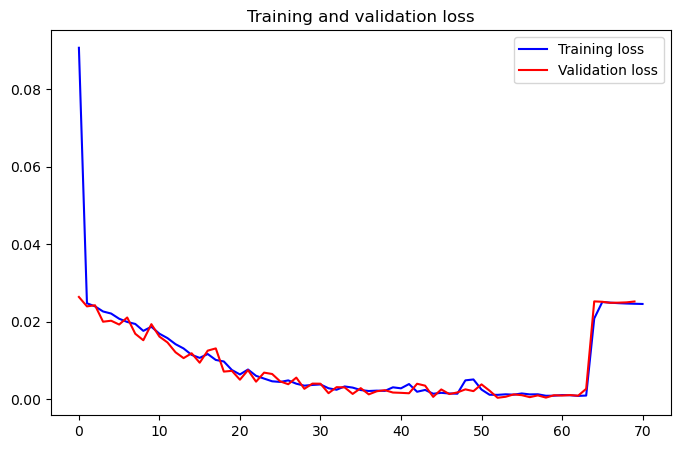

Test Accuracy of the model: 39.714285714285715 %
Epoch [72/100], Step [44/11], Loss: 0.0246, Accuracy: 33.73%
Test Accuracy of the model: 39.714285714285715 %
Epoch [73/100], Step [44/11], Loss: 0.0245, Accuracy: 33.73%
Test Accuracy of the model: 39.714285714285715 %
Epoch [74/100], Step [44/11], Loss: 0.0245, Accuracy: 33.73%
Test Accuracy of the model: 39.714285714285715 %
Epoch [75/100], Step [44/11], Loss: 0.0245, Accuracy: 33.73%
Test Accuracy of the model: 39.714285714285715 %
Epoch [76/100], Step [44/11], Loss: 0.0245, Accuracy: 33.73%
Test Accuracy of the model: 39.714285714285715 %
Epoch [77/100], Step [44/11], Loss: 0.0245, Accuracy: 33.73%
Test Accuracy of the model: 39.714285714285715 %
Epoch [78/100], Step [44/11], Loss: 0.0245, Accuracy: 33.73%
Test Accuracy of the model: 39.714285714285715 %
Epoch [79/100], Step [44/11], Loss: 0.0245, Accuracy: 33.73%
Test Accuracy of the model: 39.714285714285715 %
Epoch [80/100], Step [44/11], Loss: 0.0245, Accuracy: 33.73%
Test Accur

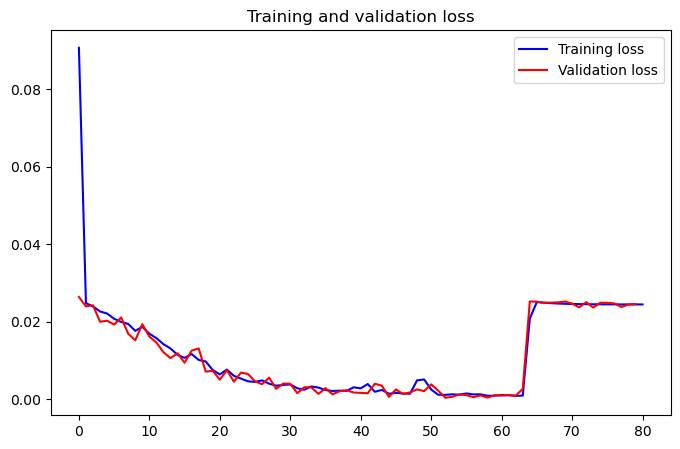

Test Accuracy of the model: 39.714285714285715 %
Epoch [82/100], Step [44/11], Loss: 0.0245, Accuracy: 33.73%
Test Accuracy of the model: 39.714285714285715 %
Epoch [83/100], Step [44/11], Loss: 0.0245, Accuracy: 33.73%
Test Accuracy of the model: 39.714285714285715 %
Epoch [84/100], Step [44/11], Loss: 0.0245, Accuracy: 33.73%
Test Accuracy of the model: 39.714285714285715 %
Epoch [85/100], Step [44/11], Loss: 0.0245, Accuracy: 33.73%
Test Accuracy of the model: 39.714285714285715 %
Epoch [86/100], Step [44/11], Loss: 0.0245, Accuracy: 33.73%
Test Accuracy of the model: 39.714285714285715 %
Epoch [87/100], Step [44/11], Loss: 0.0245, Accuracy: 33.73%
Test Accuracy of the model: 39.714285714285715 %
Epoch [88/100], Step [44/11], Loss: 0.0245, Accuracy: 33.73%
Test Accuracy of the model: 39.714285714285715 %
Epoch [89/100], Step [44/11], Loss: 0.0245, Accuracy: 33.73%
Test Accuracy of the model: 39.714285714285715 %
Epoch [90/100], Step [44/11], Loss: 0.0245, Accuracy: 33.73%
Test Accur

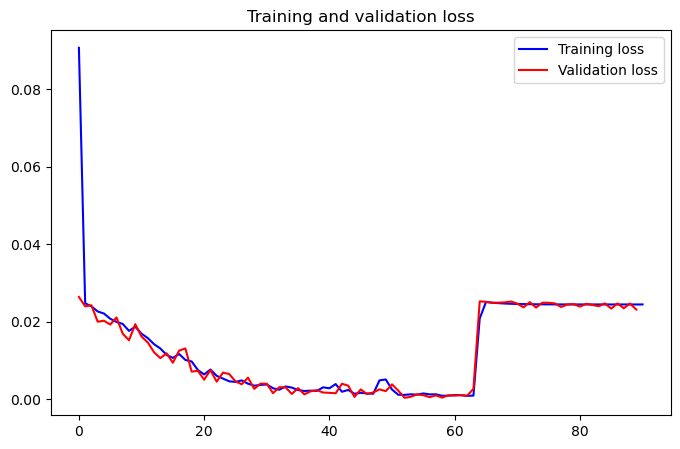

Test Accuracy of the model: 39.714285714285715 %
Epoch [92/100], Step [44/11], Loss: 0.0245, Accuracy: 33.73%
Test Accuracy of the model: 39.714285714285715 %
Epoch [93/100], Step [44/11], Loss: 0.0245, Accuracy: 33.73%
Test Accuracy of the model: 39.714285714285715 %
Epoch [94/100], Step [44/11], Loss: 0.0245, Accuracy: 33.73%
Test Accuracy of the model: 39.714285714285715 %
Epoch [95/100], Step [44/11], Loss: 0.0245, Accuracy: 33.73%
Test Accuracy of the model: 39.714285714285715 %
Epoch [96/100], Step [44/11], Loss: 0.0245, Accuracy: 33.73%
Test Accuracy of the model: 39.714285714285715 %
Epoch [97/100], Step [44/11], Loss: 0.0245, Accuracy: 33.73%
Test Accuracy of the model: 39.714285714285715 %
Epoch [98/100], Step [44/11], Loss: 0.0245, Accuracy: 33.73%
Test Accuracy of the model: 39.714285714285715 %
Epoch [99/100], Step [44/11], Loss: 0.0245, Accuracy: 33.73%
Test Accuracy of the model: 39.714285714285715 %
Epoch [100/100], Step [44/11], Loss: 0.0245, Accuracy: 33.73%
Test Accu

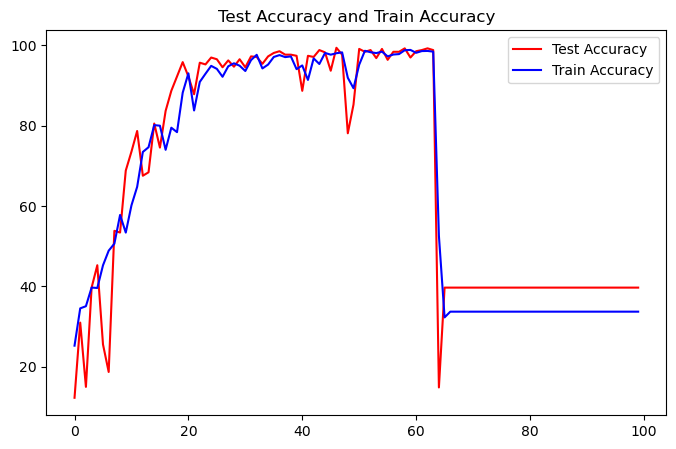

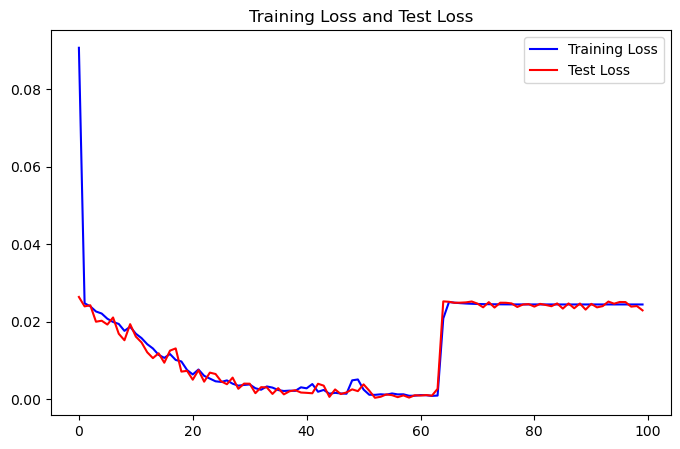

In [74]:
class CancerModel2(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(CancerModel2, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        
        return out
    
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

model = CancerModel(X_train.shape[1], 256, 5)

model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 100

logs = {}
logs['train_loss'] = []
logs['train_Accuracy'] = []
logs['val_loss'] = []
logs['val_Accuracy'] = []


for epoch in range(epochs):
    total_correct = 0
    total_loss = 0
    total_genes = 0
    total_val_loss = 0

    model.train()
    for i, (data, target) in enumerate(train_loader):

        genes = data.to(device)
        labels = target.to(device)

        outputs = model(genes)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_genes += labels.size(0)

        _, predicted = torch.max(outputs.detach(), 1)

        correct = (predicted == labels).sum().item()

        total_correct += correct
        total_loss += loss.item()
    logs['train_loss'].append(total_loss / total_genes)
    logs['train_Accuracy'].append((total_correct / total_genes) * 100)


    print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
              .format(epoch + 1, epochs, i + 1, len(test_loader), (total_loss / total_genes),
                      (total_correct / total_genes) * 100))
    
    if epoch % 10 == 0:
        fig, ax = plt.subplots(figsize=(8, 5))
        ax.plot(logs['train_loss'], 'b', label='Training loss')
        ax.plot(logs['val_loss'], 'r', label='Validation loss')
        ax.set_title('Training and validation loss')
        ax.legend()
        plt.show()
    
    model.eval()

    with torch.no_grad():
        correct = 0
        total = 0
        total_losss = 0

        for data, target in test_loader:
            genes = data.to(device)
            labels = target.to(device)
            outputs = model(genes)

            _, predicted = torch.max(outputs.detach(), 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            total_losss += loss.item()

            accuracy = correct / total

        print('Test Accuracy of the model: {} %'.format(100 * correct / total))
        logs['val_loss'].append(total_losss / total)
        logs['val_Accuracy'].append((correct / total) * 100)

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(logs['val_Accuracy'], 'r', label='Test Accuracy')
ax.plot(logs['train_Accuracy'], 'b', label='Train Accuracy')
ax.set_title('Test Accuracy and Train Accuracy')
ax.legend()
plt.show()

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(logs['train_loss'], 'b', label='Training Loss')
ax.plot(logs['val_loss'], 'r', label='Test Loss')
ax.set_title('Training Loss and Test Loss')
ax.legend()
plt.show()

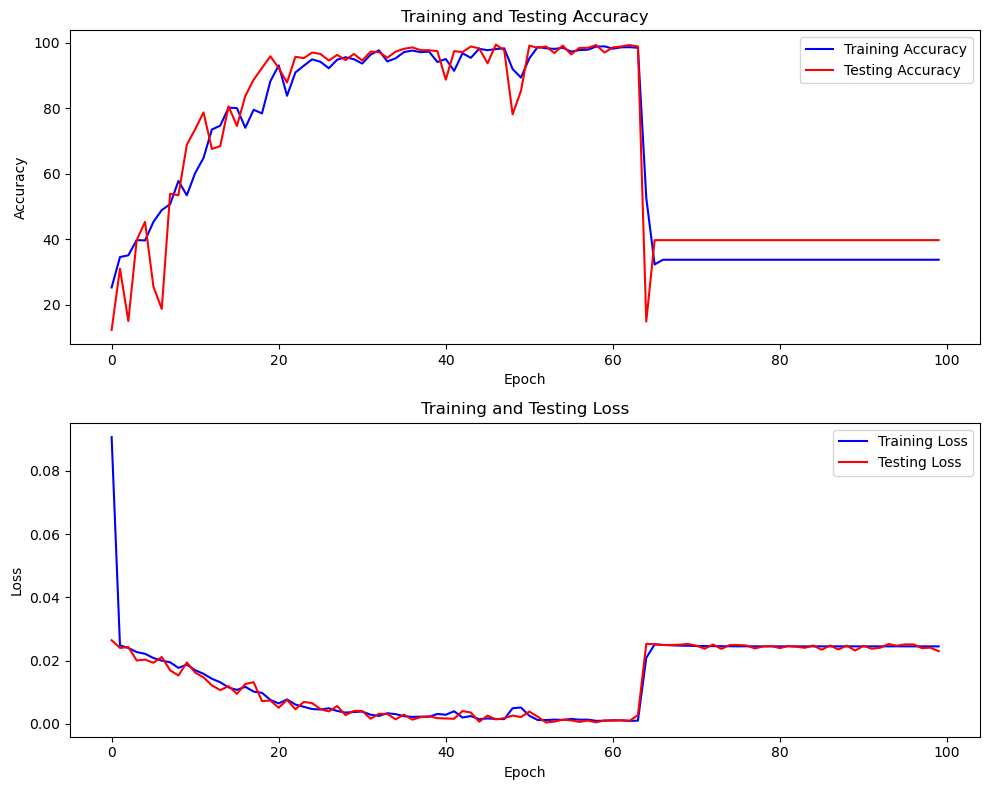

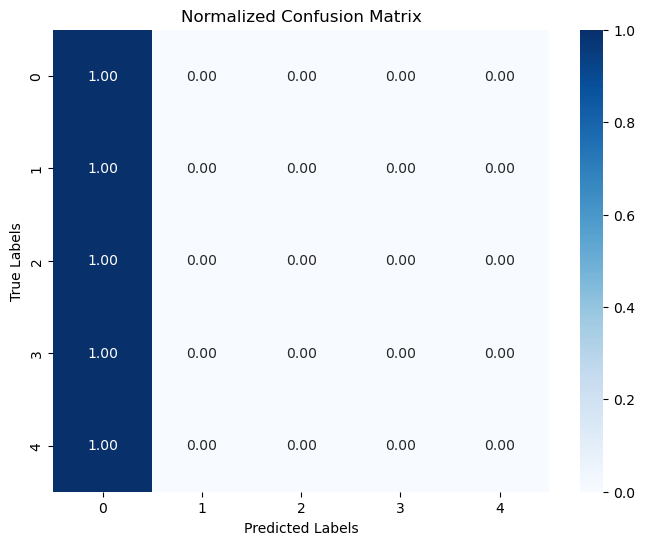

In [75]:
# plot the normalized confusion matrix
cm = get_confusion_matrix(model, test_loader, device)
normalized_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plot training and testing accuracy
ax1.plot(logs['train_Accuracy'], 'b', label='Training Accuracy')
ax1.plot(logs['val_Accuracy'], 'r', label='Testing Accuracy')
ax1.set_title('Training and Testing Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Plot training and testing validity
ax2.plot(logs['train_loss'], 'b', label='Training Loss')
ax2.plot(logs['val_loss'], 'r', label='Testing Loss')
ax2.set_title('Training and Testing Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(normalized_cm, annot=True, fmt=".2f", cmap="Blues")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Normalized Confusion Matrix')
plt.show()

The final model is one that utilizes PCA to reduce features fed into the model:

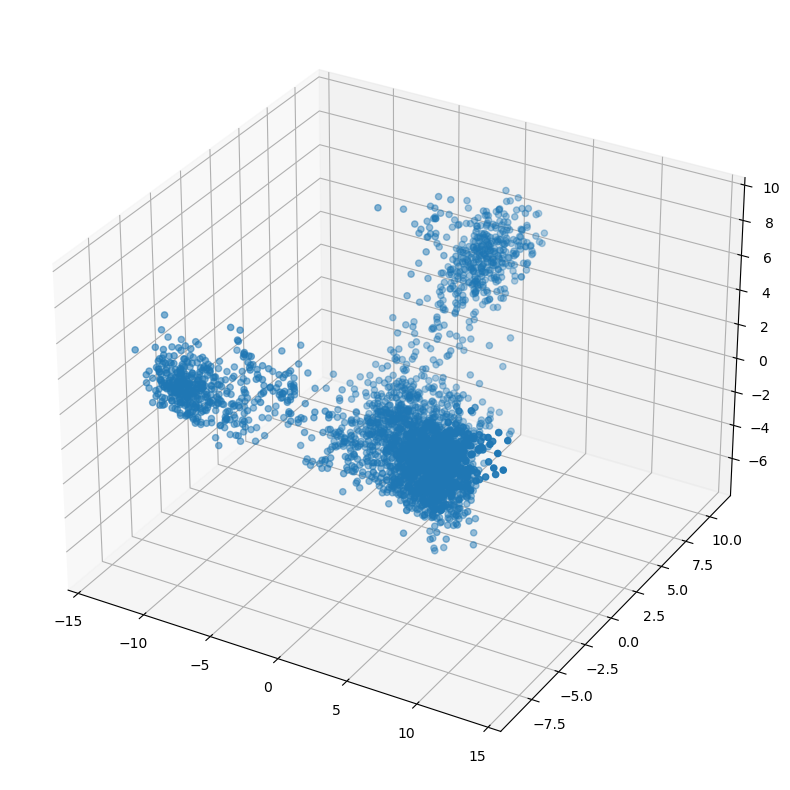

Epoch [1/100], Step [44/11], Loss: 0.0078, Accuracy: 93.32%


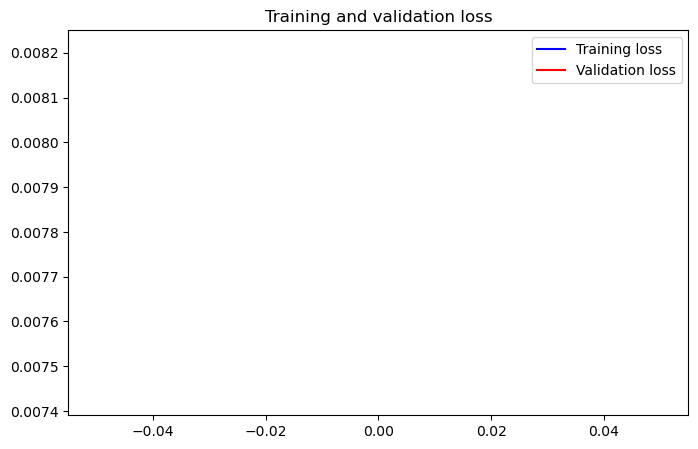

Test Accuracy of the model: 98.57142857142857 %
Epoch [2/100], Step [44/11], Loss: 0.0010, Accuracy: 99.04%
Test Accuracy of the model: 99.42857142857143 %
Epoch [3/100], Step [44/11], Loss: 0.0006, Accuracy: 99.39%
Test Accuracy of the model: 99.42857142857143 %
Epoch [4/100], Step [44/11], Loss: 0.0004, Accuracy: 99.39%
Test Accuracy of the model: 99.42857142857143 %
Epoch [5/100], Step [44/11], Loss: 0.0003, Accuracy: 99.50%
Test Accuracy of the model: 99.42857142857143 %
Epoch [6/100], Step [44/11], Loss: 0.0002, Accuracy: 99.68%
Test Accuracy of the model: 99.42857142857143 %
Epoch [7/100], Step [44/11], Loss: 0.0002, Accuracy: 99.82%
Test Accuracy of the model: 99.57142857142857 %
Epoch [8/100], Step [44/11], Loss: 0.0001, Accuracy: 99.93%
Test Accuracy of the model: 99.57142857142857 %
Epoch [9/100], Step [44/11], Loss: 0.0001, Accuracy: 99.96%
Test Accuracy of the model: 99.57142857142857 %
Epoch [10/100], Step [44/11], Loss: 0.0001, Accuracy: 99.96%
Test Accuracy of the model:

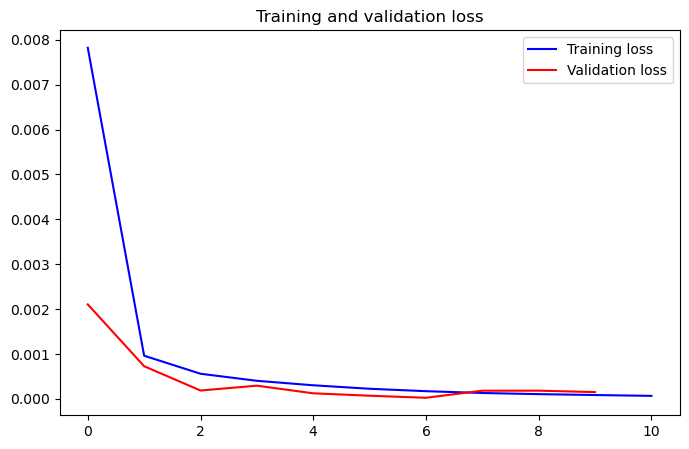

Test Accuracy of the model: 99.42857142857143 %
Epoch [12/100], Step [44/11], Loss: 0.0001, Accuracy: 100.00%
Test Accuracy of the model: 99.42857142857143 %
Epoch [13/100], Step [44/11], Loss: 0.0000, Accuracy: 100.00%
Test Accuracy of the model: 99.42857142857143 %
Epoch [14/100], Step [44/11], Loss: 0.0000, Accuracy: 100.00%
Test Accuracy of the model: 99.42857142857143 %
Epoch [15/100], Step [44/11], Loss: 0.0000, Accuracy: 100.00%
Test Accuracy of the model: 99.42857142857143 %
Epoch [16/100], Step [44/11], Loss: 0.0000, Accuracy: 100.00%
Test Accuracy of the model: 99.42857142857143 %
Epoch [17/100], Step [44/11], Loss: 0.0000, Accuracy: 100.00%
Test Accuracy of the model: 99.42857142857143 %
Epoch [18/100], Step [44/11], Loss: 0.0000, Accuracy: 100.00%
Test Accuracy of the model: 99.42857142857143 %
Epoch [19/100], Step [44/11], Loss: 0.0000, Accuracy: 100.00%
Test Accuracy of the model: 99.42857142857143 %
Epoch [20/100], Step [44/11], Loss: 0.0000, Accuracy: 100.00%
Test Accur

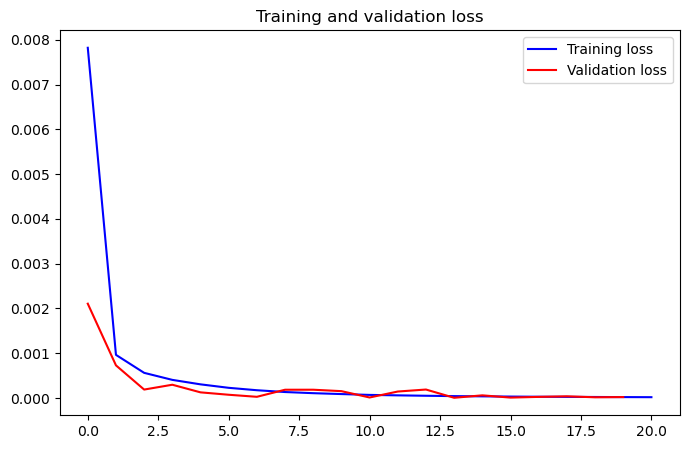

Test Accuracy of the model: 99.42857142857143 %
Epoch [22/100], Step [44/11], Loss: 0.0000, Accuracy: 100.00%
Test Accuracy of the model: 99.42857142857143 %
Epoch [23/100], Step [44/11], Loss: 0.0000, Accuracy: 100.00%
Test Accuracy of the model: 99.42857142857143 %
Epoch [24/100], Step [44/11], Loss: 0.0000, Accuracy: 100.00%
Test Accuracy of the model: 99.42857142857143 %
Epoch [25/100], Step [44/11], Loss: 0.0000, Accuracy: 100.00%
Test Accuracy of the model: 99.42857142857143 %
Epoch [26/100], Step [44/11], Loss: 0.0000, Accuracy: 100.00%
Test Accuracy of the model: 99.42857142857143 %
Epoch [27/100], Step [44/11], Loss: 0.0000, Accuracy: 100.00%
Test Accuracy of the model: 99.42857142857143 %
Epoch [28/100], Step [44/11], Loss: 0.0000, Accuracy: 100.00%
Test Accuracy of the model: 99.42857142857143 %
Epoch [29/100], Step [44/11], Loss: 0.0000, Accuracy: 100.00%
Test Accuracy of the model: 99.42857142857143 %
Epoch [30/100], Step [44/11], Loss: 0.0000, Accuracy: 100.00%
Test Accur

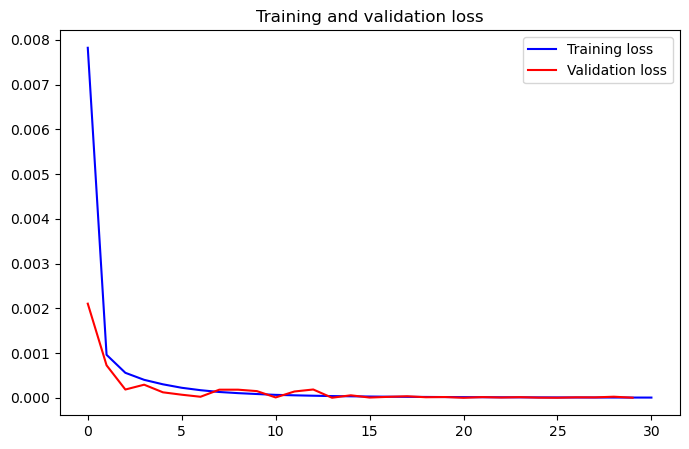

Test Accuracy of the model: 99.42857142857143 %
Early stopping triggered. No improvement in validation loss for 10 epochs.


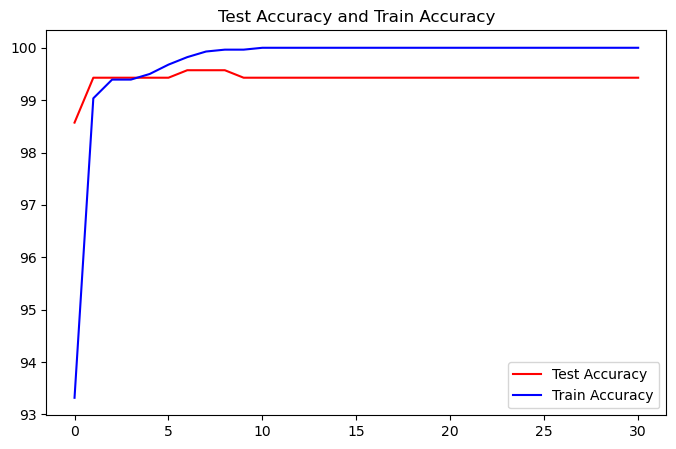

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


k_best = SelectKBest(score_func=f_classif, k=100) 
X_train = k_best.fit_transform(X_train, y_train)
X_test = k_best.transform(X_test)

pca_genes = PCA(n_components=3).fit_transform(X_train)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_genes[:, 0], pca_genes[:, 1], pca_genes[:, 2])
plt.show()


train_dataset = CancerDataset(X_train, y_train)
test_dataset = CancerDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

model = CancerModel(X_train.shape[1], 128, 5)

# Set device
device = torch.device('cpu') #torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Set loss function, optimizer, and number of epochs
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 100

logs = {}
logs['train_loss'] = []
logs['train_Accuracy'] = []
logs['val_loss'] = []
logs['val_Accuracy'] = []

best_val_loss = float('inf')
early_stop_counter = 0
patience = 10

for epoch in range(epochs):
    total_correct = 0
    total_loss = 0
    total_genes = 0
    total_val_loss = 0

    model.train()
    for i, (data, target) in enumerate(train_loader):
        genes = data.to(device)
        labels = target.to(device)

        outputs = model(genes)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_genes += labels.size(0)

        _, predicted = torch.max(outputs.detach(), 1)

        correct = (predicted == labels).sum().item()

        total_correct += correct
        total_loss += loss.item()
    logs['train_loss'].append(total_loss / total_genes)
    logs['train_Accuracy'].append((total_correct / total_genes) * 100)

    print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
          .format(epoch + 1, epochs, i + 1, len(test_loader), (total_loss / total_genes),
                  (total_correct / total_genes) * 100))

    if epoch % 10 == 0:
        fig, ax = plt.subplots(figsize=(8, 5))
        ax.plot(logs['train_loss'], 'b', label='Training loss')
        ax.plot(logs['val_loss'], 'r', label='Validation loss')
        ax.set_title('Training and validation loss')
        ax.legend()
        plt.show()

    model.eval()

    with torch.no_grad():
        correct = 0
        total = 0
        total_losss = 0

        for data, target in test_loader:
            genes = data.to(device)
            labels = target.to(device)
            outputs = model(genes)

            _, predicted = torch.max(outputs.detach(), 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            total_losss += loss.item()

            accuracy = correct / total

        print('Test Accuracy of the model: {} %'.format(100 * correct / total))
        logs['val_loss'].append(total_losss / total)
        logs['val_Accuracy'].append((correct / total) * 100)

        # Early stopping check
        if logs['val_loss'][-1] < best_val_loss:
            best_val_loss = logs['val_loss'][-1]
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            if early_stop_counter >= patience:
                print('Early stopping triggered. No improvement in validation loss for {} epochs.'.format(patience))
                break

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(logs['val_Accuracy'], 'r', label='Test Accuracy')
ax.plot(logs['train_Accuracy'], 'b', label='Train Accuracy')
ax.set_title('Test Accuracy and Train Accuracy')
ax.legend()
plt.show()